In [ ]:
# !pip install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl numpy matplotlib  

**Some helper methods**
 - computing losses divided by parts of body (purely for comparison purpose -> not for training loss backprop)
    - will be part of the pkl file that gets generated (will save as *all.losses.{version#}.pkl**)


In [1]:
from google.colab import drive
drive.mount('/content/drive')

### CHANGE DIRECTORY LOCATION ###
# Make this point to the correct location. Need to connect the sharedDrive to my Drive. 
# Follow instruction here https://stackoverflow.com/a/54352105
%cd '/content/drive/My Drive/DLF2020/dlf2020'
%ls
output_folder = "src/Bhagyashree Experiments/With_Pretrained_H_10/smaller data videos"

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1XCqSJ4wOA_0YGBeiVFwWnOq2NUCpBEMO/DLF2020/dlf2020
 all.losses.v1.pkl            README.md
 app.py                       requirements.txt
 data/                        retain_old_trained_transformer_204.pkl
'Data Collection Module'/     src/
 dataset_4_people.pkl         trained_transformer_100.pkl
 gan.all.losses.v1.pkl        trained_transformer_204.pkl
 output_movies/               trained_transformer_model_300.pkl
 output_movies_b/             transformer.all.losses.v1.pkl
 quarter_data_50_epochs.pkl


In [2]:
# Standard PyTorch imports
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy
from torch.autograd import Variable

# For plots
%matplotlib inline
import matplotlib.pyplot as plt

import json
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import pickle
import numpy as np

import matplotlib.pyplot as plt
import numpy as np
# from torchtext.vocab import GloVe
# glove_embedding = GloVe(dim = 100)
# print(torch.cat((glove_embedding['apart'], torch.zeros(2))))
# print(glove_embedding['apart'].shape)

In [3]:
# use cuda is available
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [4]:
# creates a embedding dictionary of word to embedding. 
#We want 250 dimension so concatennating two embedding txt files (one with 200 and other with 50 dimensions)
embeddings_dict = {}
with open("data/interim/glove.6B.200d.txt", 'r') as f: 
      for line in f:
          values = line.split()
          word = values[0]
          vector = np.asarray(values[1:], "float32")
          embeddings_dict[word] = vector
with open("data/interim/glove.6B.50d.txt", 'r') as f: 
      for line in f:
          values = line.split()
          word = values[0]
          vector = np.asarray(values[1:], "float32")
          embeddings_dict[word] = np.append(embeddings_dict[word],vector)

## Classes needed to construct the model

In [5]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base model for this and many 
    other models.
    """
    def __init__(self, encoder, decoder):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, src, tgt, tgt_mask):
        "Take in and process masked src and target sequences."
        memory = self.encoder(src)
        output = self.decoder(tgt, memory, tgt_mask)
        
        return output

In [6]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [7]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N = 1):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        
    def forward(self, x):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x)
        return x

In [8]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [9]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity we apply the norm first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer function that maintains the same size."
        return x + self.dropout(sublayer(self.norm(x)))

In [10]:
class EncoderLayer(nn.Module):
    "Encoder is made up of two sublayers, self-attn and feed forward (defined below)"
    def __init__(self, size, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.feed_forward = feed_forward
        self.size = size

    def forward(self, x):
        "Follow Figure 1 (left) for connections."
        return self.feed_forward(x)

In [11]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N, continuous_embedding, counter_embedding):
        super(Decoder, self).__init__()
        self.continuous_embedding = continuous_embedding
        self.counter_embedding = counter_embedding
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, tgt_mask):
        continuous_embedding = self.continuous_embedding(x[:,:,:-counter_index:])
        counter_embedding = torch.cat((self.counter_embedding(x[:,:,-counter_index:-counter_index+1]),torch.zeros(x.shape[0],x.shape[1],counter_index-1).to(device)), axis=2)
        continuous_embedding = torch.cat((continuous_embedding,counter_embedding), axis=2)
        x = continuous_embedding
        
        for layer in self.layers:
            x = layer(x, memory, tgt_mask)
        return self.norm(x)

        # with counter embedding layer = batch_size x 185
        # continuous_embedding = self.continuous_embedding(x[:,:,:360:])
        # counter_embedding = torch.cat((self.counter_embedding(x[:,:,360:361].squeeze()).unsqueeze(2),torch.zeros((x.shape[0],x.shape[1],3)).cuda()),axis=2)
        # input = torch.cat((continuous_embedding,counter_embedding), axis=2)
        # for layer in self.layers:
        #     input = layer(input, memory, tgt_mask)
        # return self.norm(input)

In [12]:
class DecoderLayer(nn.Module):
    "Decoder is made up of three sublayers, self-attn, src-attn, and feed forward (defined below)"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
        
    def forward(self, x, memory, tgt_mask):
        "Follow Figure 1 (right) for connections."
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        # todo check src_mask can be None or should be something valid
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, None))
        return self.sublayer[2](x, self.feed_forward)

In [13]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

In [14]:
def attention(query, key, value, mask=None, dropout=0.0):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    # (Dropout described below)
    p_attn = F.dropout(p_attn, p=dropout)
    return torch.matmul(p_attn, value), p_attn

In [15]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.p = dropout
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        
    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
                             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.p)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

In [16]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model_input, d_model_output, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        # Torch linears have a `b` by default. 
        self.w_1 = nn.Linear(d_model_input, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model_output)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

In [17]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term) 
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        return self.dropout(x)

## Full Model

In [18]:
def make_model(N=6, d_model_input=102, d_model_output=102, d_ff=1024, h=5, dropout=0.1):
    # TRY different h values and N values remember  
    "Construct a model object based on hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model_output, dropout)
    # ff_encoder = PositionwiseFeedForward(d_model_input, d_model_output, d_ff, dropout)
    # ff_encoder = nn.Sequential(nn.Linear(d_model_input, 512), nn.ReLU(), nn.Linear(512, d_model_output))
    ff_encoder = nn.Linear(d_model_input, d_model_output)
    ff_decoder = PositionwiseFeedForward(d_model_output, d_model_output, d_ff, dropout)
    position = PositionalEncoding(d_model_output, dropout)
    continuous_embedding = nn.Sequential(nn.Linear(d_model_output-counter_index, d_ff), nn.ReLU(), nn.Linear(d_ff, d_model_output-counter_index))
    # counter_embedding = nn.Sequential(nn.Linear(max_sequence_length,max_sequence_length), nn.Sigmoid())
    counter_embedding = nn.Linear(1,1)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model_input, c(ff_encoder), dropout), N=1),
        Decoder(DecoderLayer(d_model_output, c(attn), c(attn), c(ff_decoder), dropout), N, continuous_embedding, counter_embedding))
    
    # This was important from their code. Initialize parameters with Glorot or fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

In [ ]:
# Small example model.
# tmp_model = make_model()
# tmp_model

# Training

This section describes the training regime for our models.


In [19]:
# Note: This part is incredibly important. 
# Need to train with this setup of the model is very unstable.
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup**(-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.encoder.layers[0].size, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

In [20]:
import numpy
def normalization(Xx, Xy):
  T, n = Xx.shape
  sum0 = T * n
  sum1Xx = np.sum(np.sum(Xx))
  sum2Xx = np.sum(np.sum(Xx * Xx))
  sum1Xy = np.sum(np.sum(Xy))
  sum2Xy = np.sum(np.sum(Xy * Xy))
  mux = sum1Xx / sum0
  muy = sum1Xy / sum0
  sum0 = 2 * sum0
  sum1 = sum1Xx + sum1Xy
  sum2 = sum2Xx + sum2Xy
  mu = sum1 / sum0
  sigma2 = (sum2 / sum0) - mu * mu
  if sigma2 < 1e-10:
    simga2 = 1e-10
  sigma = math.sqrt(sigma2)
  return (Xx - mux) / sigma, (Xy - muy) / sigma

def prune(Xx, Xy, Xw, watchThis, threshold, dtype):
  T = Xw.shape[0]
  N = Xw.shape[1]
  Yx = numpy.zeros((T, N), dtype=dtype)
  Yy = numpy.zeros((T, N), dtype=dtype)
  Yw = numpy.zeros((T, N), dtype=dtype)
  for t in range(T):
    sum0 = 0
    sum1 = 0.0
    for i in watchThis:
      sum0 = sum0 + 1
      sum1 = sum1 + Xw[t, i]
    Ew = sum1 / sum0
    if Ew >= threshold:
      for i in range(N):
        Yx[t, i] = Xx[t, i]
        Yy[t, i] = Xy[t, i]
        Yw[t, i] = Xw[t, i]
  return Yx, Yy, Yw


def interpolation(Xx, Xy, Xw, threshold, dtype):
  T = Xw.shape[0]
  N = Xw.shape[1]
  Yx = numpy.zeros((T, N), dtype=dtype)
  Yy = numpy.zeros((T, N), dtype=dtype)
  for t in range(T):
    for i in range(N):
      a1 = Xx[t, i]
      a2 = Xy[t, i]
      p = Xw[t, i]
      sumpa1 = p * a1
      sumpa2 = p * a2
      sump = p
      delta = 0
      while sump < threshold:
        change = False
        delta = delta + 1
        t2 = t + delta
        if t2 < T:
          a1 = Xx[t2, i]
          a2 = Xy[t2, i]
          p = Xw[t2, i]
          sumpa1 = sumpa1 + p * a1
          sumpa2 = sumpa2 + p * a2
          sump = sump + p
          change = True
        t2 = t - delta
        if t2 >= 0:
          a1 = Xx[t2, i]
          a2 = Xy[t2, i]
          p = Xw[t2, i]
          sumpa1 = sumpa1 + p * a1
          sumpa2 = sumpa2 + p * a2
          sump = sump + p
          change = True
        if not change:
          break
      if sump <= 0.0:
        sump = 1e-10
      Yx[t, i] = sumpa1 / sump
      Yy[t, i] = sumpa2 / sump
  return Yx, Yy, Xw

def convList2Array(lst): 
  T, dim = lst[0].shape
  a = []
  for t in range(T):
    a_t = []
    for i in range(dim):
      for j in range(len(lst)):
        a_t.append(lst[j][t, i])
    a.append(a_t)
    # keep output of 20 frames
    # downsample_rate = dim // 20
    # a = numpy.asarray(a)
    # print(dim, downsample_rate)
    # a = a[0:dim:downsample_rate,:]
  return numpy.asarray(a)

In [21]:
class PoseDataset(Dataset):
    """PoseDataset."""
    def __init__(self, data, transform=None):          
        self.embeddings = torch.tensor(data['embedding'], dtype=torch.float32)
        self.poses = torch.tensor(data['skeleton'], dtype=torch.float32)
        print(len(self.embeddings),len(self.embeddings[0]),len(self.poses),len(self.poses[0]), len(self.poses[0][0]))
        
    def __len__(self):
        return len(self.poses)

    def __getitem__(self, idx):
        sample = {'embedding': self.embeddings[idx], 'poses': self.poses[idx]}
        return sample


"""
reads trainable data. It is a dictionary of the form: 
{
  skeleton: poses 
  embedding: word embeddings of size 250
  video: list of videoids
  gloss: list of words
}
Data is about 3GB so takes a sec to read it.
"""
with open('../Training Data/trainable.2ddata.with.face.firsthalf.pkl', 'rb') as f:
  first_data = pickle.load(f)
with open('../Training Data/trainable.2ddata.with.face.secondhalf.pkl', 'rb') as f:
 second_data = pickle.load(f)
data = {
    "skeleton": np.concatenate((first_data["skeleton"], second_data["skeleton"])),
    "embedding": np.concatenate((first_data["embedding"], second_data["embedding"])),
    "gloss": np.concatenate((first_data["gloss"], second_data["gloss"])),
    "video": np.concatenate((first_data["video"], second_data["video"])),
}
# data = {
#     "skeleton": first_data["skeleton"],
#     "embedding": first_data["embedding"],
#     "gloss": first_data["gloss"],
#     "video": first_data["video"],
# }

dataset = PoseDataset(data)

KeyboardInterrupt: ignored

In [ ]:
batch_size = 32
counter_index = 10
from collections import Counter
words_with_only_video = []
c = Counter(data["gloss"][:600:])
indices_to_be_removed = []

for i in range(len(data["gloss"])):
  if c[data["gloss"][i]] == 1:
    indices_to_be_removed.append(i)

print(data["gloss"].shape,data["skeleton"].shape,data["video"].shape,data["embedding"].shape)

print(len(indices_to_be_removed))
data["gloss"] = np.delete(data["gloss"],indices_to_be_removed,axis = 0)[:600]
data["video"] = np.delete(data["video"],indices_to_be_removed,axis = 0)[:600]
data["skeleton"] = np.delete(data["skeleton"],indices_to_be_removed,axis = 0)[:600]
data["embedding"] = np.delete(data["embedding"],indices_to_be_removed,axis = 0)[:600]

print(data["gloss"].shape,data["skeleton"].shape,data["video"].shape,data["embedding"].shape)

from sklearn.model_selection import train_test_split
# gloss based split function
def gloss_based_split_datasets(data):  
  s, e, g, v = data["skeleton"], data["embedding"], data["gloss"], data["video"]
  s_train, s_val,e_train, e_val,g_train, g_val, v_train, v_val  = train_test_split(s, e, g, v, test_size=140, stratify = g)
  # np.unique(y_train, return_counts=True)
  # np.unique(y_val, return_counts=True)
  print(s_train.shape,s_val.shape)
  train_dataset = PoseDataset({"skeleton": s_train, "embedding": e_train, "gloss": g_train, "video":v_train})
  val_dataset = PoseDataset({"skeleton": s_val, "embedding": e_val,"gloss": g_val,"video":v_val})
  train_loader = DataLoader(train_dataset, batch_size = batch_size)
  validation_loader = DataLoader(val_dataset, batch_size = batch_size)
  return train_loader, validation_loader

train_loader, validation_loader = gloss_based_split_datasets(data)

(12653,) (12653, 176, 250) (12653,) (12653, 250)
71
(600,) (600, 176, 250) (600,) (600, 250)
(460, 176, 250) (140, 176, 250)
460 250 460 176 250
140 250 140 176 250


In [ ]:
print(data["gloss"])

['visit' 'visualize' 'visualize' 'value' 'value' 'vlog' 'visit' 'vampire'
 'vampire' 'vomit' 'vomit' 'volunteer' 'voice' 'violin' 'voice' 'vomit'
 'voice' 'verb' 'vlog' 'vacation' 'very' 'verb' 'visualize' 'violin'
 'very' 'vegetable' 'vague' 'violin' 'volleyball' 'voice' 'vegetable'
 'voice' 'voice' 'vacation' 'vomit' 'vomit' 'vocabulary' 'vegetable'
 'volleyball' 'volunteer' 'viewpoint' 'vacation' 'vomit' 'vague' 'very'
 'vomit' 'vacation' 'volleyball' 'vague' 'violin' 'visitor' 'vote'
 'violin' 'vegetable' 'volleyball' 'vomit' 'vague' 'vote' 'vacant' 'vague'
 'vampire' 'vomit' 'vote' 'violin' 'volunteer' 'vote' 'vegetable'
 'vocabulary' 'vote' 'vlog' 'visit' 'viewpoint' 'vacation' 'vote' 'violin'
 'vocabulary' 'vacant' 'vlog' 'volleyball' 'vocabulary' 'valley' 'visit'
 'visualize' 'visitor' 'vlog' 'valley' 'valley' 'visitor' 'verb' 'vote'
 'vocabulary' 'visit' 'vocabulary' 'verb' 'visit' 'visit' 'visitor'
 'viewpoint' 'value' 'value' 'visitor' 'visit' 'visit' 'visitor' 'visit'
 'vot

In [ ]:
# # the following code concatenates the 2d points from each file, we find corresponding gloss and its encoding and an array of corresponding sequences 
# # we replace z values with 0 currently
# max_sequence_length = 0
# pad = 2
# sequence_limit = 175
# counter_index = 10
# class PoseDataset(Dataset):
#     """PoseDataset."""
#     def __init__(self, training_data_json, words_pickle, embeddings_pickle, videos_root_dir, transform=None):
#         # we go through the entire folder containing the videos and for each video id we find the gloss and for that gloss we find the embedding from the pickle file
#         self.embeddings = []
#         self.poses = []
#         f = open(training_data_json,'r')
#         temp = json.load(f)
#         video_gloss_mapping = {}
#         for entry in temp:
#             gloss = entry['gloss']
#             for videos in entry['instances']:
#                 video_gloss_mapping[videos['video_id']] = gloss
#         word_embeddings = []
#         words = []
#         # with (open(embeddings_pickle, "rb")) as openfile:
#         #     while True:
#         #         try:
#         #             word_embeddings.append(pickle.load(openfile))
#         #         except EOFError:
#         #             break
#         # with (open(words_pickle, "rb")) as openfile:
#         #     while True:
#         #         try:
#         #             words.append(pickle.load(openfile))
#         #         except EOFError:
#         #             break
#         for video_name in os.listdir(videos_root_dir):
#           try:
#             gloss = video_gloss_mapping[video_name[:video_name.index('.'):]]
#             data = json.load(open(os.path.join(videos_root_dir,video_name)))
#             max_count = max([int(i) for i in list(data.keys())])
#             actual_count = 0
#             temp = []
#             # we add counter at the end of each pose
#             # we store 0 for z positions
#             if max_count == 0 or max_count > sequence_limit:
#               continue
#             for count in data.keys():
#                 # 'face_keypoints_2d', 'hand_left_keypoints_2d', hand_right_keypoints_2d','pose_keypoints_2d'
#                 # if people array is empty we need to skip that frame
#                 if len(data[count]['people']) > 0:
#                     # added extra 0 to balance heads for multi headed attention 
#                     t = data[count]['people'][0]['pose_keypoints_2d'][:24:] + data[count]['people'][0]['hand_left_keypoints_2d'] + data[count]['people'][0]['hand_right_keypoints_2d'] + data[count]['people'][0]['face_keypoints_2d'] + [actual_count / max_count] + [0] * 9
#                     # the following loop converts z coordinates to 0
#                     # for i in range(2,len(t)-2,3):
#                     #     t[i] = 0
#                     temp.append(t)
#                     actual_count += 1
#             # indices = np.argwhere(words[0] == gloss)[0]

#             temp = np.array(temp)
#             n = temp.shape[-1] - counter_index
#             X = temp[:, 0:n:3]
#             Y = temp[:, 1:n:3]
#             W = temp[:, 2:n:3]
#             # normalization
#             X, Y = normalization(X, Y)
#             # Delete all skeletal models which have a lot of missing parts.
#             X, Y, W = prune(X, Y, W, (0, 1, 2, 3, 4, 5, 6, 7), 0.3, "float32")
#             # Preliminary filtering: weighted linear interpolation of missing points.
#             X, Y, W = interpolation(X, Y, W, 0.99, "float32")
#             # we are removing extra points from face just to simplify dimensions
#             arr = np.append(convList2Array([X,Y]),temp[:,-counter_index:], axis=1)
#             # temp[:, :-2] = arr[:,:]
#             # temp[:, 2:n:3] = 0

        
#             #self.embeddings.append(word_embeddings[0][indices[0]].tolist())
#             try:
#                 self.embeddings.append(embeddings_dict[gloss])
#                 self.poses.append(arr)
#             except:
#                 # print(gloss + " out of vocabulary")
#                 pass
#           except:
#             print('some error')
#             pass
                
#         max_rows = max([len(row) for row in self.poses])
#         global max_sequence_length
#         max_sequence_length = max_rows
#         # padding to make all sequences of same length
#         for i in range(len(self.poses)):
#           batch = self.poses[i]
#           padded_input = np.zeros((max_rows - len(batch), len(batch[0])))
#           # padded_input.fill(pad)
#           padded_input[:, -counter_index] = pad
#           self.poses[i] = np.vstack((batch, padded_input))
          
#         self.embeddings = torch.tensor(self.embeddings, dtype=torch.float32)
#         self.poses = torch.tensor(self.poses, dtype=torch.float32)
 
#         print(len(self.embeddings),len(self.embeddings[0]),len(self.poses),len(self.poses[0]), len(self.poses[0][0]))
        
#     def __len__(self):
#         return len(self.poses)

#     def __getitem__(self, idx):
#         sample = {'embedding': self.embeddings[idx], 'poses': self.poses[idx]}
#         return sample
        
# dataset = PoseDataset("./Data Collection Module/WLASL_v0.3.json", "./data/interim/words.pkl", "data/interim/embeddings.pkl", "./data/interim/Training Data/2D Data/")

In [ ]:
# batch_size = 32
# validation_split = .2
# shuffle_dataset = True
# random_seed= 42
# pad = 2
# counter_index = 10
# max_sequence_length = max([len(row) for row in data["skeleton"]])

# # Creating data indices for training and validation splits:
# dataset_size = len(dataset)
# indices = list(range(dataset_size))
# split = int(np.floor(validation_split * dataset_size))
# if shuffle_dataset :
#     np.random.seed(random_seed)
#     np.random.shuffle(indices)
# train_indices, val_indices = indices[split:], indices[:split]

# # Creating PT data samplers and loaders:
# train_sampler = SubsetRandomSampler(train_indices)
# valid_sampler = SubsetRandomSampler(val_indices)

# train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
# validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)

In [ ]:
def plot_losses(loss_list):
  ax1 = plt.subplot(111)
  ax1.plot(loss_list)
  ax1.title.set_text("Transformer losses")
  plt.show()

In [ ]:
def compute_skeleton_losses_by_parts(pred, ground_truth, criterion):
  with torch.no_grad():
    # torso (first 16)
    torso_loss = criterion(pred[:, :, 0:16], ground_truth[:, :, 0:16])
    # hand (next 42+42 for left and right)
    hand_loss = criterion(pred[:, :, 16:16+84], ground_truth[:, :, 16:16+84])
    # face (next 140)
    face_loss = criterion(pred[:, :, 16+84:16+84+140], ground_truth[:, :, 16+84:16+84+140])
    return torso_loss, hand_loss, face_loss

### Main Method for training an epoch for transformer model
Updated this to return the total loss and losses divided by body parts

In [ ]:
def train_epoch(train_iter, model, criterion, opt, epoch, transpose=False):
    model.train()
    losses = 0
    torso_losses = 0
    hand_losses = 0
    face_losses = 0
    for i, batch in enumerate(train_iter):
        src = Variable(batch['embedding'], requires_grad=False).to(device)
        trg = Variable(batch['poses'],requires_grad=False).to(device)
        #begin_frame = torch.zeros((trg.shape[0],1,trg.shape[2])).cuda()
        begin_frame = src.unsqueeze(1).to(device)
        trg = torch.cat((begin_frame, trg),axis=1).cuda()

        tgt_mask = Variable(subsequent_mask(max_sequence_length + 1),requires_grad=False).to(device)
        padded_mask = (trg[:,:,-counter_index] != pad).unsqueeze(-2)
        other_mask = (padded_mask & tgt_mask).cuda()
        # todo check the way parameters are passed as expected
        # out = model.forward(src, trg[:, :-1], trg_mask[:, :-1, :-1])
        # TRY : changing the dimension of noise and accordingly change the model
        noise = Variable(torch.randn((src.shape[0], 50)).cuda())
        # noise = Variable(torch.randn((src.shape[0], src.shape[1])).cuda())
        src = torch.cat((src,noise),1).cuda()
        out = model.forward(src, trg, other_mask)
        # padded_mask = padded_mask.squeeze(1).unsqueeze(2)
        # padded_mask = tile(padded_mask,2,102)

        # padding = torch.zeros_like(trg)
        # # change out to only include loss from real frames
        # out = torch.where(padded_mask,out,padding)
  
        # out = torch.where(out[:,:,360:361]<=1, out, torch.zeros_like(out))
        # loss_counter = criterion(out[:,:,360:361], trg[:,:,360:361])
        # loss_pose = criterion(out[:,:,:360:], trg[:,:,:360:]) 
        # total_loss = 0.05 * loss_counter +  loss_pose
        total_loss = criterion(out[:,:-1], trg[:,1::])


        losses += total_loss

        # torso_loss = criterion(out[:,:,:16:], trg[:,:,:16:])
        # finger_loss = criterion(out[:,:,16::], trg[:,:,16::])
        # total_loss = torso_loss + 10 * finger_loss

        total_loss.backward()
        model_opt.step()
        model_opt.optimizer.zero_grad()

        
        torso_loss, hand_loss, face_loss = compute_skeleton_losses_by_parts(pred=out[:, :-1], ground_truth=trg[:, 1::], criterion=criterion)
        torso_losses += torso_loss
        hand_losses += hand_loss
        face_losses += face_loss 

        if i % 100 == 1:
            print(i, epoch, total_loss, model_opt._rate)
        if (i % 374 == 0 and epoch % 100 == 0):
            trim_frames(out[1],trg[1], output_folder+'/output_movies/mov_%d_%d.mp4'%(epoch, i), output_folder+'/output_movies/gt_mov_%d_%d.mp4'%(epoch, i) )
    return losses/len(train_iter), {"torso": torso_losses / len(train_iter), "hand": hand_losses / len(train_iter), "face": face_losses / len(train_iter)}



In [ ]:
def valid_epoch_transformer(valid_iter, model, criterion):
    model.eval()
    total_loss = 0
    total_words = 0
    total_torso_loss = 0
    total_hand_loss = 0
    total_face_loss = 0
    with torch.no_grad():  
      for i, batch in enumerate(valid_iter):
        src = Variable(batch['embedding'], requires_grad=False).to(device)
        trg = Variable(batch['poses'],requires_grad=False).to(device)
        begin_frame = src.unsqueeze(1).to(device)
        trg = torch.cat((begin_frame, trg),axis=1)
        tgt_mask = Variable(subsequent_mask(max_sequence_length + 1),requires_grad=False).to(device)
        padded_mask = (trg[:,:,-counter_index] != pad).unsqueeze(-2)
        other_mask = (padded_mask & tgt_mask).to(device)
        # noise = Variable(torch.randn((src.shape[0], src.shape[1])).cuda())
        noise = Variable(torch.randn((src.shape[0], 50)).cuda())
        src = torch.cat((src,noise),1)
        out = model.forward(src, trg, other_mask)
        
        torso_loss, hand_loss, face_loss = compute_skeleton_losses_by_parts(pred=out[:, :-1], ground_truth=trg[:, 1::], criterion=criterion)
        total_torso_loss += torso_loss
        total_hand_loss += hand_loss
        total_face_loss += face_loss

        total_loss += criterion(out[:,:-1], trg[:,1::])
        total_words += trg.shape[0]
    return  total_loss / len(valid_iter), {"torso": total_torso_loss / len(valid_iter), "hand": total_hand_loss / len(valid_iter), "face": total_face_loss / len(valid_iter)}

In [ ]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.animation as animation

def trim_frames(out,trg,v_name1,v_name2):
    out = out.detach().float()
    trg = trg.detach().float()
    padded_mask = (trg[:,-counter_index] != pad).unsqueeze(1).cuda()
    padded_mask = tile(padded_mask,1,trg.shape[-1])
    padding = torch.fill_(torch.zeros_like(trg),pad).float()
    # change out to only include loss from real frames
    out = torch.where(padded_mask,out,padding)
    trg = torch.where(padded_mask,trg,padding)
    get_video(out,v_name1)
    get_video(trg,v_name2)

def get_video(video, video_name):
    video = video.cpu().detach()
    # total=[]
    # video = sorted(video, key=lambda v: v[100]) #sort by predicted counter value (element at index 360)
    print(max([v[-counter_index] for v in video]))
    total = video
    # for output in video:
    #   o = []
    #   for i in range(0,len(output)-2,2):
    #     o.append(output.data[i])
    #     o.append(output.data[i+1])
    #   total.append(o)

    fig = plt.figure(figsize=(8, 6),dpi = 90)
    ax  = fig.add_subplot(111)

    def drawLine(i,j,pose,ax,c):
      x_points, y_points = [pose[i*2],pose[j*2]],[-pose[i*2+1].item(),-pose[j*2+1].item()]
      if (x_points[0] == pad and x_points[1] == pad and y_points[0] == pad and y_points[1] == pad ):
        return
      ax.plot(x_points, y_points, color = c)

    lines4disp = ((0,1),(1,2),(2,3),(3,4),(1,5),(5,6),(6,7),(7,8),(8,9),(8,13),(8,17),(8,21),(8,25),(9,10),(10,11),(11,12),(13,14),(14,15),(15,16),(7,18),(18,19),(19,20),(21,22),(22,23),(23,24),(25,26),(26,27),(27,28),(4,29),(29,30),(29,34),(29,38),(29,42),(29,46),(30,31),(31,32),(32,33),(34,35),(35,36),(36,37),(29,38),(38,39),(39,40),(40,41),(42,43),(43,44),(44,45),(46,47),(47,48),(48,49))
    colors = [[0.7679950277787857, 0.8140632424247183, 0.1836916245078214], [0.13742703336040774, 0.1981885169234251, 0.8548538856836679], [0.9049254312055657, 0.3121208219109287, 0.6572391790595994], [0.9049254312055657, 0.3121208219109287, 0.6572391790595994], [0.4281613823587963, 0.5198067942453158, 0.04881431792744795], [0.6951947487387875, 0.3050133218320593, 0.5940431930484983], [0.6951947487387875, 0.3050133218320593, 0.5940431930484983], [0.9631509182494915, 0.7601350926127199, 0.9158105111858872], [0.540093600946819, 0.4134848498957274, 0.951462871318168], [0.6838403230574046, 0.4756738593157622, 0.3938623515420554], [0.18887112478350232, 0.6188683735060204, 0.5816041524033629], [0.40073490295802816, 0.5648227581867659, 0.8615841763393434], [0.15175417168319372, 0.3084894870088224, 0.609588649020386], [0.540093600946819, 0.4134848498957274, 0.951462871318168], [0.540093600946819, 0.4134848498957274, 0.951462871318168], [0.540093600946819, 0.4134848498957274, 0.951462871318168], [0.6838403230574046, 0.4756738593157622, 0.3938623515420554], [0.6838403230574046, 0.4756738593157622, 0.3938623515420554], [0.6838403230574046, 0.4756738593157622, 0.3938623515420554], [0.18887112478350232, 0.6188683735060204, 0.5816041524033629], [0.18887112478350232, 0.6188683735060204, 0.5816041524033629], [0.18887112478350232, 0.6188683735060204, 0.5816041524033629], [0.40073490295802816, 0.5648227581867659, 0.8615841763393434], [0.40073490295802816, 0.5648227581867659, 0.8615841763393434], [0.40073490295802816, 0.5648227581867659, 0.8615841763393434], [0.15175417168319372, 0.3084894870088224, 0.609588649020386], [0.15175417168319372, 0.3084894870088224, 0.609588649020386], [0.15175417168319372, 0.3084894870088224, 0.609588649020386], [0.40669701393116786, 0.4593409814305951, 0.7190514200349438], [0.9128003543496577, 0.7220320407885213, 0.8698440476355693], [0.8250105020150548, 0.93518490949386, 0.6175323650912076], [0.4962125528346799, 0.04202215286547295, 0.19486196662165078], [0.7051432161645197, 0.25180882135411564, 0.6180191768446801], [0.7293927436948651, 0.32521532653176055, 0.9434810812953591], [0.9128003543496577, 0.7220320407885213, 0.8698440476355693], [0.9128003543496577, 0.7220320407885213, 0.8698440476355693], [0.9128003543496577, 0.7220320407885213, 0.8698440476355693], [0.8250105020150548, 0.93518490949386, 0.6175323650912076], [0.8250105020150548, 0.93518490949386, 0.6175323650912076], [0.8250105020150548, 0.93518490949386, 0.6175323650912076], [0.4962125528346799, 0.04202215286547295, 0.19486196662165078], [0.4962125528346799, 0.04202215286547295, 0.19486196662165078], [0.4962125528346799, 0.04202215286547295, 0.19486196662165078], [0.7051432161645197, 0.25180882135411564, 0.6180191768446801], [0.7051432161645197, 0.25180882135411564, 0.6180191768446801], [0.7051432161645197, 0.25180882135411564, 0.6180191768446801], [0.7293927436948651, 0.32521532653176055, 0.9434810812953591], [0.7293927436948651, 0.32521532653176055, 0.9434810812953591], [0.7293927436948651, 0.32521532653176055, 0.9434810812953591]]

    def animate2(i):
      ax.clear()
      for s,c in zip(lines4disp,colors):
        drawLine(s[0],s[1],np.array(total[i]),ax,c)
      ax.scatter(np.array(total[i][100:-counter_index:2]), -1 * np.array(total[i][101:-counter_index:2]))

    # create animation
    ani = animation.FuncAnimation(fig, animate2, frames=range(1, len(total)), interval=100, repeat=False)
    ani.save(video_name)

    # start animation
    plt.show()

In [ ]:
def tile(a, dim, n_tile):
    init_dim = a.size(dim)
    repeat_idx = [1] * a.dim()
    repeat_idx[dim] = n_tile
    a = a.repeat(*(repeat_idx))
    order_index = torch.LongTensor(np.concatenate([init_dim * np.arange(n_tile) + i for i in range(init_dim)])).cuda()
    return torch.index_select(a, dim, order_index)

In [ ]:
def plot_losses(loss_list, plot_name = "Transformer losses"):
  ax1 = plt.subplot(111)
  ax1.plot(loss_list)
  ax1.title.set_text(plot_name)
  plt.show()

## Main method for training transformer 

In [ ]:
# set version #
version = 'v1'
notes = "This is version 1 of the tranformer model. Just running the base and saving skeleton losses as well."

tensor(2.0282)


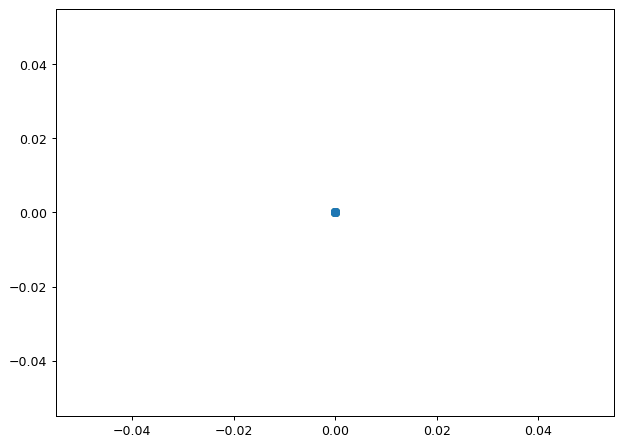

tensor(2.)


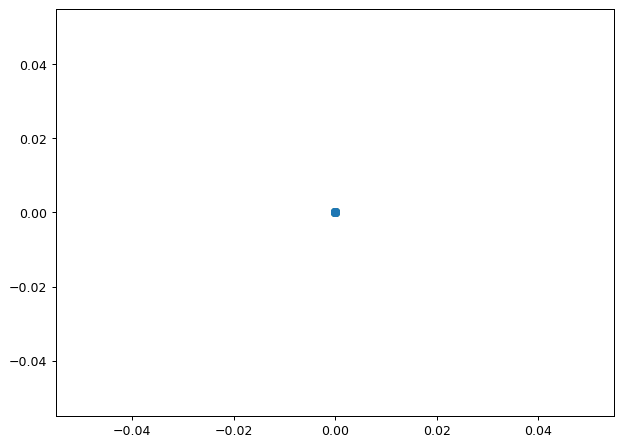

1 0 tensor(0.0053, device='cuda:0', grad_fn=<MseLossBackward>) 0.0013331555911032117


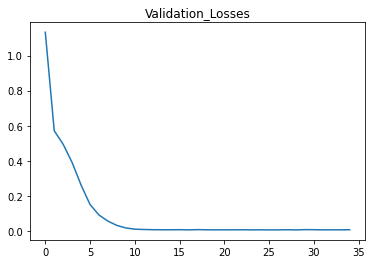

1 1 tensor(0.0055, device='cuda:0', grad_fn=<MseLossBackward>) 0.0013318247862683695
1 2 tensor(0.0052, device='cuda:0', grad_fn=<MseLossBackward>) 0.0013304979588680157
1 3 tensor(0.0055, device='cuda:0', grad_fn=<MseLossBackward>) 0.001329175089128991
1 4 tensor(0.0057, device='cuda:0', grad_fn=<MseLossBackward>) 0.0013278561574154829
1 5 tensor(0.0054, device='cuda:0', grad_fn=<MseLossBackward>) 0.0013265411442277988
1 6 tensor(0.0054, device='cuda:0', grad_fn=<MseLossBackward>) 0.0013252300302011577
1 7 tensor(0.0055, device='cuda:0', grad_fn=<MseLossBackward>) 0.001323922796104491
1 8 tensor(0.0054, device='cuda:0', grad_fn=<MseLossBackward>) 0.001322619422839258
1 9 tensor(0.0054, device='cuda:0', grad_fn=<MseLossBackward>) 0.0013213198914382746
1 10 tensor(0.0054, device='cuda:0', grad_fn=<MseLossBackward>) 0.0013200241830645526
1 11 tensor(0.0053, device='cuda:0', grad_fn=<MseLossBackward>) 0.0013187322790101548
1 12 tensor(0.0058, device='cuda:0', grad_fn=<MseLossBackward>) 0.

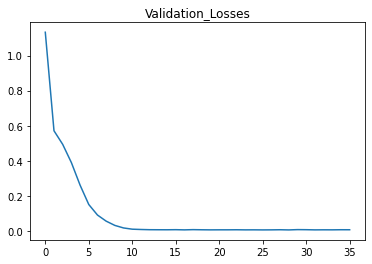

1 16 tensor(0.0053, device='cuda:0', grad_fn=<MseLossBackward>) 0.0013123291776417866
1 17 tensor(0.0055, device='cuda:0', grad_fn=<MseLossBackward>) 0.0013110597137220208
1 18 tensor(0.0054, device='cuda:0', grad_fn=<MseLossBackward>) 0.001309793926685633
1 19 tensor(0.0054, device='cuda:0', grad_fn=<MseLossBackward>) 0.001308531798817248
1 20 tensor(0.0056, device='cuda:0', grad_fn=<MseLossBackward>) 0.0013072733125207535
1 21 tensor(0.0055, device='cuda:0', grad_fn=<MseLossBackward>) 0.0013060184503182737
1 22 tensor(0.0055, device='cuda:0', grad_fn=<MseLossBackward>) 0.0013047671948491467
1 23 tensor(0.0056, device='cuda:0', grad_fn=<MseLossBackward>) 0.0013035195288689174
1 24 tensor(0.0055, device='cuda:0', grad_fn=<MseLossBackward>) 0.001302275435248339
1 25 tensor(0.0053, device='cuda:0', grad_fn=<MseLossBackward>) 0.0013010348969723846
1 26 tensor(0.0055, device='cuda:0', grad_fn=<MseLossBackward>) 0.0012997978971392707
1 27 tensor(0.0057, device='cuda:0', grad_fn=<MseLossBack

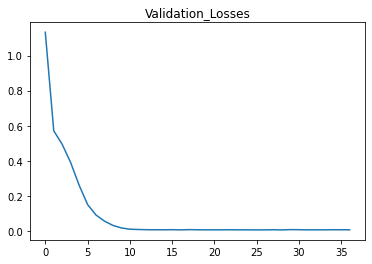

1 31 tensor(0.0055, device='cuda:0', grad_fn=<MseLossBackward>) 0.0012936653908598775
1 32 tensor(0.0055, device='cuda:0', grad_fn=<MseLossBackward>) 0.0012924492729673581
1 33 tensor(0.0056, device='cuda:0', grad_fn=<MseLossBackward>) 0.0012912365782960108
1 34 tensor(0.0056, device='cuda:0', grad_fn=<MseLossBackward>) 0.0012900272908160089
1 35 tensor(0.0054, device='cuda:0', grad_fn=<MseLossBackward>) 0.0012888213946024164
1 36 tensor(0.0054, device='cuda:0', grad_fn=<MseLossBackward>) 0.0012876188738343078
1 37 tensor(0.0060, device='cuda:0', grad_fn=<MseLossBackward>) 0.0012864197127938962
1 38 tensor(0.0053, device='cuda:0', grad_fn=<MseLossBackward>) 0.0012852238958656695
1 39 tensor(0.0057, device='cuda:0', grad_fn=<MseLossBackward>) 0.0012840314075355376
1 40 tensor(0.0054, device='cuda:0', grad_fn=<MseLossBackward>) 0.0012828422323899866
1 41 tensor(0.0054, device='cuda:0', grad_fn=<MseLossBackward>) 0.0012816563551152412
1 42 tensor(0.0054, device='cuda:0', grad_fn=<MseLossB

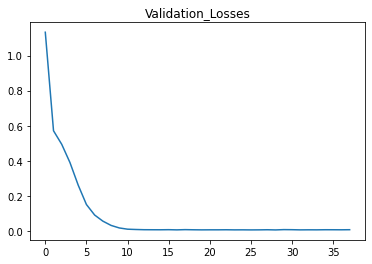

1 46 tensor(0.0054, device='cuda:0', grad_fn=<MseLossBackward>) 0.001275775907699572
1 47 tensor(0.0059, device='cuda:0', grad_fn=<MseLossBackward>) 0.0012746095015424776
1 48 tensor(0.0053, device='cuda:0', grad_fn=<MseLossBackward>) 0.0012734462887839357
1 49 tensor(0.0055, device='cuda:0', grad_fn=<MseLossBackward>) 0.0012722862548789607
1 50 tensor(0.0052, device='cuda:0', grad_fn=<MseLossBackward>) 0.0012711293853751452
1 51 tensor(0.0052, device='cuda:0', grad_fn=<MseLossBackward>) 0.001269975665911905
1 52 tensor(0.0051, device='cuda:0', grad_fn=<MseLossBackward>) 0.0012688250822197292
1 53 tensor(0.0053, device='cuda:0', grad_fn=<MseLossBackward>) 0.0012676776201194391
1 54 tensor(0.0052, device='cuda:0', grad_fn=<MseLossBackward>) 0.0012665332655214553
1 55 tensor(0.0052, device='cuda:0', grad_fn=<MseLossBackward>) 0.0012653920044250696
1 56 tensor(0.0053, device='cuda:0', grad_fn=<MseLossBackward>) 0.001264253822917727
1 57 tensor(0.0054, device='cuda:0', grad_fn=<MseLossBack

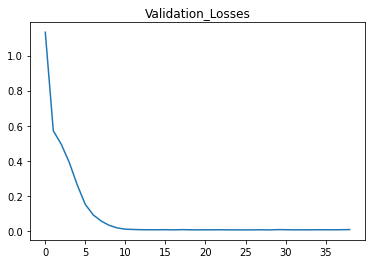

1 61 tensor(0.0053, device='cuda:0', grad_fn=<MseLossBackward>) 0.0012586086283587264
1 62 tensor(0.0050, device='cuda:0', grad_fn=<MseLossBackward>) 0.001257488637069642
1 63 tensor(0.0050, device='cuda:0', grad_fn=<MseLossBackward>) 0.001256371630391022
1 64 tensor(0.0050, device='cuda:0', grad_fn=<MseLossBackward>) 0.0012552575950904663
1 65 tensor(0.0054, device='cuda:0', grad_fn=<MseLossBackward>) 0.001254146518017563
1 66 tensor(0.0053, device='cuda:0', grad_fn=<MseLossBackward>) 0.001253038386103236
1 67 tensor(0.0053, device='cuda:0', grad_fn=<MseLossBackward>) 0.0012519331863590983
1 68 tensor(0.0052, device='cuda:0', grad_fn=<MseLossBackward>) 0.0012508309058768146
1 69 tensor(0.0052, device='cuda:0', grad_fn=<MseLossBackward>) 0.0012497315318274662
1 70 tensor(0.0051, device='cuda:0', grad_fn=<MseLossBackward>) 0.0012486350514609246
1 71 tensor(0.0053, device='cuda:0', grad_fn=<MseLossBackward>) 0.0012475414521052309
1 72 tensor(0.0054, device='cuda:0', grad_fn=<MseLossBackw

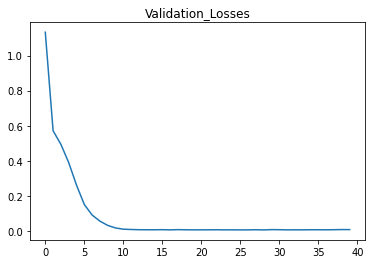

1 76 tensor(0.0052, device='cuda:0', grad_fn=<MseLossBackward>) 0.0012421162323657444
1 77 tensor(0.0052, device='cuda:0', grad_fn=<MseLossBackward>) 0.0012410396572647064
1 78 tensor(0.0055, device='cuda:0', grad_fn=<MseLossBackward>) 0.001239965876608607
1 79 tensor(0.0053, device='cuda:0', grad_fn=<MseLossBackward>) 0.0012388948783291847
1 80 tensor(0.0055, device='cuda:0', grad_fn=<MseLossBackward>) 0.0012378266504310188
1 81 tensor(0.0053, device='cuda:0', grad_fn=<MseLossBackward>) 0.001236761180990964
1 82 tensor(0.0052, device='cuda:0', grad_fn=<MseLossBackward>) 0.0012356984581575927
1 83 tensor(0.0050, device='cuda:0', grad_fn=<MseLossBackward>) 0.0012346384701506412
1 84 tensor(0.0049, device='cuda:0', grad_fn=<MseLossBackward>) 0.0012335812052604595
1 85 tensor(0.0052, device='cuda:0', grad_fn=<MseLossBackward>) 0.0012325266518474708
1 86 tensor(0.0050, device='cuda:0', grad_fn=<MseLossBackward>) 0.0012314747983416313
1 87 tensor(0.0051, device='cuda:0', grad_fn=<MseLossBac

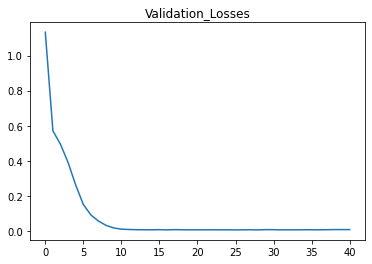

1 91 tensor(0.0052, device='cuda:0', grad_fn=<MseLossBackward>) 0.0012262556292687186
1 92 tensor(0.0051, device='cuda:0', grad_fn=<MseLossBackward>) 0.0012252197360621759
1 93 tensor(0.0052, device='cuda:0', grad_fn=<MseLossBackward>) 0.0012241864636752507
1 94 tensor(0.0050, device='cuda:0', grad_fn=<MseLossBackward>) 0.0012231558010753856
1 95 tensor(0.0052, device='cuda:0', grad_fn=<MseLossBackward>) 0.0012221277372949345
1 96 tensor(0.0051, device='cuda:0', grad_fn=<MseLossBackward>) 0.0012211022614306694
1 97 tensor(0.0052, device='cuda:0', grad_fn=<MseLossBackward>) 0.0012200793626432986
1 98 tensor(0.0050, device='cuda:0', grad_fn=<MseLossBackward>) 0.001219059030156982
1 99 tensor(0.0051, device='cuda:0', grad_fn=<MseLossBackward>) 0.0012180412532588566
tensor(2.0901)


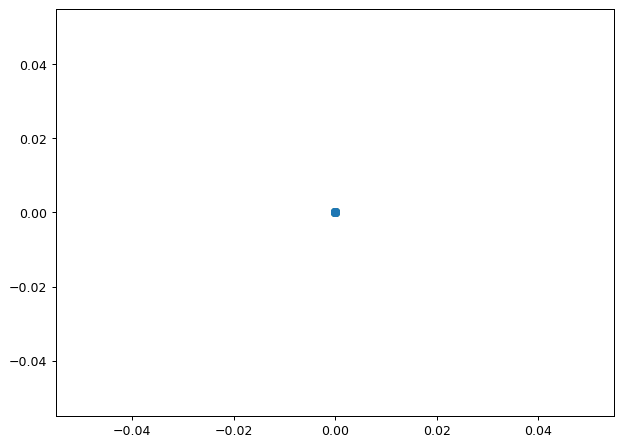

tensor(2.)


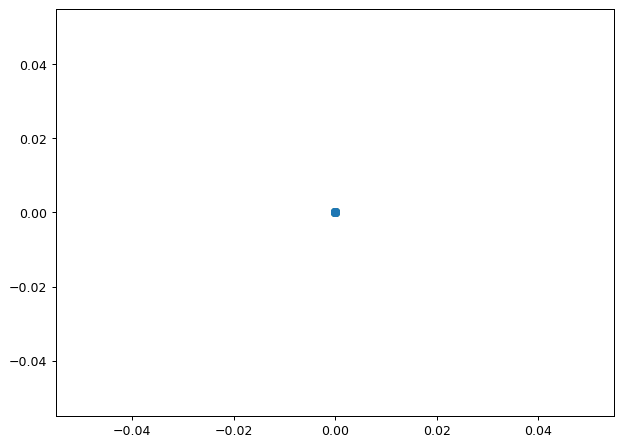

1 100 tensor(0.0051, device='cuda:0', grad_fn=<MseLossBackward>) 0.0012170260212985631
1 101 tensor(0.0052, device='cuda:0', grad_fn=<MseLossBackward>) 0.0012160133236877777
1 102 tensor(0.0052, device='cuda:0', grad_fn=<MseLossBackward>) 0.001215003149899749
1 103 tensor(0.0053, device='cuda:0', grad_fn=<MseLossBackward>) 0.001213995489468838
1 104 tensor(0.0055, device='cuda:0', grad_fn=<MseLossBackward>) 0.001212990331990062
1 105 tensor(0.0052, device='cuda:0', grad_fn=<MseLossBackward>) 0.0012119876671186451


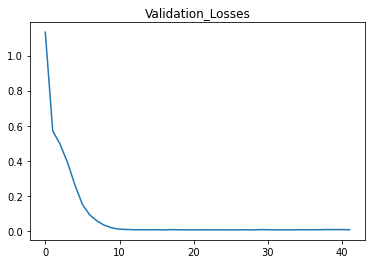

1 106 tensor(0.0049, device='cuda:0', grad_fn=<MseLossBackward>) 0.001210987484569569
1 107 tensor(0.0049, device='cuda:0', grad_fn=<MseLossBackward>) 0.001209989774117132
1 108 tensor(0.0049, device='cuda:0', grad_fn=<MseLossBackward>) 0.0012089945255945077
1 109 tensor(0.0049, device='cuda:0', grad_fn=<MseLossBackward>) 0.0012080017288933116
1 110 tensor(0.0053, device='cuda:0', grad_fn=<MseLossBackward>) 0.001207011373963169
1 111 tensor(0.0049, device='cuda:0', grad_fn=<MseLossBackward>) 0.001206023450811288
1 112 tensor(0.0051, device='cuda:0', grad_fn=<MseLossBackward>) 0.001205037949502036
1 113 tensor(0.0051, device='cuda:0', grad_fn=<MseLossBackward>) 0.0012040548601565198
1 114 tensor(0.0054, device='cuda:0', grad_fn=<MseLossBackward>) 0.0012030741729521699
1 115 tensor(0.0050, device='cuda:0', grad_fn=<MseLossBackward>) 0.0012020958781223286
1 116 tensor(0.0051, device='cuda:0', grad_fn=<MseLossBackward>) 0.0012011199659558405
1 117 tensor(0.0051, device='cuda:0', grad_fn=<M

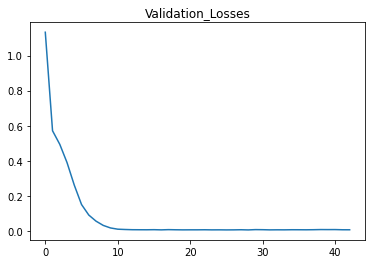

1 121 tensor(0.0051, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011962758090177618
1 122 tensor(0.0051, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011953139919547357
1 123 tensor(0.0051, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011943544910974983
1 124 tensor(0.0052, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011933972971646402
1 125 tensor(0.0050, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011924424009267377
1 126 tensor(0.0050, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011914897932059788
1 127 tensor(0.0049, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011905394648757928
1 128 tensor(0.0051, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011895914068604833
1 129 tensor(0.0052, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011886456101348637
1 130 tensor(0.0050, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011877020657238974
1 131 tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011867607647023384
1 132 tensor(0.0050, device='cuda:0', grad_

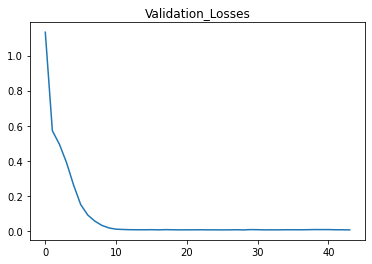

1 136 tensor(0.0053, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011820876014930438
1 137 tensor(0.0052, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011811595761218037
1 138 tensor(0.0051, device='cuda:0', grad_fn=<MseLossBackward>) 0.001180233733028013
1 139 tensor(0.0049, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011793100636722478
1 140 tensor(0.0053, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011783885595617926
1 141 tensor(0.0049, device='cuda:0', grad_fn=<MseLossBackward>) 0.001177469212250313
1 142 tensor(0.0048, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011765520133375292
1 143 tensor(0.0052, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011756369544688948
1 144 tensor(0.0052, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011747240273352773
1 145 tensor(0.0050, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011738132236726396
1 146 tensor(0.0050, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011729045352617277
1 147 tensor(0.0051, device='cuda:0', grad_fn

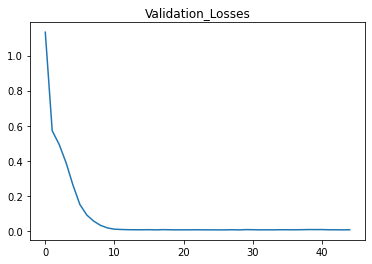

1 151 tensor(0.0051, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011683925374048874
1 152 tensor(0.0048, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011674963703688793
1 153 tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011666022622778837
1 154 tensor(0.0048, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011657102052599088
1 155 tensor(0.0048, device='cuda:0', grad_fn=<MseLossBackward>) 0.001164820191485034
1 156 tensor(0.0050, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011639322131651224
1 157 tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward>) 0.001163046262553533
1 158 tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward>) 0.001162162331944838
1 159 tensor(0.0048, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011612804136745412
1 160 tensor(0.0051, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011604005001187986
1 161 tensor(0.0050, device='cuda:0', grad_fn=<MseLossBackward>) 0.001159522583694141
1 162 tensor(0.0049, device='cuda:0', grad_fn=<

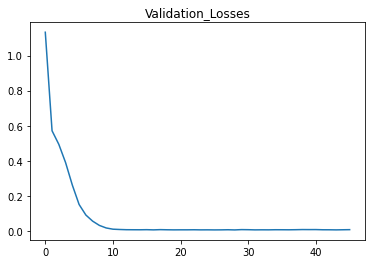

1 166 tensor(0.0051, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011551626959076138
1 167 tensor(0.0049, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011542966052433491
1 168 tensor(0.0049, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011534324597336273
1 169 tensor(0.0048, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011525702521082899
1 170 tensor(0.0048, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011517099751351635
1 171 tensor(0.0049, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011508516216198047
1 172 tensor(0.0053, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011499951844052478
1 173 tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011491406563717544
1 174 tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011482880304365633
1 175 tensor(0.0051, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011474372995536467
1 176 tensor(0.0051, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011465884567134624
1 177 tensor(0.0050, device='cuda:0', grad_

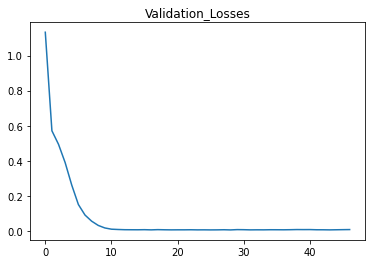

1 181 tensor(0.0051, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011423723203432914
1 182 tensor(0.0049, device='cuda:0', grad_fn=<MseLossBackward>) 0.001141534660572102
1 183 tensor(0.0048, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011406988407783676
1 184 tensor(0.0049, device='cuda:0', grad_fn=<MseLossBackward>) 0.001139864854235875
1 185 tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011390326942527845
1 186 tensor(0.0048, device='cuda:0', grad_fn=<MseLossBackward>) 0.001138202354171404
1 187 tensor(0.0049, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011373738273679664
1 188 tensor(0.0050, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011365471072524054
1 189 tensor(0.0051, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011357221872681379
1 190 tensor(0.0050, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011348990608918436
1 191 tensor(0.0049, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011340777216332506
1 192 tensor(0.0046, device='cuda:0', grad_fn=

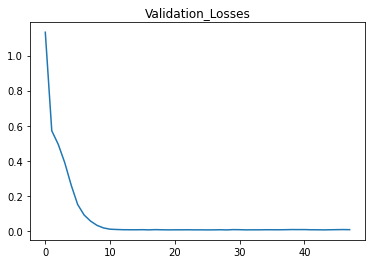

1 196 tensor(0.0050, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011299976072326
1 197 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>) 0.001129186856208247
1 198 tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011283778477771593
1 199 tensor(0.0049, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011275705757058446
tensor(2.0446)


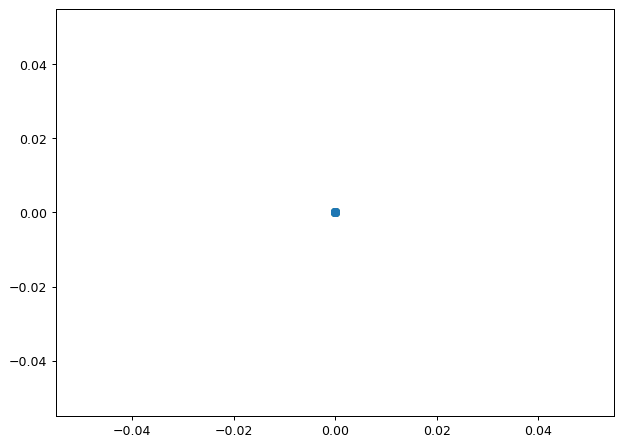

tensor(2.)


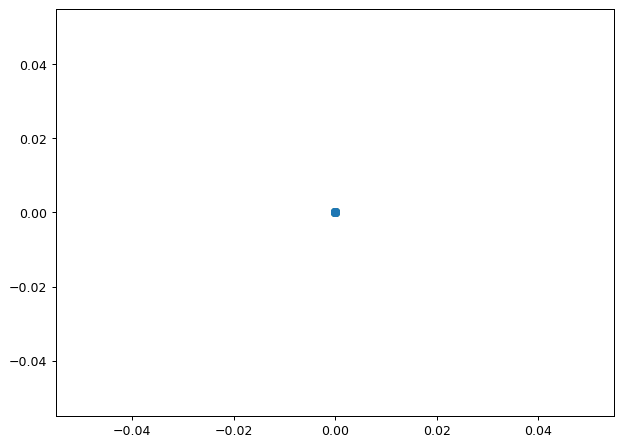

1 200 tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011267650337919819
1 201 tensor(0.0048, device='cuda:0', grad_fn=<MseLossBackward>) 0.001125961215864223
1 202 tensor(0.0048, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011251591157819944
1 203 tensor(0.0051, device='cuda:0', grad_fn=<MseLossBackward>) 0.001124358727435299
1 204 tensor(0.0049, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011235600447445212
1 205 tensor(0.0052, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011227630616602326
1 206 tensor(0.0050, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011219677721630006
1 207 tensor(0.0053, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011211741702631959
1 208 tensor(0.0050, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011203822500008042
1 209 tensor(0.0052, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011195920054452378
1 210 tensor(0.0049, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011188034306951493


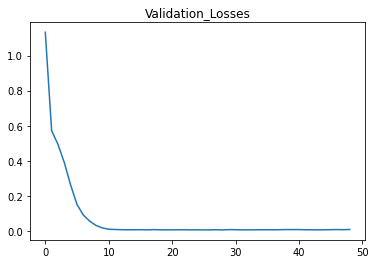

1 211 tensor(0.0049, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011180165198782462
1 212 tensor(0.0049, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011172312671511072
1 213 tensor(0.0049, device='cuda:0', grad_fn=<MseLossBackward>) 0.001116447666699
1 214 tensor(0.0050, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011156657127357012
1 215 tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011148853995033155
1 216 tensor(0.0050, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011141067212720986
1 217 tensor(0.0049, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011133296723402802
1 218 tensor(0.0050, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011125542470338885
1 219 tensor(0.0050, device='cuda:0', grad_fn=<MseLossBackward>) 0.001111780439706577
1 220 tensor(0.0051, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011110082447394504
1 221 tensor(0.0049, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011102376565408946
1 222 tensor(0.0048, device='cuda:0', grad_fn=<M

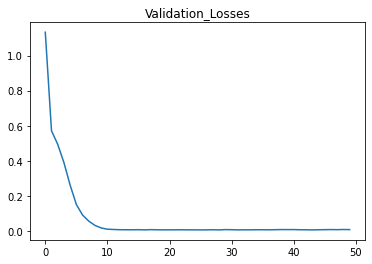

1 226 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011064086232584964
1 227 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011056475597539118
1 228 tensor(0.0050, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011048880646263312
1 229 tensor(0.0051, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011041301324963705
1 230 tensor(0.0046, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011033737580104406
1 231 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011026189358405898
1 232 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011018656606843458
1 233 tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011011139272645587
1 234 tensor(0.0050, device='cuda:0', grad_fn=<MseLossBackward>) 0.0011003637303292466
1 235 tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010996150646514404
1 236 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>) 0.001098867925029032
1 237 tensor(0.0046, device='cuda:0', grad_f

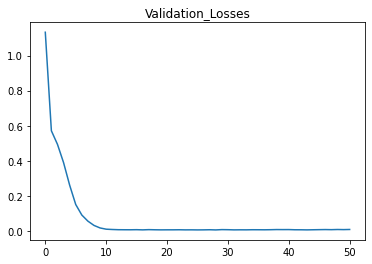

1 241 tensor(0.0048, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010951549373953632
1 242 tensor(0.0048, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010944168462342654
1 243 tensor(0.0050, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010936802453972887
1 244 tensor(0.0050, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010929451298758368
1 245 tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010922114946848472
1 246 tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010914793348626502
1 247 tensor(0.0049, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010907486454708264
1 248 tensor(0.0049, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010900194215940678
1 249 tensor(0.0050, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010892916583400388
1 250 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010885653508392384
1 251 tensor(0.0048, device='cuda:0', grad_fn=<MseLossBackward>) 0.001087840494244863
1 252 tensor(0.0048, device='cuda:0', grad_f

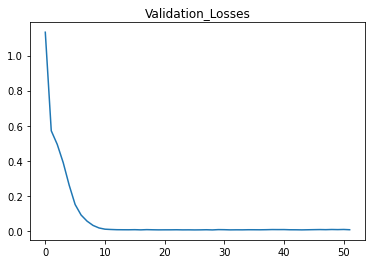

1 256 tensor(0.0046, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010842378068030335
1 257 tensor(0.0046, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010835215551184068
1 258 tensor(0.0048, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010828067210368261
1 259 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>) 0.001082093299888261
1 260 tensor(0.0048, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010813812870241906
1 261 tensor(0.0044, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010806706778174768
1 262 tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010799614676622383
1 263 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>) 0.001079253651973725
1 264 tensor(0.0048, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010785472261881932
1 265 tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010778421857627822
1 266 tensor(0.0046, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010771385261753922
1 267 tensor(0.0046, device='cuda:0', grad_fn

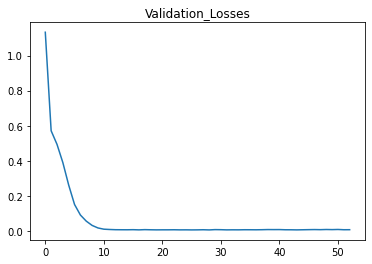

1 271 tensor(0.0048, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010736407839731946
1 272 tensor(0.0046, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010729453155971652
1 273 tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010722511969756216
1 274 tensor(0.0049, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010715584237482336
1 275 tensor(0.0049, device='cuda:0', grad_fn=<MseLossBackward>) 0.001070866991574365
1 276 tensor(0.0050, device='cuda:0', grad_fn=<MseLossBackward>) 0.001070176896132961
1 277 tensor(0.0048, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010694881331224338
1 278 tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010688006982605498
1 279 tensor(0.0048, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010681145872843186
1 280 tensor(0.0046, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010674297959498808
1 281 tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward>) 0.001066746320032399
1 282 tensor(0.0047, device='cuda:0', grad_fn=

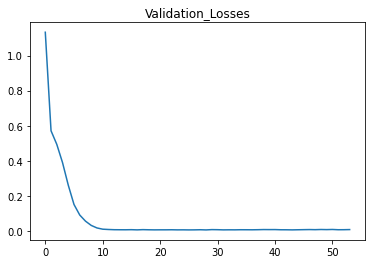

1 286 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010633485251477835
1 287 tensor(0.0049, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010626728540619498
1 288 tensor(0.0044, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010619984693427092
1 289 tensor(0.0048, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010613253669135177
1 290 tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010606535427158952
1 291 tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010599829927093218
1 292 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010593137128711368
1 293 tensor(0.0051, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010586456991964358
1 294 tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward>) 0.001057978947697971
1 295 tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward>) 0.001057313454406052
1 296 tensor(0.0048, device='cuda:0', grad_fn=<MseLossBackward>) 0.001056649215368444
1 297 tensor(0.0046, device='cuda:0', grad_fn=

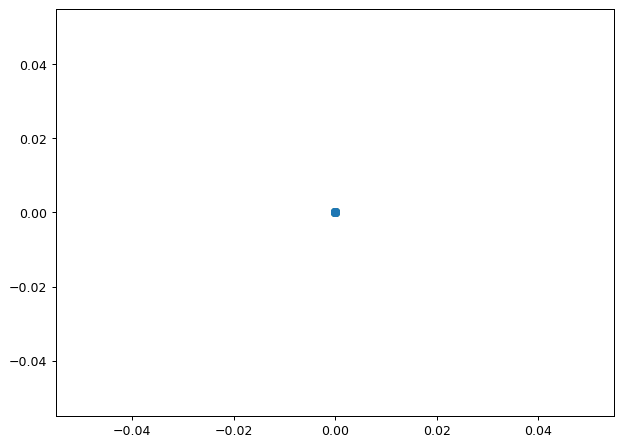

tensor(2.)


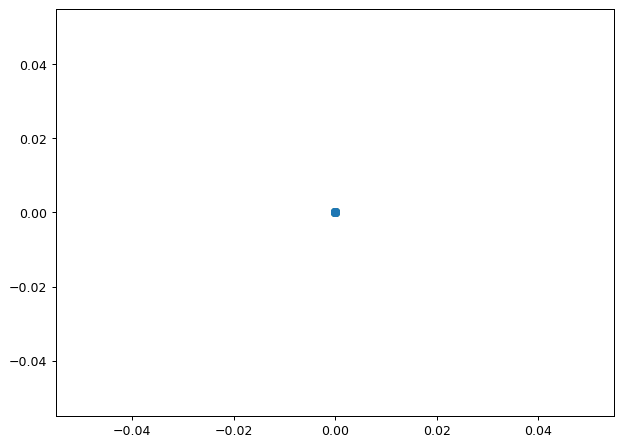

1 300 tensor(0.0048, device='cuda:0', grad_fn=<MseLossBackward>) 0.00105400472332195


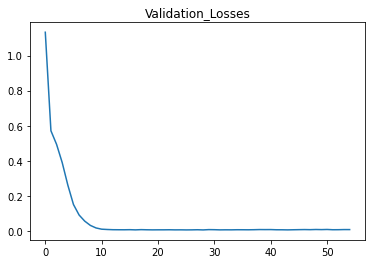

1 301 tensor(0.0049, device='cuda:0', grad_fn=<MseLossBackward>) 0.001053346696876531
1 302 tensor(0.0050, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010526899013331486
1 303 tensor(0.0044, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010520343328590473
1 304 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>) 0.001051379987638158
1 305 tensor(0.0046, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010507268618710065
1 306 tensor(0.0048, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010500749517746199
1 307 tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010494242535824337
1 308 tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010487747635442026
1 309 tensor(0.0046, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010481264779259073
1 310 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010474793930096663
1 311 tensor(0.0044, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010468335050936451
1 312 tensor(0.0045, device='cuda:0', grad_fn

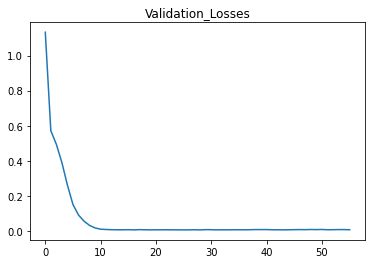

1 316 tensor(0.0049, device='cuda:0', grad_fn=<MseLossBackward>) 0.001043621892064797
1 317 tensor(0.0049, device='cuda:0', grad_fn=<MseLossBackward>) 0.001042983109299097
1 318 tensor(0.0048, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010423454980627081
1 319 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>) 0.001041709054779023
1 320 tensor(0.0044, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010410737758867028
1 321 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>) 0.001040439657839593
1 322 tensor(0.0046, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010398066971066407
1 323 tensor(0.0046, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010391748901718118
1 324 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010385442335340085
1 325 tensor(0.0046, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010379147237069885
1 326 tensor(0.0049, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010372863572192838
1 327 tensor(0.0050, device='cuda:0', grad_fn=<

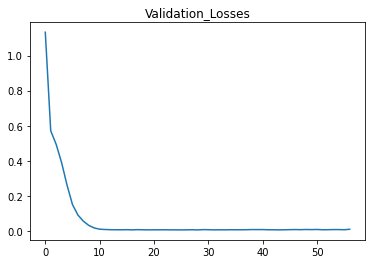

1 331 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>) 0.001034161554393225
1 332 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>) 0.001033539975857881
1 333 tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward>) 0.00103291951676857
1 334 tensor(0.0044, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010323001737691673
1 335 tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010316819435176197
1 336 tensor(0.0048, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010310648226858662
1 337 tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010304488079597655
1 338 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010298338960390188
1 339 tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010292200836370983
1 340 tensor(0.0046, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010286073674811709
1 341 tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010279957443120266
1 342 tensor(0.0052, device='cuda:0', grad_fn=<

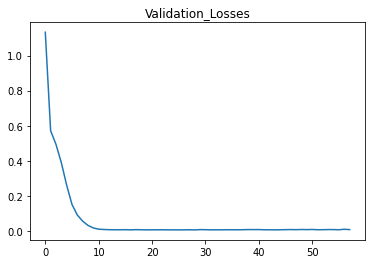

1 346 tensor(0.0044, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010249539101401318
1 347 tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward>) 0.001024348777202015
1 348 tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010237447148115824
1 349 tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010231417198160212
1 350 tensor(0.0049, device='cuda:0', grad_fn=<MseLossBackward>) 0.001022539789075504
1 351 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>) 0.001021938919463117
1 352 tensor(0.0044, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010213391078647948
1 353 tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010207403511792506
1 354 tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010201426463179095
1 355 tensor(0.0051, device='cuda:0', grad_fn=<MseLossBackward>) 0.001019545990204842
1 356 tensor(0.0049, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010189503797766969
1 357 tensor(0.0048, device='cuda:0', grad_fn=<

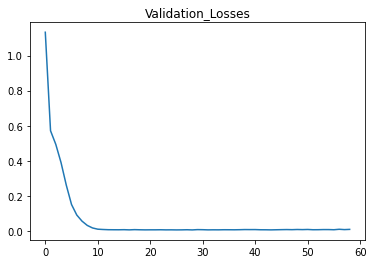

1 361 tensor(0.0046, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010159879065647253
1 362 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010153985066118677
1 363 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010148101312471773
1 364 tensor(0.0049, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010142227775055885
1 365 tensor(0.0044, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010136364424340343
1 366 tensor(0.0046, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010130511230913848
1 367 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>) 0.001012466816548384
1 368 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010118835198875903
1 369 tensor(0.0044, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010113012302033126
1 370 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>) 0.001010719944601552
1 371 tensor(0.0053, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010101396601999394
1 372 tensor(0.0047, device='cuda:0', grad_fn

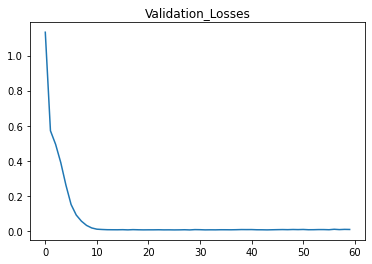

1 376 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010072531561178195
1 377 tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010066788190311604
1 378 tensor(0.0051, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010061054632887344
1 379 tensor(0.0048, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010055330860990893
1 380 tensor(0.0051, device='cuda:0', grad_fn=<MseLossBackward>) 0.001004961684681876
1 381 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010043912562677935
1 382 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010038217980985306
1 383 tensor(0.0054, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010032533074267114
1 384 tensor(0.0044, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010026857815158391
1 385 tensor(0.0046, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010021192176402403
1 386 tensor(0.0046, device='cuda:0', grad_fn=<MseLossBackward>) 0.0010015536130850106
1 387 tensor(0.0055, device='cuda:0', grad_f

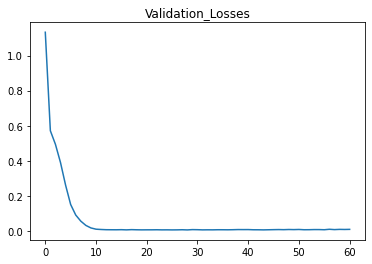

1 391 tensor(0.0044, device='cuda:0', grad_fn=<MseLossBackward>) 0.000998739885839698
1 392 tensor(0.0044, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009981799807898966
1 393 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009976210163531107
1 394 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009970629898986467
1 395 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009965058988061
1 396 tensor(0.0046, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009959497404653042
1 397 tensor(0.0048, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009953945122762775
1 398 tensor(0.0044, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009948402116491735
1 399 tensor(0.0044, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009942868360042307
tensor(2.0696)


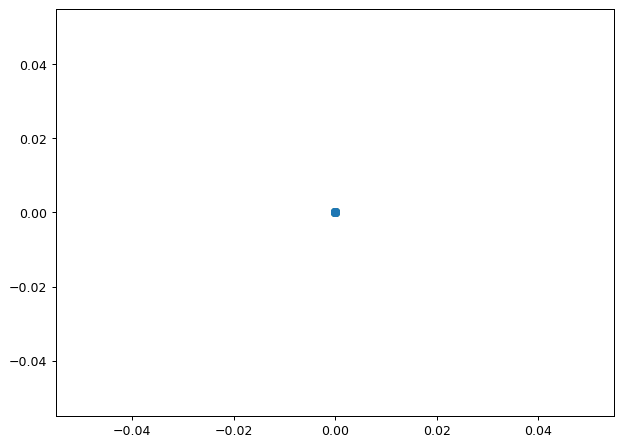

tensor(2.)


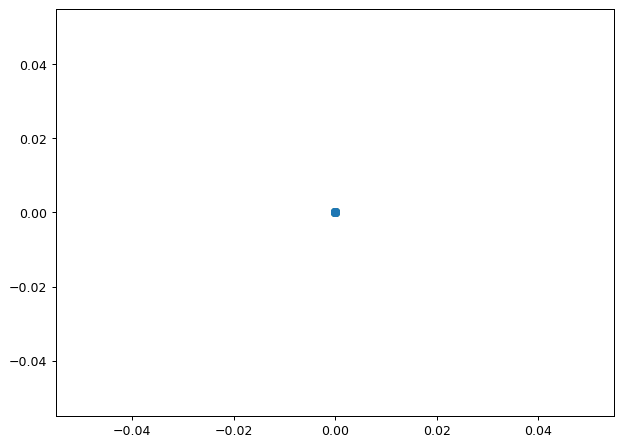

1 400 tensor(0.0044, device='cuda:0', grad_fn=<MseLossBackward>) 0.00099373438277172
1 401 tensor(0.0048, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009931828493918965
1 402 tensor(0.0049, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009926322333149494
1 403 tensor(0.0049, device='cuda:0', grad_fn=<MseLossBackward>) 0.000992082532000952
1 404 tensor(0.0048, device='cuda:0', grad_fn=<MseLossBackward>) 0.000991533742919812
1 405 tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009909858635512242


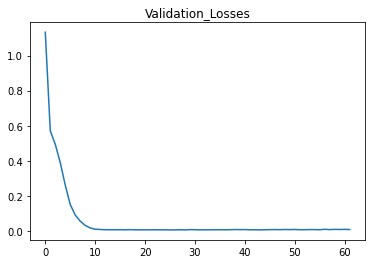

1 406 tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009904388913846206
1 407 tensor(0.0044, device='cuda:0', grad_fn=<MseLossBackward>) 0.000989892823919122
1 408 tensor(0.0049, device='cuda:0', grad_fn=<MseLossBackward>) 0.000989347658663491
1 409 tensor(0.0049, device='cuda:0', grad_fn=<MseLossBackward>) 0.000988803393136083
1 410 tensor(0.0048, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009882600248648005
1 411 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009877175513870434
1 412 tensor(0.0044, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009871759702496645
1 413 tensor(0.0044, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009866352790089221
1 414 tensor(0.0046, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009860954752304331
1 415 tensor(0.0046, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009855565564891276
1 416 tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward>) 0.000985018520369203
1 417 tensor(0.0046, device='cuda:0', grad_fn=<

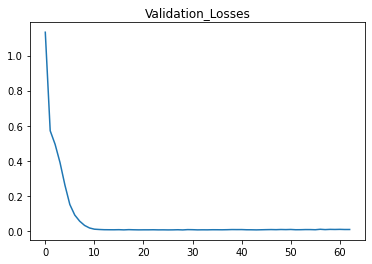

1 421 tensor(0.0046, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009823414951802044
1 422 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009818087045699814
1 423 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009812767799262186
1 424 tensor(0.0044, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009807457189056365
1 425 tensor(0.0050, device='cuda:0', grad_fn=<MseLossBackward>) 0.000980215519173824
1 426 tensor(0.0051, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009796861784051934
1 427 tensor(0.0050, device='cuda:0', grad_fn=<MseLossBackward>) 0.00097915769428294
1 428 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009786300644989972
1 429 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.000978103286753995
1 430 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.000977577358757219
1 431 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009770522782265663
1 432 tensor(0.0044, device='cuda:0', grad_fn=<M

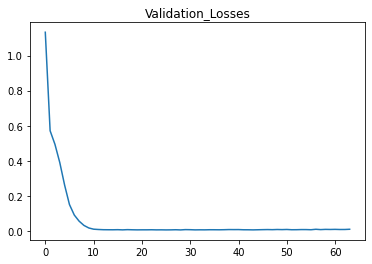

1 436 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009744395082892562
1 437 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009739194651083057
1 438 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009734002536564583
1 439 tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009728818717190377
1 440 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.000972364317089614
1 441 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009718475875699653
1 442 tensor(0.0044, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009713316809700386
1 443 tensor(0.0046, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009708165951079096
1 444 tensor(0.0049, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009703023278097453
1 445 tensor(0.0050, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009697888769097648
1 446 tensor(0.0048, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009692762402502015
1 447 tensor(0.0047, device='cuda:0', grad_f

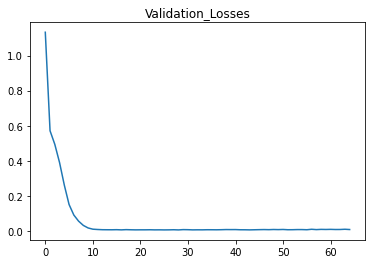

1 451 tensor(0.0046, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009667251955929895
1 452 tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009662173995068303
1 453 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009657104027779378
1 454 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009652042033113034
1 455 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009646987990195982
1 456 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009641941878231353
1 457 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009636903676498354
1 458 tensor(0.0052, device='cuda:0', grad_fn=<MseLossBackward>) 0.00096318733643519
1 459 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009626850921222262
1 460 tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009621836326614716
1 461 tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009616829560109187
1 462 tensor(0.0043, device='cuda:0', grad_fn

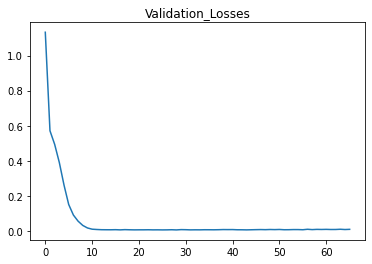

1 466 tensor(0.0046, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009591912439591018
1 467 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009586952217012793
1 468 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.000958199968165723
1 469 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009577054813689063
1 470 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009572117593344605
1 471 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009567188000931412
1 472 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009562266016827967
1 473 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009557351621483333
1 474 tensor(0.0046, device='cuda:0', grad_fn=<MseLossBackward>) 0.000955244479541684
1 475 tensor(0.0048, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009547545519217756
1 476 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009542653773544969
1 477 tensor(0.0044, device='cuda:0', grad_fn

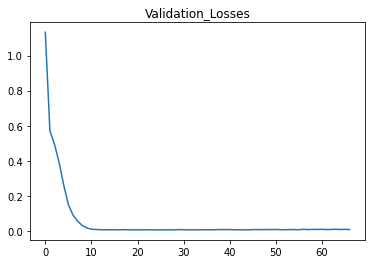

1 481 tensor(0.0046, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009518307330969351
1 482 tensor(0.0044, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009513460366149273
1 483 tensor(0.0044, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009508620798390236
1 484 tensor(0.0046, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009503788608896666
1 485 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009498963778939779
1 486 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009494146289857279
1 487 tensor(0.0046, device='cuda:0', grad_fn=<MseLossBackward>) 0.000948933612305306
1 488 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.00094845332599969
1 489 tensor(0.0051, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009479737682224157
1 490 tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009474949371335484
1 491 tensor(0.0046, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009470168308996518
1 492 tensor(0.0048, device='cuda:0', grad_fn=

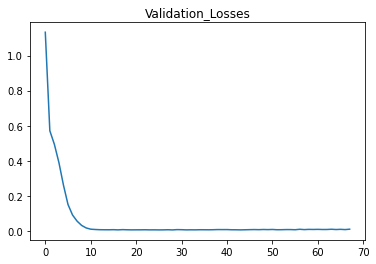

1 496 tensor(0.0044, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009446371088356955
1 497 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009441633135897153
1 498 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009436902305441695
1 499 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009432178579165663
tensor(2.0337)


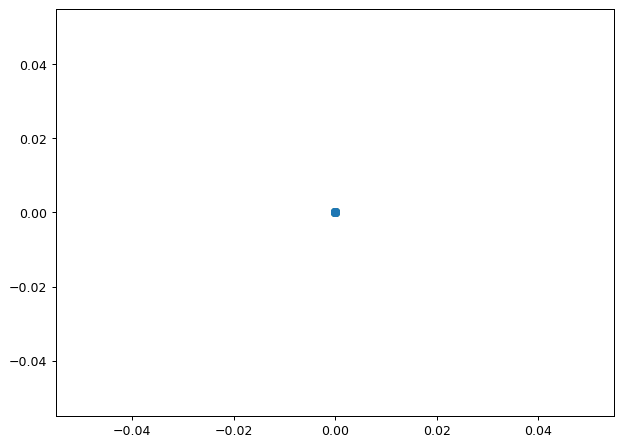

tensor(2.)


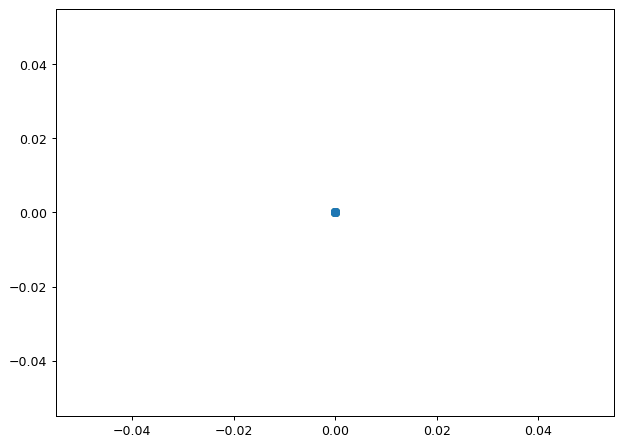

1 500 tensor(0.0046, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009427461939306532
1 501 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009422752368163892
1 502 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009418049848099172
1 503 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.000941335436153535
1 504 tensor(0.0046, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009408665890956694
1 505 tensor(0.0046, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009403984418908474
1 506 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009399309927996699
1 507 tensor(0.0051, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009394642400887836
1 508 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009389981820308545
1 509 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009385328169045415
1 510 tensor(0.0046, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009380681429944687


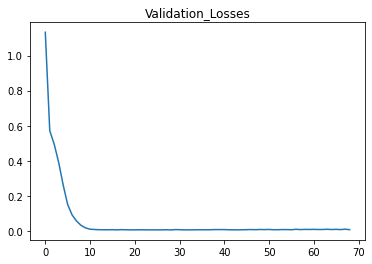

1 511 tensor(0.0046, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009376041585911998
1 512 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>) 0.000937140861991211
1 513 tensor(0.0046, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009366782514968653
1 514 tensor(0.0054, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009362163254163854
1 515 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009357550820638292
1 516 tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009352945197590624
1 517 tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009348346368277345
1 518 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009343754316012511
1 519 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009339169024167506
1 520 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009334590476170775
1 521 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009330018655507578
1 522 tensor(0.0046, device='cuda:0', grad_f

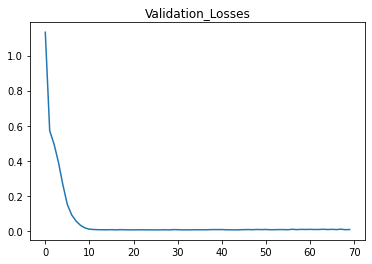

1 526 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009307259888124249
1 527 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009302728087802935
1 528 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009298202900781918
1 529 tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009293684310992073
1 530 tensor(0.0046, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009289172302418888
1 531 tensor(0.0044, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009284666859102221
1 532 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009280167965136064
1 533 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009275675604668313
1 534 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009271189761900517
1 535 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009266710421087668
1 536 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009262237566537948
1 537 tensor(0.0040, device='cuda:0', grad_

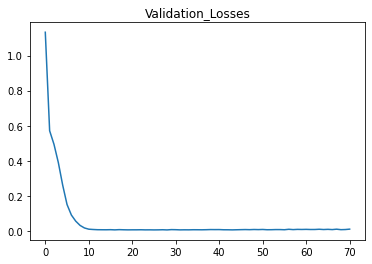

1 541 tensor(0.0048, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009239970042217693
1 542 tensor(0.0044, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009235535778668826
1 543 tensor(0.0044, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009231107893010703
1 544 tensor(0.0044, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009226686369968891
1 545 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009222271194320118
1 546 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009217862350892055
1 547 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009213459824563099
1 548 tensor(0.0046, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009209063600262159
1 549 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009204673662968423
1 550 tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009200289997711163
1 551 tensor(0.0044, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009195912589569514
1 552 tensor(0.0047, device='cuda:0', grad_

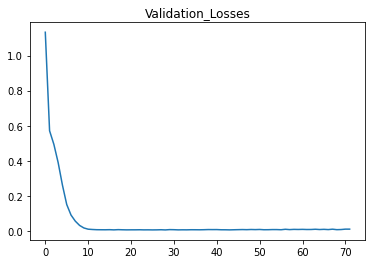

1 556 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009174118886828382
1 557 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009169778710807564
1 558 tensor(0.0046, device='cuda:0', grad_fn=<MseLossBackward>) 0.000916544468883458
1 559 tensor(0.0046, device='cuda:0', grad_fn=<MseLossBackward>) 0.000916111680637986
1 560 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009156795048961813
1 561 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009152479402146621
1 562 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009148169851548048
1 563 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>) 0.000914386638282722
1 564 tensor(0.0044, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009139568981692448
1 565 tensor(0.0046, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009135277633899006
1 566 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009130992325248947
1 567 tensor(0.0047, device='cuda:0', grad_fn=

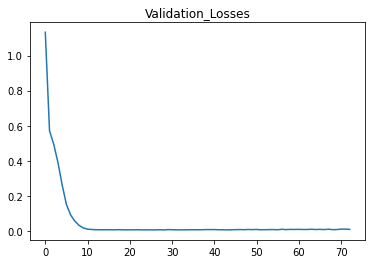

1 571 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009109655875470738
1 572 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009105406506118756
1 573 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009101163077817778
1 574 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009096925576737038
1 575 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009092693989090803
1 576 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009088468301138195
1 577 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009084248499182984
1 578 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009080034569573421
1 579 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.000907582649870204
1 580 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009071624273005482
1 581 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009067427878964305
1 582 tensor(0.0041, device='cuda:0', grad_f

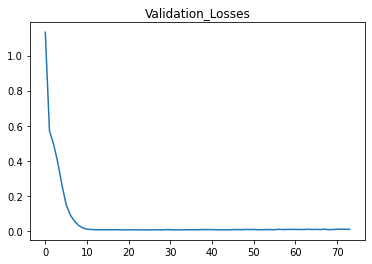

1 586 tensor(0.0046, device='cuda:0', grad_fn=<MseLossBackward>) 0.000904653291346011
1 587 tensor(0.0046, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009042371227879535
1 588 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009038215280532769
1 589 tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009034065058245225
1 590 tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009029920547884624
1 591 tensor(0.0046, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009025781736360823
1 592 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009021648610625639
1 593 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.000901752115767268
1 594 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009013399364537159
1 595 tensor(0.0044, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009009283218295746
1 596 tensor(0.0046, device='cuda:0', grad_fn=<MseLossBackward>) 0.0009005172706066375
1 597 tensor(0.0044, device='cuda:0', grad_fn

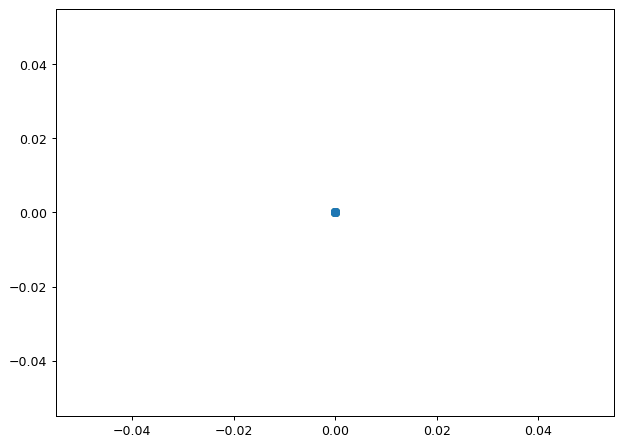

tensor(2.)


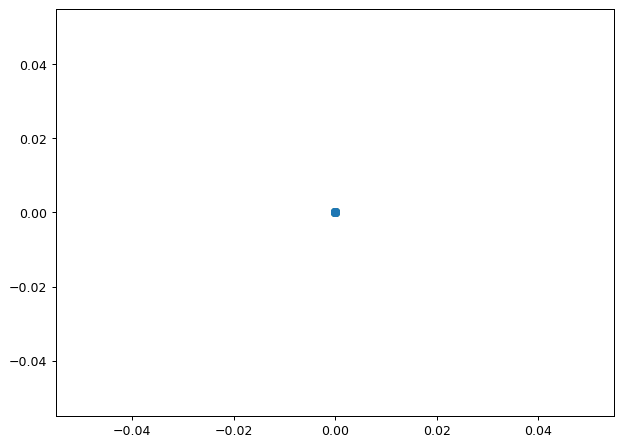

1 600 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008988786741063222


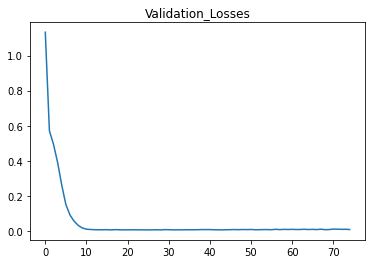

1 601 tensor(0.0044, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008984704207095929
1 602 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008980627230705641
1 603 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008976555799294524
1 604 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008972489900304681
1 605 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008968429521218001
1 606 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008964374649555989
1 607 tensor(0.0044, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008960325272879605
1 608 tensor(0.0046, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008956281378789112
1 609 tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008952242954923905
1 610 tensor(0.0044, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008948209988962361
1 611 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008944182468621677
1 612 tensor(0.0042, device='cuda:0', grad_

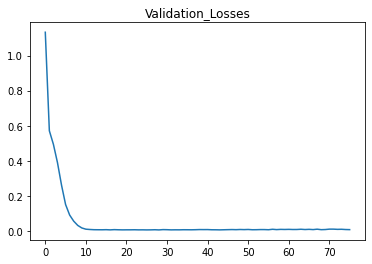

1 616 tensor(0.0048, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008924126124030812
1 617 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008920131021630715
1 618 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008916141279945749
1 619 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008912156886998089
1 620 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008908177830847343
1 621 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008904204099590406
1 622 tensor(0.0044, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008900235681361305
1 623 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008896272564331054
1 624 tensor(0.0046, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008892314736707505
1 625 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008888362186735202
1 626 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.000888441490269523
1 627 tensor(0.0044, device='cuda:0', grad_f

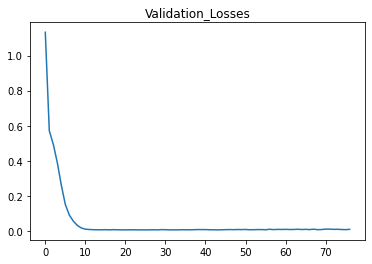

1 631 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008864757063858094
1 632 tensor(0.0046, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008860841131343077
1 633 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008856930383739054
1 634 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008853024809614267
1 635 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008849124397572216
1 636 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008845229136251513
1 637 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008841339014325753
1 638 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008837454020503364
1 639 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.000883357414352748
1 640 tensor(0.0044, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008829699372175793
1 641 tensor(0.0044, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008825829695260429
1 642 tensor(0.0044, device='cuda:0', grad_f

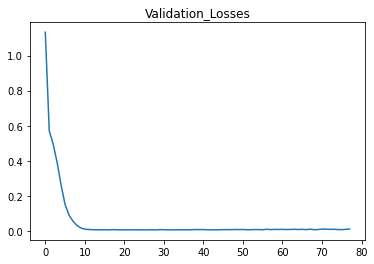

1 646 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008806557338045669
1 647 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008802717994713774
1 648 tensor(0.0046, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008798883668455727
1 649 tensor(0.0048, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008795054348354245
1 650 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008791230023525275
1 651 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008787410683117857
1 652 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008783596316314014
1 653 tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008779786912328601
1 654 tensor(0.0044, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008775982460409189
1 655 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008772182949835938
1 656 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008768388369921466
1 657 tensor(0.0042, device='cuda:0', grad_

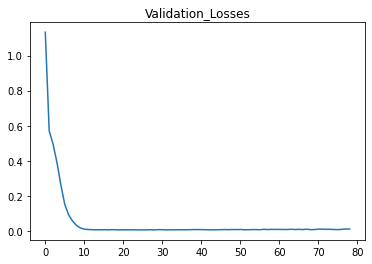

1 661 tensor(0.0044, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008749489058428722
1 662 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008745723839833801
1 663 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.000874196347798432
1 664 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008738207962448079
1 665 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008734457282824223
1 666 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008730711428743116
1 667 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.000872697038986623
1 668 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008723234155886019
1 669 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008719502716525798
1 670 tensor(0.0044, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008715776061539633
1 671 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008712054180712211
1 672 tensor(0.0042, device='cuda:0', grad_fn

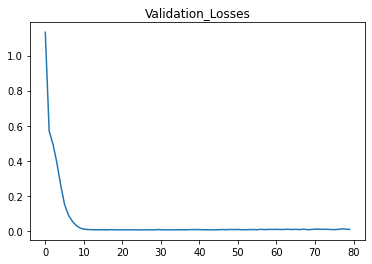

1 676 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008693516033549538
1 677 tensor(0.0046, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008689822584853437
1 678 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.000868613383965666
1 679 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008682449787984724
1 680 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008678770419892736
1 681 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.000867509572546528
1 682 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.00086714256948163
1 683 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008667760318088996
1 684 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008664099585455703
1 685 tensor(0.0048, device='cuda:0', grad_fn=<MseLossBackward>) 0.000866044348711779
1 686 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008656792013305546
1 687 tensor(0.0047, device='cuda:0', grad_fn=<M

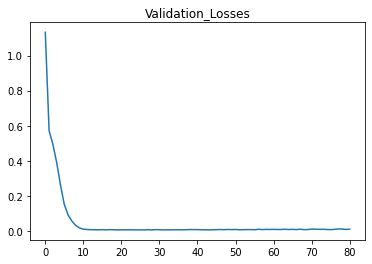

1 691 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008638603672199976
1 692 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008634979741983507
1 693 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008631360368705317
1 694 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008627745542823145
1 695 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008624135254822676
1 696 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.000862052949521745
1 697 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.000861692825454874
1 698 tensor(0.0044, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008613331523385459
1 699 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008609739292324054
tensor(2.0432)


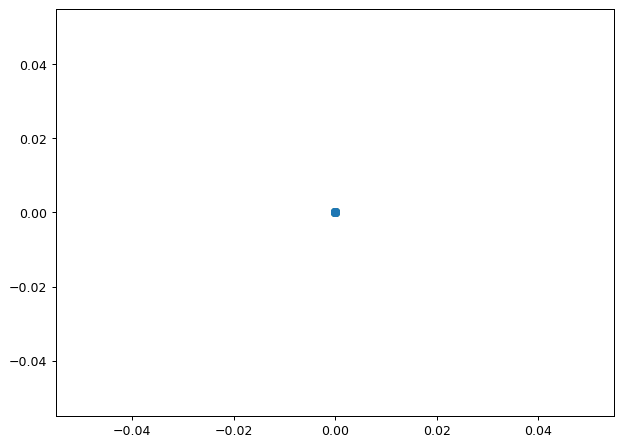

tensor(2.)


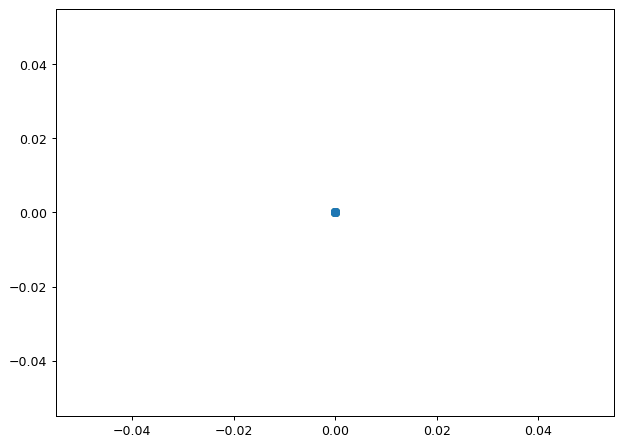

1 700 tensor(0.0044, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008606151551988398
1 701 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008602568293029695
1 702 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008598989506126371
1 703 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008595415181983976
1 704 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.000859184531133508
1 705 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008588279884939175


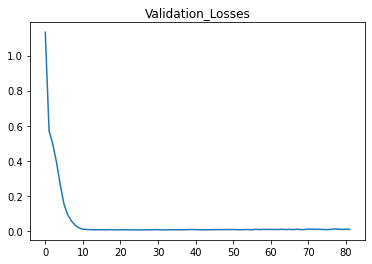

1 706 tensor(0.0046, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008584718893582573
1 707 tensor(0.0046, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008581162328078303
1 708 tensor(0.0044, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008577610179266019
1 709 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008574062438011893
1 710 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008570519095208522
1 711 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008566980141774827
1 712 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008563445568655952
1 713 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008559915366823175
1 714 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008556389527273807
1 715 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008552868041031091
1 716 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008549350899144113
1 717 tensor(0.0041, device='cuda:0', grad_

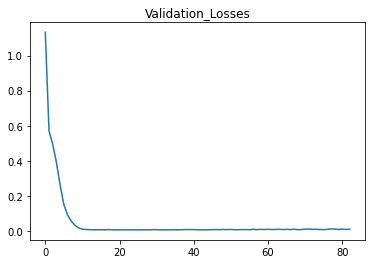

1 721 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008531830043560108
1 722 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008528338781273421
1 723 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008524851801401625
1 724 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008521369095197121
1 725 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008517890653937309
1 726 tensor(0.0044, device='cuda:0', grad_fn=<MseLossBackward>) 0.000851441646892449
1 727 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008510946531485779
1 728 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008507480832973012
1 729 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008504019364762655
1 730 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008500562118255719
1 731 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.000849710908487766
1 732 tensor(0.0042, device='cuda:0', grad_fn

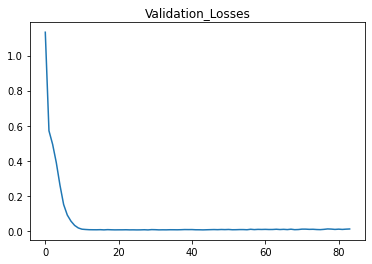

1 736 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008479906816511958
1 737 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008476478883199867
1 738 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008473055103672044
1 739 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008469635469546377
1 740 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008466219972464412
1 741 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008462808604091273
1 742 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008459401356115574
1 743 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008455998220249329
1 744 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.000845259918822788
1 745 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008449204251809802
1 746 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.000844581340277682
1 747 tensor(0.0043, device='cuda:0', grad_fn

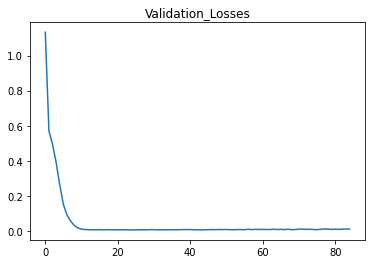

1 751 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008428920182358967
1 752 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008425553686338876
1 753 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008422191220817261
1 754 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.000841883277775809
1 755 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008415478349147743
1 756 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008412127926994934
1 757 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.000840878150333063
1 758 tensor(0.0046, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008405439070207972
1 759 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008402100619702194
1 760 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008398766143910548
1 761 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008395435634952217
1 762 tensor(0.0041, device='cuda:0', grad_fn

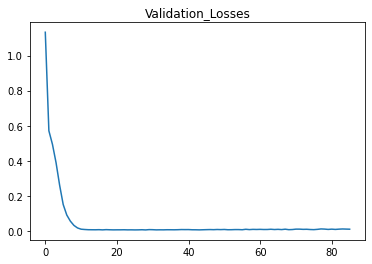

1 766 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008378842318357591
1 767 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008375535446120724
1 768 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008372232486159178
1 769 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008368933430764848
1 770 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.000836563827225087
1 771 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008362347002951549
1 772 tensor(0.0046, device='cuda:0', grad_fn=<MseLossBackward>) 0.000835905961522229
1 773 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008355776101439514
1 774 tensor(0.0044, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008352496454000586
1 775 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008349220665323748
1 776 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008345948727848033
1 777 tensor(0.0040, device='cuda:0', grad_fn

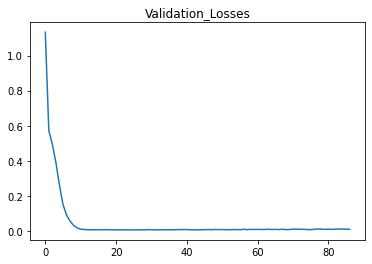

1 781 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008329646545299337
1 782 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008326397557405673
1 783 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008323152368362631
1 784 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008319910970773023
1 785 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008316673357259809
1 786 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008313439520466031
1 787 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008310209453054737
1 788 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008306983147708915
1 789 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008303760597131424
1 790 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008300541794044922
1 791 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.00082973267311918
1 792 tensor(0.0040, device='cuda:0', grad_fn

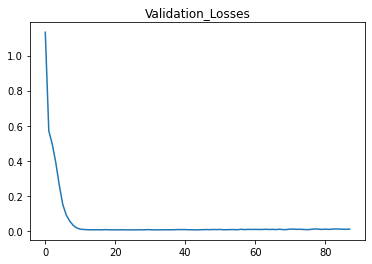

1 796 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008281307267783061
1 797 tensor(0.0048, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008278114495016719
1 798 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008274925412227221
1 799 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008271740012312357
tensor(2.0653)


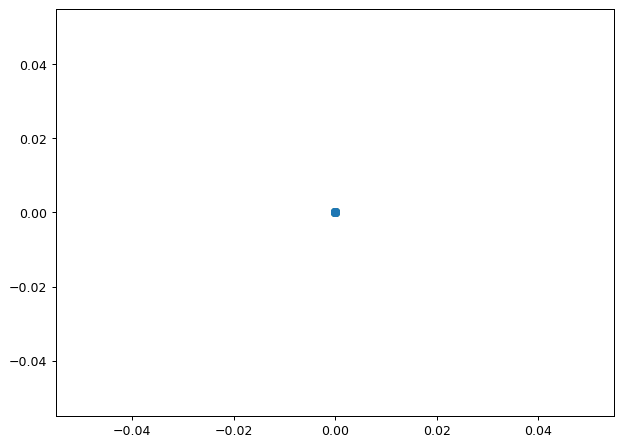

tensor(2.)


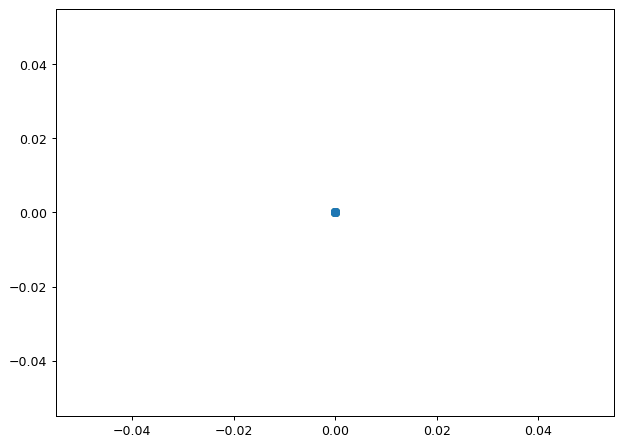

1 800 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008268558288189037
1 801 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008265380232793234
1 802 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008262205839079905
1 803 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008259035100022939
1 804 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.000825586800861508
1 805 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008252704557867869
1 806 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008249544740811578
1 807 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008246388550495144
1 808 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008243235979986107
1 809 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008240087022370541
1 810 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008236941670752998


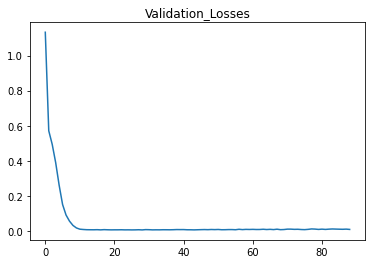

1 811 tensor(0.0044, device='cuda:0', grad_fn=<MseLossBackward>) 0.000823379991825644
1 812 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008230661758022174
1 813 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008227527183209792
1 814 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008224396186997112
1 815 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008221268762580106
1 816 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008218144903172845
1 817 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008215024602007436
1 818 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008211907852333964
1 819 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.000820879464742042
1 820 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008205684980552649
1 821 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008202578845034289
1 822 tensor(0.0036, device='cuda:0', grad_fn

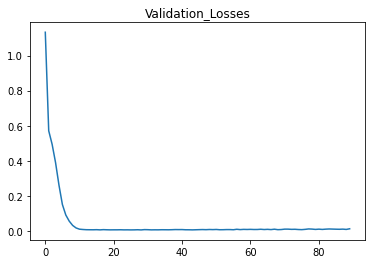

1 826 tensor(0.0048, device='cuda:0', grad_fn=<MseLossBackward>) 0.000818710090454866
1 827 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008184015817491808
1 828 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008180934215402907
1 829 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008177856091725761
1 830 tensor(0.0044, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008174781439921426
1 831 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008171710253468157
1 832 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008168642525861347
1 833 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008165578250613468
1 834 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008162517421254015
1 835 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008159460031329451
1 836 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008156406074403143
1 837 tensor(0.0037, device='cuda:0', grad_f

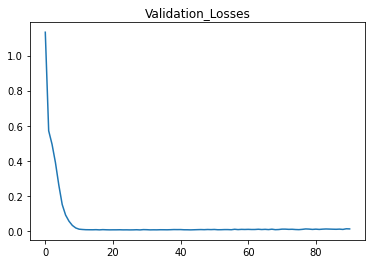

1 841 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008141187560639798
1 842 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008138154067473501
1 843 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008135123962717722
1 844 tensor(0.0048, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008132097240069068
1 845 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008129073893240547
1 846 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008126053915961522
1 847 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008123037301977641
1 848 tensor(0.0046, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008120024045050803
1 849 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008117014138959087
1 850 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008114007577496706
1 851 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008111004354473952
1 852 tensor(0.0040, device='cuda:0', grad_

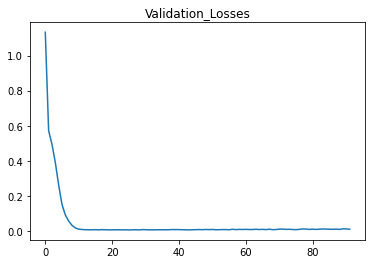

1 856 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008096038100433562
1 857 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008093054778958373
1 858 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008090074753040584
1 859 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008087098016617204
1 860 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008084124563640852
1 861 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008081154388079693
1 862 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008078187483917402
1 863 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008075223845153096
1 864 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008072263465801298
1 865 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008069306339891878
1 866 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008066352461470001
1 867 tensor(0.0040, device='cuda:0', grad_

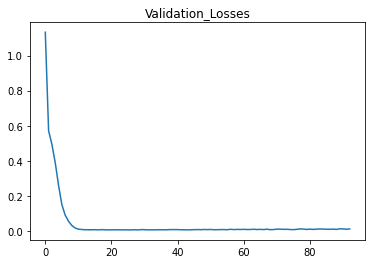

1 871 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008051631574319183
1 872 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008048697056621462
1 873 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008045765745151602
1 874 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008042837634075354
1 875 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.000803991271757333
1 876 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008036990989840942
1 877 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008034072445088355
1 878 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008031157077540444
1 879 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008028244881436741
1 880 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.000802533585103139
1 881 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.00080224299805931
1 882 tensor(0.0042, device='cuda:0', grad_fn=<

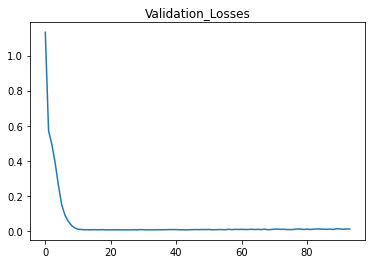

1 886 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008007947828325783
1 887 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008005060798142309
1 888 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0008002176888210664
1 889 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007999296092914373
1 890 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.00079964184066511
1 891 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007993543823832613
1 892 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007990672338884729
1 893 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.000798780394624727
1 894 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007984938640374021
1 895 tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007982076415732685
1 896 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007979217266804833
1 897 tensor(0.0040, device='cuda:0', grad_fn=

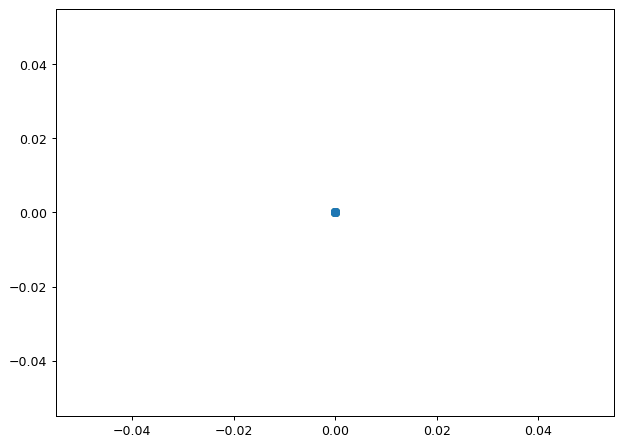

tensor(2.)


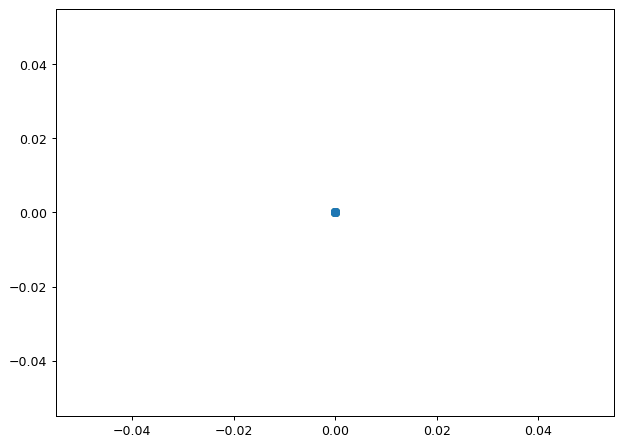

1 900 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007967811318342738


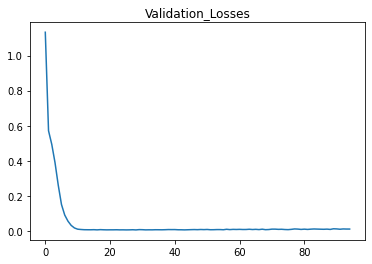

1 901 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007964967465688291
1 902 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007962126655925578
1 903 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007959288883632032
1 904 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007956454143398604
1 905 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007953622429829719
1 906 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007950793737543241
1 907 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007947968061170415
1 908 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007945145395355837
1 909 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007942325734757407
1 910 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007939509074046287
1 911 tensor(0.0044, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007936695407906858
1 912 tensor(0.0040, device='cuda:0', grad_

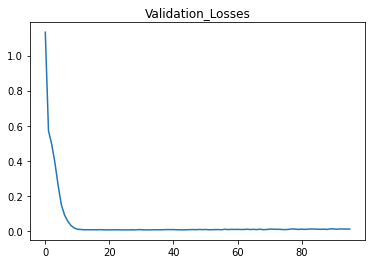

1 916 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007922671810658435
1 917 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007919876001056132
1 918 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007917083149182806
1 919 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007914293249827088
1 920 tensor(0.0044, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007911506297790459
1 921 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007908722287887199
1 922 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007905941214944359
1 923 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007903163073801709
1 924 tensor(0.0044, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007900387859311708
1 925 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007897615566339457
1 926 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007894846189762659
1 927 tensor(0.0041, device='cuda:0', grad_

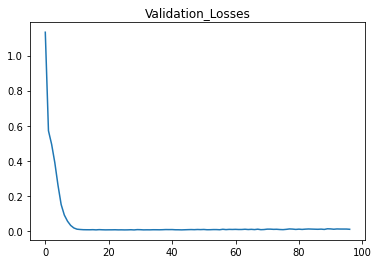

1 931 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007881042874407462
1 932 tensor(0.0046, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007878290889336044
1 933 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007875541785153614
1 934 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007872795556837294
1 935 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007870052199376455
1 936 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007867311707772683
1 937 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.000786457407703974
1 938 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007861839302203527
1 939 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007859107378302037
1 940 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007856378300385334
1 941 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007853652063515497
1 942 tensor(0.0038, device='cuda:0', grad_f

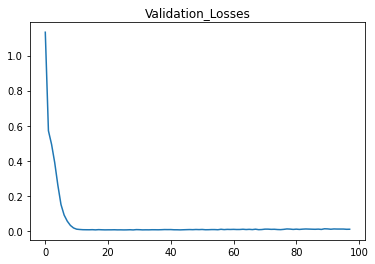

1 946 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007840063322879171
1 947 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007837354029262897
1 948 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007834647542461602
1 949 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.000783194385763222
1 950 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007829242969943374
1 951 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007826544874575344
1 952 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007823849566720029
1 953 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007821157041580911
1 954 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007818467294373017
1 955 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007815780320322885
1 956 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007813096114668531
1 957 tensor(0.0047, device='cuda:0', grad_f

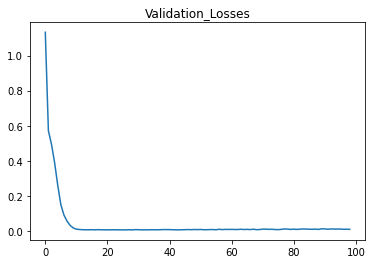

1 961 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007799716446462789
1 962 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007797048751819599
1 963 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007794383792556646
1 964 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007791721564002484
1 965 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007789062061496832
1 966 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007786405280390528
1 967 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007783751216045513
1 968 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.000778109986383478
1 969 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007778451219142349
1 970 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.000777580527736323
1 971 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007773162033903393
1 972 tensor(0.0039, device='cuda:0', grad_fn

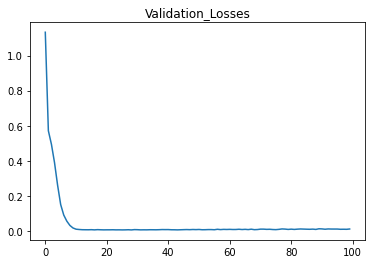

1 976 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007759986131365179
1 977 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007757358981955806
1 978 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007754734499011514
1 979 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007752112678024737
1 980 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007749493514498572
1 981 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007746877003946743
1 982 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007744263141893566
1 983 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007741651923873927
1 984 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007739043345433241
1 985 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007736437402127423
1 986 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007733834089522854
1 987 tensor(0.0040, device='cuda:0', grad_

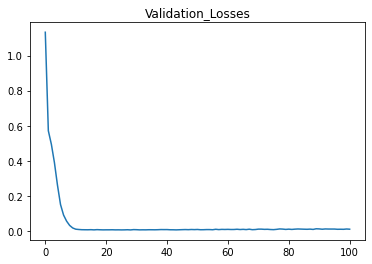

1 991 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.000772085683257096
1 992 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007718269211650173
1 993 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007715684190685776
1 994 tensor(0.0044, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007713101765326765
1 995 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007710521931232326
1 996 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007707944684071798
1 997 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007705370019524646
1 998 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007702797933280435
1 999 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007700228421038787
tensor(2.0414)


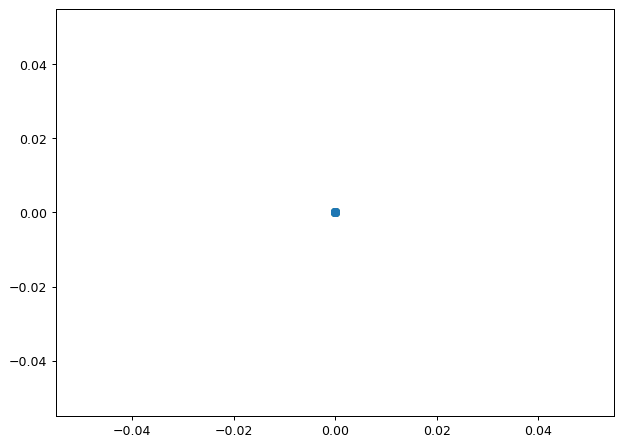

tensor(2.)


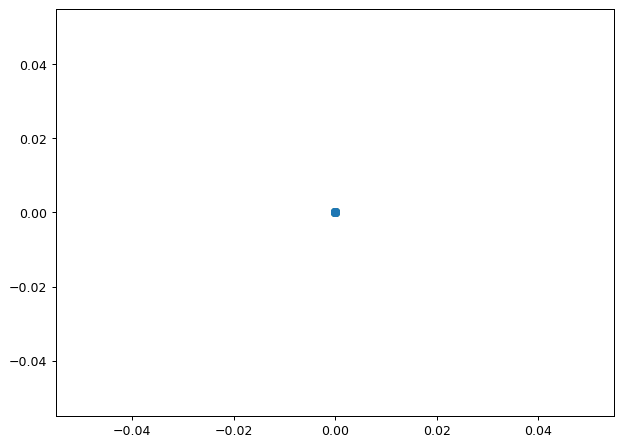

1 1000 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007697661478509366
1 1001 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007695097101411841
1 1002 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.000769253528547585
1 1003 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007689976026440981
1 1004 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007687419320056737
1 1005 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007684865162082504


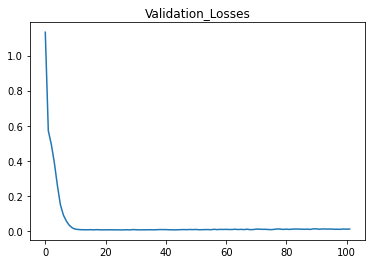

1 1006 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007682313548287526
1 1007 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007679764474450874
1 1008 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007677217936361414
1 1009 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007674673929817784
1 1010 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007672132450628358
1 1011 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.000766959349461122
1 1012 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007667057057594138
1 1013 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007664523135414528
1 1014 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007661991723919433
1 1015 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.000765946281896549
1 1016 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007656936416418902
1 1017 tensor(0.0038, device='cuda

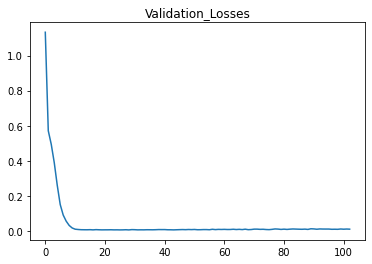

1 1021 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007644341795779502
1 1022 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007641830321399481
1 1023 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007639321320755732
1 1024 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007636814789789977
1 1025 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007634310724453255
1 1026 tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007631809120705891
1 1027 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007629309974517467
1 1028 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007626813281866803
1 1029 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007624319038741921
1 1030 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007621827241140023
1 1031 tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward>) 0.000761933788506746
1 1032 tensor(0.0034, device='cud

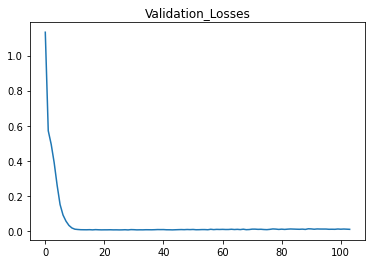

1 1036 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.000760692758850427
1 1037 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007604452798250243
1 1038 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007601980421824017
1 1039 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007599510455304196
1 1040 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007597042894778299
1 1041 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007594577736342729
1 1042 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007592114976102753
1 1043 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007589654610172472
1 1044 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007587196634674792
1 1045 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007584741045741413
1 1046 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007582287839512781
1 1047 tensor(0.0038, device='cud

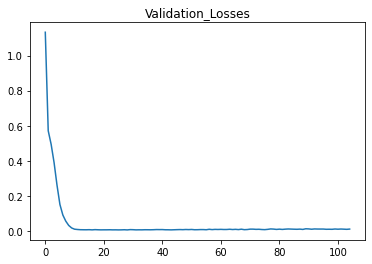

1 1051 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007570057414466556
1 1052 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.000756761842390317
1 1053 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007565181789270796
1 1054 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007562747506779042
1 1055 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007560315572646046
1 1056 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007557885983098455
1 1057 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007555458734371403
1 1058 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007553033822708472
1 1059 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007550611244361686
1 1060 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007548190995591477
1 1061 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007545773072666663
1 1062 tensor(0.0041, device='cud

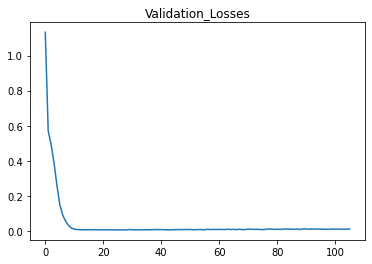

1 1066 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.000753371821571601
1 1067 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007531314169975251
1 1068 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007528912424194373
1 1069 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.000752651297470841
1 1070 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007524115817860575
1 1071 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007521720950002217
1 1072 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007519328367492819
1 1073 tensor(0.0044, device='cuda:0', grad_fn=<MseLossBackward>) 0.000751693806669996
1 1074 tensor(0.0044, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007514550043999297
1 1075 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007512164295774543
1 1076 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007509780818417443
1 1077 tensor(0.0040, device='cuda:

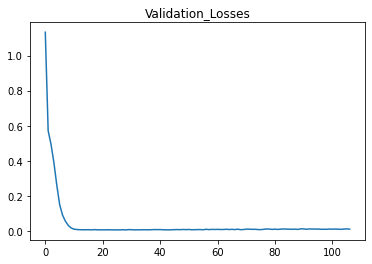

1 1081 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007497897368917129
1 1082 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007495527441439475
1 1083 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007493159759794657
1 1084 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007490794320437853
1 1085 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007488431119832071
1 1086 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007486070154448126
1 1087 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007483711420764613
1 1088 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007481354915267892
1 1089 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007479000634452065
1 1090 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007476648574818945
1 1091 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007474298732878048
1 1092 tensor(0.0039, device='cu

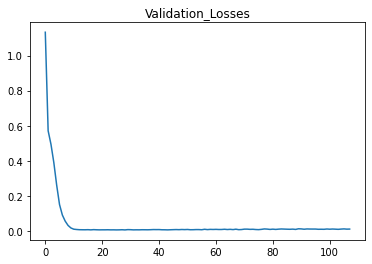

1 1096 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007462582666925858
1 1097 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007460246058266325
1 1098 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007457911643079283
1 1099 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007455579417935034
tensor(2.0778)


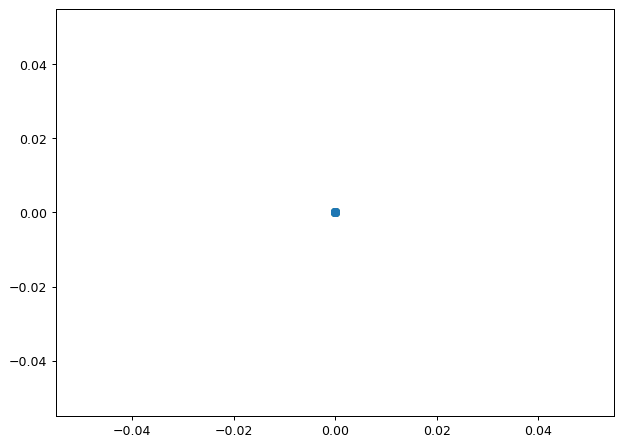

tensor(2.)


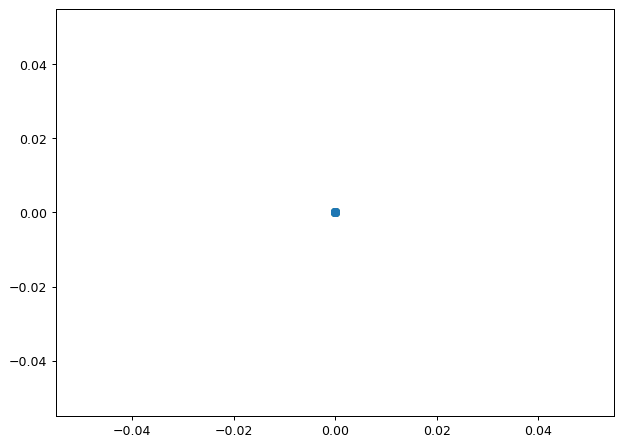

1 1100 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007453249379411388
1 1101 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007450921524093635
1 1102 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007448595848574528
1 1103 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007446272349454255
1 1104 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007443951023340427
1 1105 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007441631866848056
1 1106 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007439314876599522
1 1107 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007437000049224573
1 1108 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007434687381360287
1 1109 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007432376869651058
1 1110 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007430068510748577


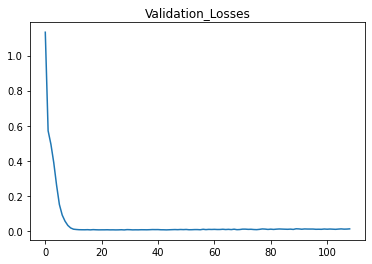

1 1111 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007427762301311808
1 1112 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007425458238006973
1 1113 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007423156317507525
1 1114 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007420856536494133
1 1115 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007418558891654659
1 1116 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007416263379684141
1 1117 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007413969997284768
1 1118 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007411678741165868
1 1119 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007409389608043876
1 1120 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007407102594642329
1 1121 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007404817697691836
1 1122 tensor(0.0036, device='cu

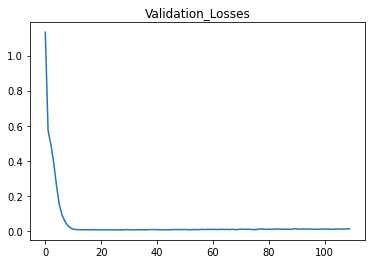

1 1126 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007393424845769264
1 1127 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007391152579261612
1 1128 tensor(0.0046, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007388882406515731
1 1129 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007386614324318134
1 1130 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007384348329462225
1 1131 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007382084418748294
1 1132 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007379822588983496
1 1133 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007377562836981821
1 1134 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007375305159564097
1 1135 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007373049553557944
1 1136 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007370796015797779
1 1137 tensor(0.0035, device='cu

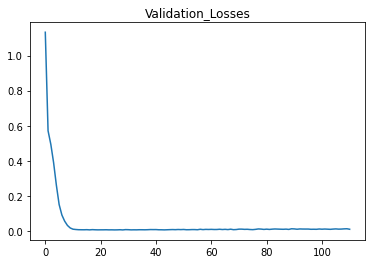

1 1141 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.000735955924036404
1 1142 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007357318045980248
1 1143 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007355078897871829
1 1144 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007352841792926828
1 1145 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007350606728039916
1 1146 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007348373700112362
1 1147 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007346142706052024
1 1148 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007343913742773326
1 1149 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007341686807197244
1 1150 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007339461896251281
1 1151 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007337239006869459
1 1152 tensor(0.0035, device='cud

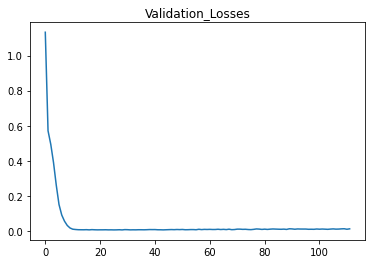

1 1156 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007326154776566891
1 1157 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.000732394395254688
1 1158 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007321735128810053
1 1159 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.000731952830234191
1 1160 tensor(0.0033, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007317323470134303
1 1161 tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007315120629185426
1 1162 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007312919776499793
1 1163 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007310720909088225
1 1164 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007308524023967827
1 1165 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007306329118161979
1 1166 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007304136188700312
1 1167 tensor(0.0037, device='cuda

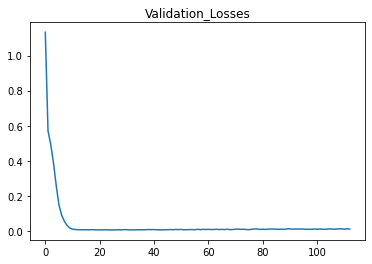

1 1171 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007293201083027459
1 1172 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007291019949601245
1 1173 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007288840771900333
1 1174 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007286663547003781
1 1175 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007284488271996753
1 1176 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007282314943970502
1 1177 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007280143560022347
1 1178 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007277974117255666
1 1179 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007275806612779876
1 1180 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007273641043710413
1 1181 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007271477407168724
1 1182 tensor(0.0039, device='cu

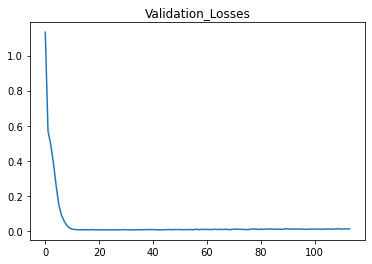

1 1186 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007260688112045842
1 1187 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007258536010555458
1 1188 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007256385821609791
1 1189 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007254237542377764
1 1190 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.000725209117003416
1 1191 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007249946701759611
1 1192 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007247804134740587
1 1193 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007245663466169363
1 1194 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007243524693244026
1 1195 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007241387813168447
1 1196 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007239252823152263
1 1197 tensor(0.0038, device='cud

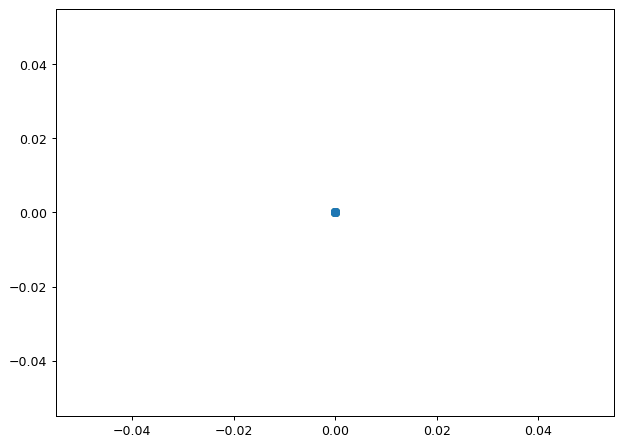

tensor(2.)


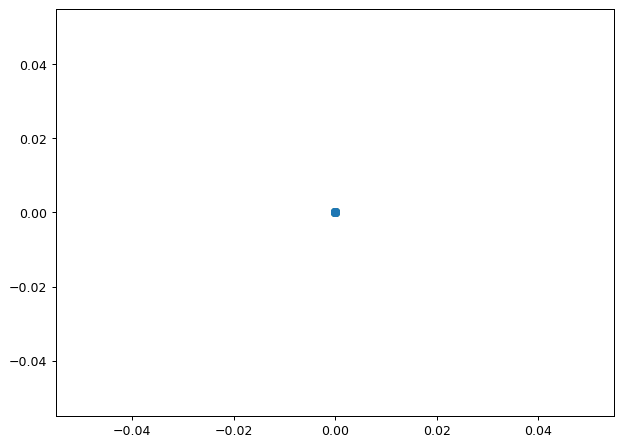

1 1200 tensor(0.0033, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007230731708075418


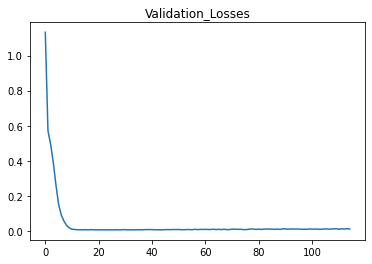

1 1201 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007228606126701727
1 1202 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007226482418765606
1 1203 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007224360581516662
1 1204 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007222240612210157
1 1205 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007220122508106984
1 1206 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007218006266473656
1 1207 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007215891884582293
1 1208 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007213779359710604
1 1209 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007211668689141873
1 1210 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007209559870164947
1 1211 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007207452900074216
1 1212 tensor(0.0036, device='cu

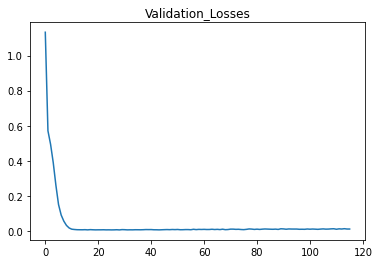

1 1216 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007196945688603626
1 1217 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007194849755321063
1 1218 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007192755652139516
1 1219 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007190663376397228
1 1220 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007188572925437855
1 1221 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007186484296610459
1 1222 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007184397487269488
1 1223 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007182312494774766
1 1224 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007180229316491476
1 1225 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007178147949790149
1 1226 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007176068392046647
1 1227 tensor(0.0040, device='cu

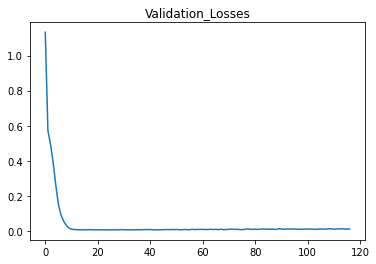

1 1231 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007165697646223228
1 1232 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007163628887416662
1 1233 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007161561919347104
1 1234 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007159496739432581
1 1235 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007157433345096327
1 1236 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007155371733766772
1 1237 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007153311902877527
1 1238 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007151253849867372
1 1239 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007149197572180245
1 1240 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.000714714306726522
1 1241 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007145090332576504
1 1242 tensor(0.0038, device='cud

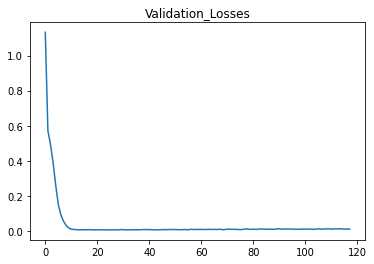

1 1246 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007134853123782113
1 1247 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007132810957275116
1 1248 tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007130770543316361
1 1249 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.000712873187940061
1 1250 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007126694963027636
1 1251 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007124659791702206
1 1252 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007122626362934077
1 1253 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007120594674237975
1 1254 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007118564723133587
1 1255 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007116536507145547
1 1256 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007114510023803422
1 1257 tensor(0.0038, device='cud

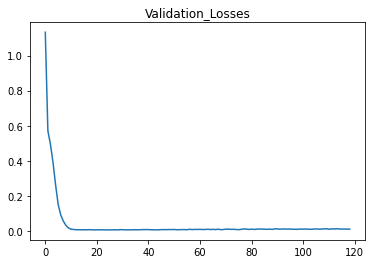

1 1261 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007104403510660191
1 1262 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.00071023873715892
1 1263 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007100372948008199
1 1264 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007098360237485774
1 1265 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007096349237595336
1 1266 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007094339945915106
1 1267 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007092332360028103
1 1268 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007090326477522127
1 1269 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007088322295989756
1 1270 tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007086319813028328
1 1271 tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007084319026239923
1 1272 tensor(0.0038, device='cuda

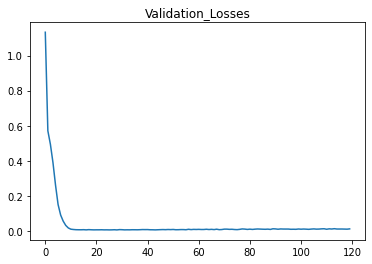

1 1276 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007074340451297159
1 1277 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007072349791455107
1 1278 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007070360811132631
1 1279 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007068373507969374
1 1280 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007066387879609621
1 1281 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007064403923702286
1 1282 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007062421637900902
1 1283 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007060441019863606
1 1284 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007058462067253135
1 1285 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007056484777736804
1 1286 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007054509148986503
1 1287 tensor(0.0036, device='cu

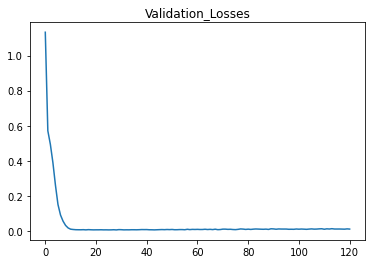

1 1291 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007044655835560087
1 1292 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007042690122770181
1 1293 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007040726054576567
1 1294 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007038763628687293
1 1295 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007036802842814879
1 1296 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007034843694676304
1 1297 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007032886181992991
1 1298 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.00070309303024908
1 1299 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007028976053900014
tensor(2.0683)


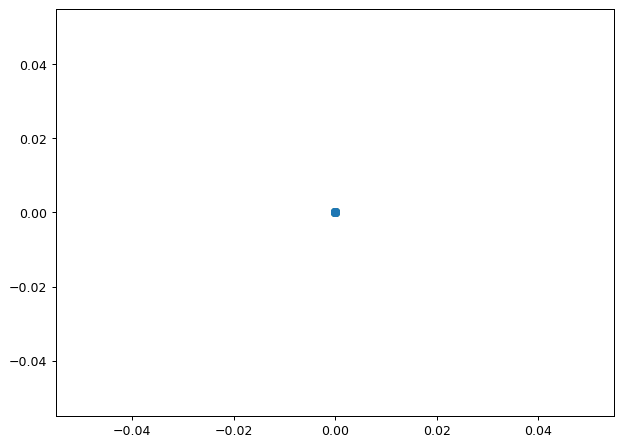

tensor(2.)


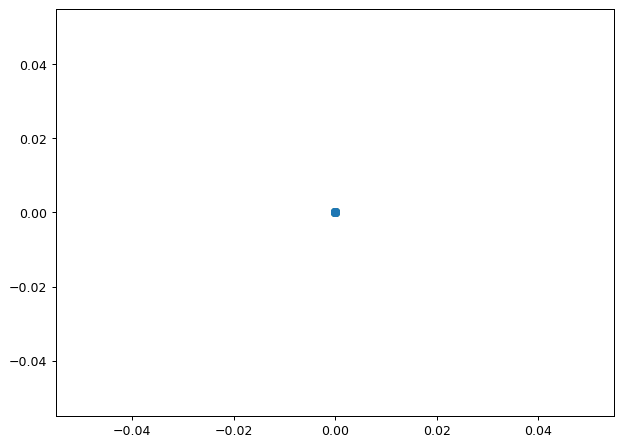

1 1300 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007027023433955335
1 1301 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007025072440395862
1 1302 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007023123070965086
1 1303 tensor(0.0033, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007021175323410882
1 1304 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007019229195485494
1 1305 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007017284684945522


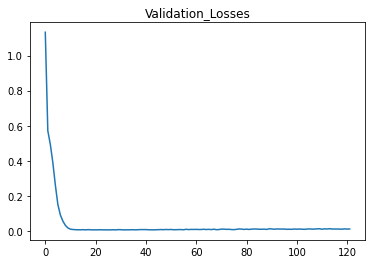

1 1306 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007015341789551916
1 1307 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007013400507069962
1 1308 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007011460835269274
1 1309 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.000700952277192378
1 1310 tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007007586314811715
1 1311 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007005651461715605
1 1312 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0007003718210422263
1 1313 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.000700178655872277
1 1314 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006999856504412474
1 1315 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006997928045290973
1 1316 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006996001179162105
1 1317 tensor(0.0044, device='cuda

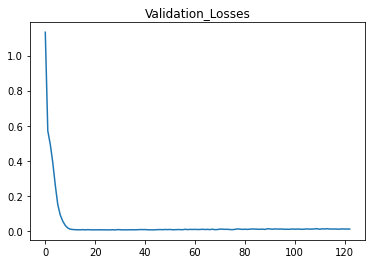

1 1321 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006986390666837199
1 1322 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006984473312780937
1 1323 tensor(0.0033, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006982557536462055
1 1324 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006980643335717946
1 1325 tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward>) 0.000697873070839015
1 1326 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006976819652324344
1 1327 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006974910165370335
1 1328 tensor(0.0044, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006973002245382044
1 1329 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.00069710958902175
1 1330 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006969191097738831
1 1331 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006967287865812249
1 1332 tensor(0.0037, device='cuda:

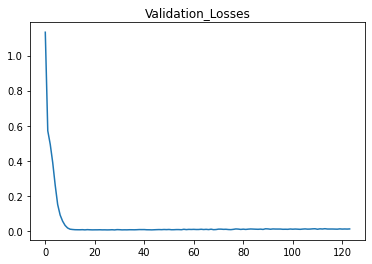

1 1336 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006957795040062917
1 1337 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006955901126866933
1 1338 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006954008759400121
1 1339 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.000695211793556103
1 1340 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006950228653252207
1 1341 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006948340910380183
1 1342 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006946454704855475
1 1343 tensor(0.0033, device='cuda:0', grad_fn=<MseLossBackward>) 0.000694457003459256
1 1344 tensor(0.0033, device='cuda:0', grad_fn=<MseLossBackward>) 0.000694268689750988
1 1345 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006940805291529823
1 1346 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006938925214578717
1 1347 tensor(0.0039, device='cuda:

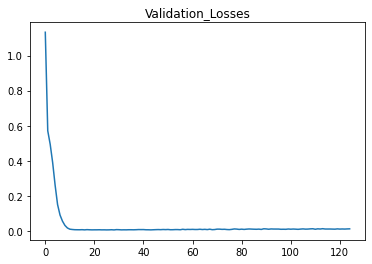

1 1351 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006929547692953474
1 1352 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006927676746848358
1 1353 tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006925807315365989
1 1354 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006923939396463865
1 1355 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006922072988103342
1 1356 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006920208088249618
1 1357 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006918344694871726
1 1358 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006916482805942525
1 1359 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006914622419438693
1 1360 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006912763533340715
1 1361 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006910906145632874
1 1362 tensor(0.0039, device='cu

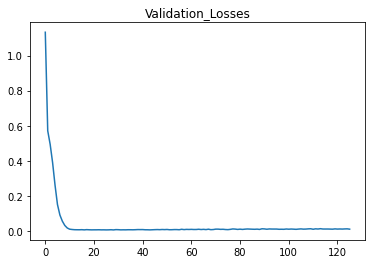

1 1366 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006901641612660328
1 1367 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006899793173174792
1 1368 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006897946218074958
1 1369 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006896100745375166
1 1370 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006894256753093475
1 1371 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006892414239251649
1 1372 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006890573201875155
1 1373 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006888733638993144
1 1374 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006886895548638457
1 1375 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006885058928847598
1 1376 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006883223777660738
1 1377 tensor(0.0039, device='cu

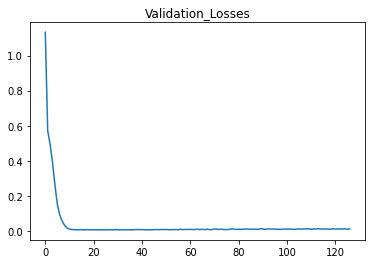

1 1381 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006874069982447793
1 1382 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006872243601932587
1 1383 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006870418676404427
1 1384 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006868595203932472
1 1385 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006866773182589476
1 1386 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006864952610451767
1 1387 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006863133485599238
1 1388 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006861315806115345
1 1389 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006859499570087094
1 1390 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006857684775605035
1 1391 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006855871420763251
1 1392 tensor(0.0035, device='cu

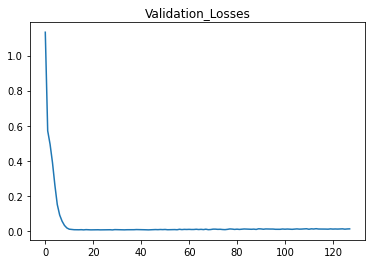

1 1396 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006846826174697735
1 1397 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006845021417870226
1 1398 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006843218087439838
1 1399 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006841416181528625
tensor(2.1188)


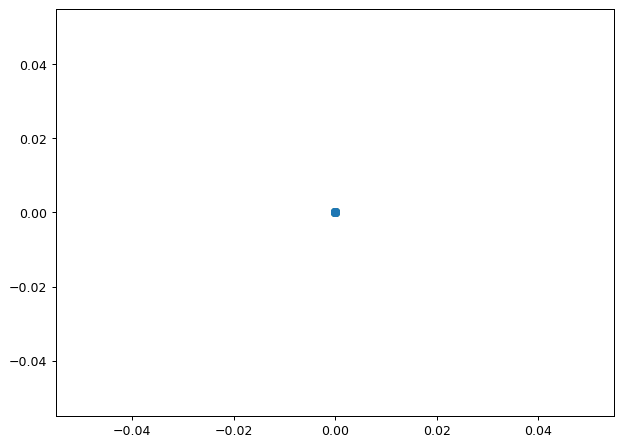

tensor(2.)


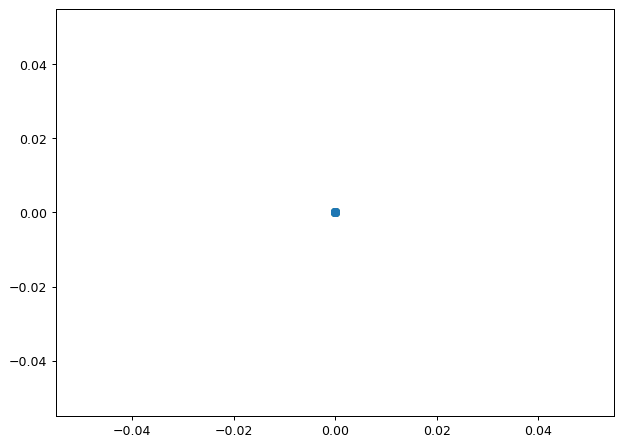

1 1400 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006839615698262107
1 1401 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006837816635769253
1 1402 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006836018992182475
1 1403 tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward>) 0.000683422276563762
1 1404 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006832427954273962
1 1405 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006830634556234193
1 1406 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.000682884256966442
1 1407 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006827051992714146
1 1408 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006825262823536274
1 1409 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006823475060287091
1 1410 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006821688701126265


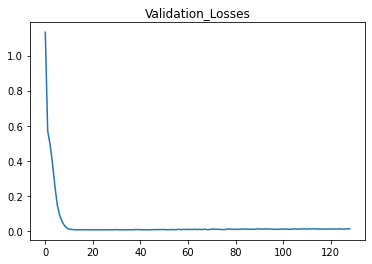

1 1411 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006819903744216833
1 1412 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006818120187725195
1 1413 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006816338029821108
1 1414 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.000681455726867767
1 1415 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006812777902471327
1 1416 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.000681099992938185
1 1417 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006809223347592335
1 1418 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006807448155289195
1 1419 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.000680567435066215
1 1420 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.000680390193190422
1 1421 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006802130897211717
1 1422 tensor(0.0034, device='cuda:0

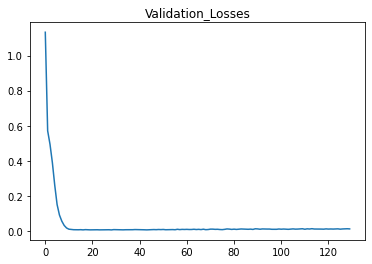

1 1426 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006793296421831062
1 1427 tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward>) 0.00067915336538371
1 1428 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006789772257374297
1 1429 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006788012230665032
1 1430 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006786253571934904
1 1431 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.000678449627941273
1 1432 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006782740351330538
1 1433 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.000678098578592355
1 1434 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006779232581430193
1 1435 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006777480736092071
1 1436 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006775730248153971
1 1437 tensor(0.0039, device='cuda:0

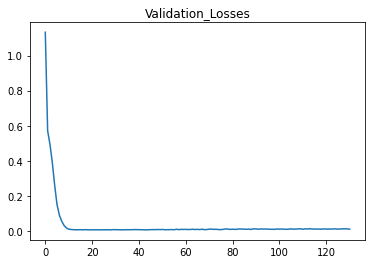

1 1441 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006766998108252954
1 1442 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006765255728032612
1 1443 tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006763514693014195
1 1444 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006761775001467662
1 1445 tensor(0.0033, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006760036651666078
1 1446 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006758299641885619
1 1447 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006756563970405559
1 1448 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006754829635508264
1 1449 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006753096635479187
1 1450 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.000675136496860685
1 1451 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006749634633182858
1 1452 tensor(0.0042, device='cud

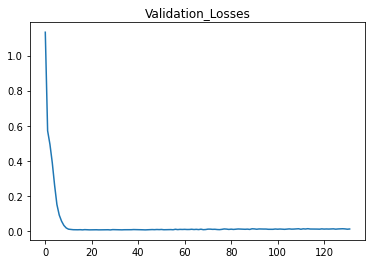

1 1456 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006741002868208012
1 1457 tensor(0.0033, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006739280485768697
1 1458 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006737559422904296
1 1459 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006735839677930715
1 1460 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006734121249166874
1 1461 tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward>) 0.000673240413493469
1 1462 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006730688333559072
1 1463 tensor(0.0032, device='cuda:0', grad_fn=<MseLossBackward>) 0.000672897384336792
1 1464 tensor(0.0033, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006727260662692108
1 1465 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006725548789865492
1 1466 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006723838223224887
1 1467 tensor(0.0036, device='cuda

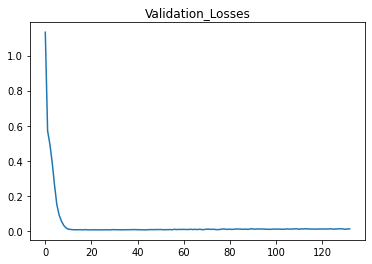

1 1471 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006715304924807421
1 1472 tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006713602160521309
1 1473 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006711900690861419
1 1474 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006710200514188057
1 1475 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006708501628864434
1 1476 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006706804033256663
1 1477 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006705107725733744
1 1478 tensor(0.0033, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006703412704667569
1 1479 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006701718968432908
1 1480 tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006700026515407403
1 1481 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006698335343971559
1 1482 tensor(0.0037, device='cu

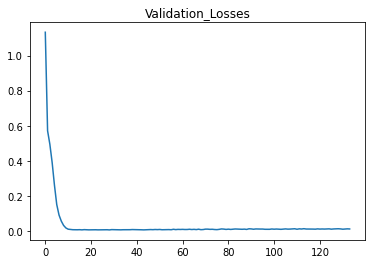

1 1486 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006689898654154957
1 1487 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006688215138407492
1 1488 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006686532892992971
1 1489 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006684851916314605
1 1490 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006683172206778406
1 1491 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006681493762793197
1 1492 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006679816582770591
1 1493 tensor(0.0033, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006678140665124993
1 1494 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.000667646600827359
1 1495 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.000667479261063635
1 1496 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006673120470636005
1 1497 tensor(0.0036, device='cuda

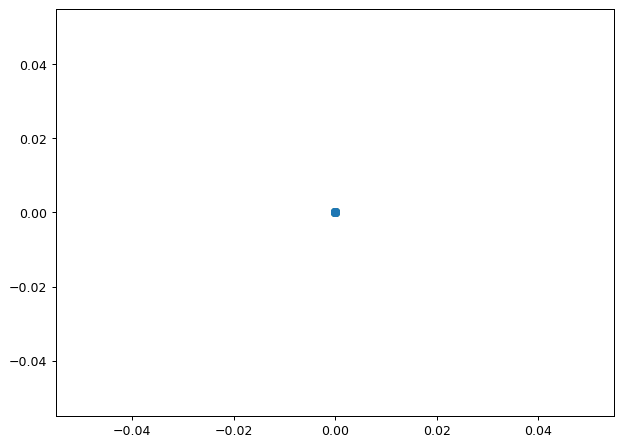

tensor(2.)


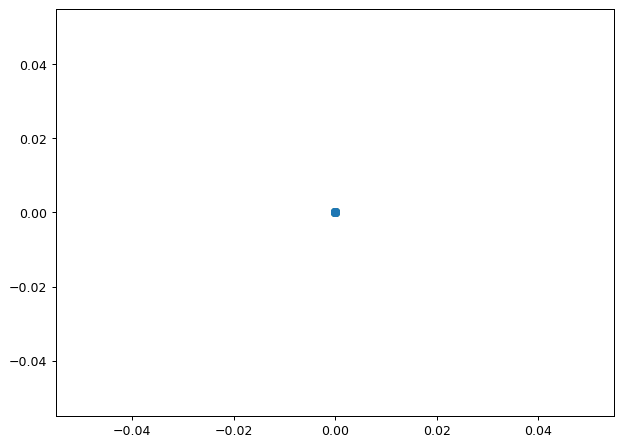

1 1500 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006666444455554938


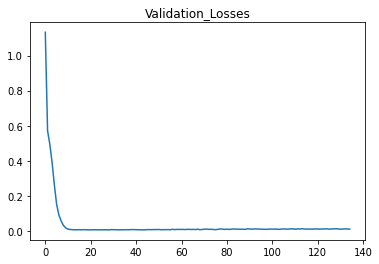

1 1501 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006664778580176653
1 1502 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006663113953029518
1 1503 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006661450572555488
1 1504 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006659788437199242
1 1505 tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006658127545408174
1 1506 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006656467895632386
1 1507 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006654809486324685
1 1508 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006653152315940573
1 1509 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006651496382938244
1 1510 tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006649841685778576
1 1511 tensor(0.0033, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006648188222925127
1 1512 tensor(0.0033, device='cu

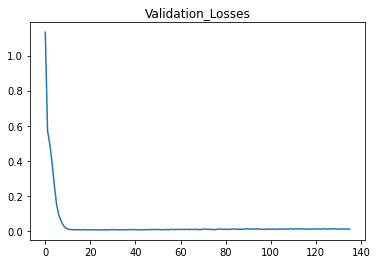

1 1516 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006639939369662439
1 1517 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006638293280530273
1 1518 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006636648415023735
1 1519 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.00066350047716276
1 1520 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006633362348829266
1 1521 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006631721145118755
1 1522 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006630081158988698
1 1523 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006628442388934337
1 1524 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006626804833453515
1 1525 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006625168491046674
1 1526 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006623533360216843
1 1527 tensor(0.0033, device='cuda

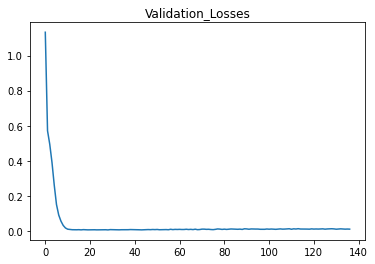

1 1531 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006615375827509545
1 1532 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.000661374793484978
1 1533 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006612121243360298
1 1534 tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward>) 0.000661049575156465
1 1535 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006608871457988928
1 1536 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006607248361161755
1 1537 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006605626459614282
1 1538 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006604005751880186
1 1539 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006602386236495659
1 1540 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006600767911999403
1 1541 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006599150776932627
1 1542 tensor(0.0032, device='cuda

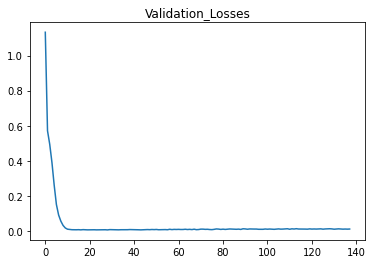

1 1546 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006591082892158047
1 1547 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006589472863173211
1 1548 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.000658786401347603
1 1549 tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006586256341627567
1 1550 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006584649846191338
1 1551 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006583044525733313
1 1552 tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006581440378821906
1 1553 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006579837404027972
1 1554 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006578235599924804
1 1555 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006576634965088121
1 1556 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006575035498096071
1 1557 tensor(0.0035, device='cud

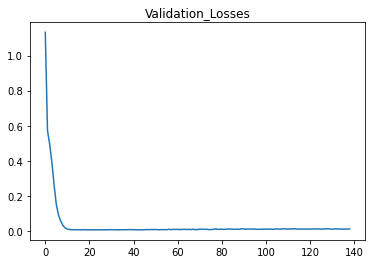

1 1561 tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006567055631209458
1 1562 tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006565463141561378
1 1563 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006563871809872399
1 1564 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006562281634739875
1 1565 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006560692614763538
1 1566 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006559104748545491
1 1567 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006557518034690206
1 1568 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006555932471804515
1 1569 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006554348058497607
1 1570 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006552764793381025
1 1571 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006551182675068656
1 1572 tensor(0.0038, device='cu

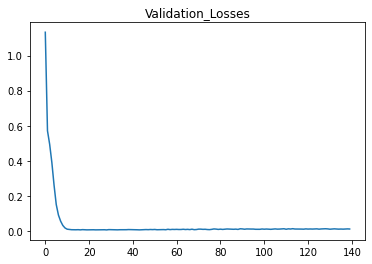

1 1576 tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006543289237219727
1 1577 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006541713970755063
1 1578 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006540139841457109
1 1579 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006538566847958344
1 1580 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006536994988893546
1 1581 tensor(0.0033, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006535424262899796
1 1582 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006533854668616458
1 1583 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006532286204685188
1 1584 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.000653071886974992
1 1585 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006529152662456866
1 1586 tensor(0.0033, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006527587581454512
1 1587 tensor(0.0034, device='cud

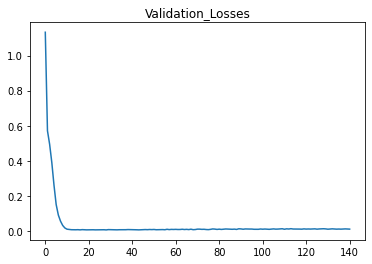

1 1591 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006519779023658528
1 1592 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.000651822067214511
1 1593 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006516663437524969
1 1594 tensor(0.0033, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006515107318464588
1 1595 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006513552313632672
1 1596 tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006511998421700158
1 1597 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006510445641340193
1 1598 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006508893971228142
1 1599 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006507343410041578
tensor(2.0554)


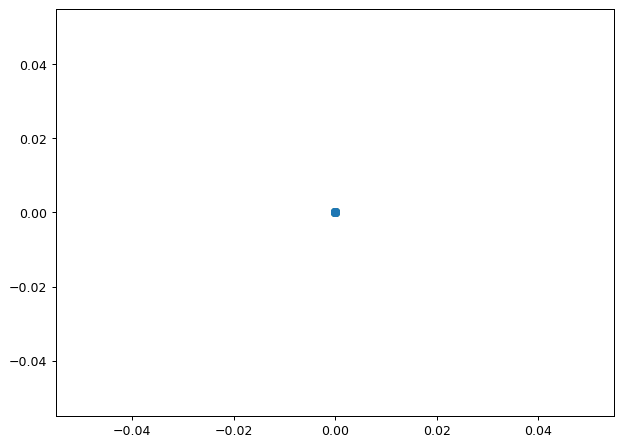

tensor(2.)


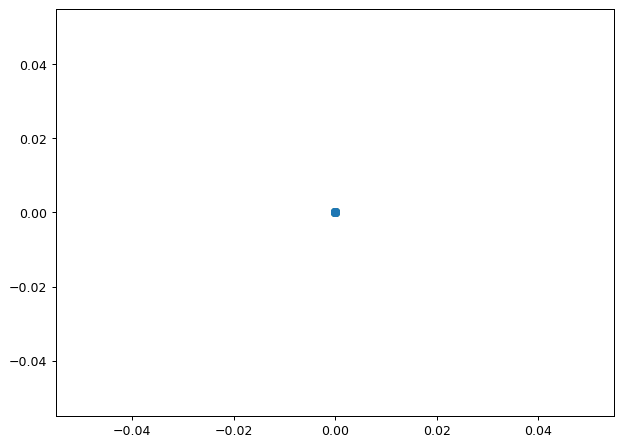

1 1600 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.000650579395646028
1 1601 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006504245609166221
1 1602 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006502698366843576
1 1603 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006501152228178704
1 1604 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006499607191860154
1 1605 tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006498063256578651


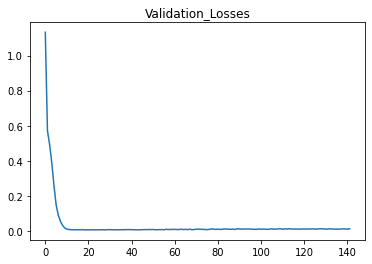

1 1606 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006496520421027101
1 1607 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006494978683900577
1 1608 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006493438043896322
1 1609 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006491898499713739
1 1610 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.000649036005005439
1 1611 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006488822693621986
1 1612 tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006487286429122394
1 1613 tensor(0.0033, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006485751255263617
1 1614 tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006484217170755803
1 1615 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006482684174311229
1 1616 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006481152264644308
1 1617 tensor(0.0036, device='cud

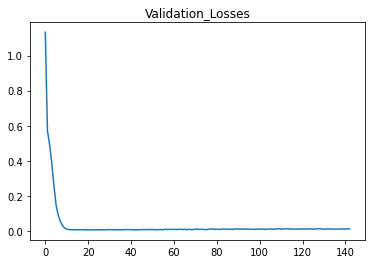

1 1621 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006473508973127368
1 1622 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006471983557247686
1 1623 tensor(0.0033, device='cuda:0', grad_fn=<MseLossBackward>) 0.000647045921920579
1 1624 tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006468935957732969
1 1625 tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward>) 0.00064674137715626
1 1626 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.000646589265943015
1 1627 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006464372620073164
1 1628 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006462853652231259
1 1629 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006461335754646133
1 1630 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006459818926061545
1 1631 tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006458303165223318
1 1632 tensor(0.0036, device='cuda:0

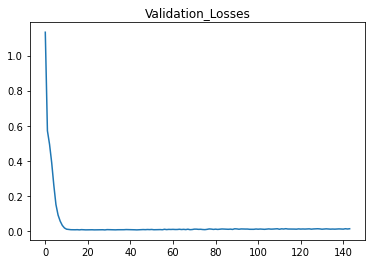

1 1636 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006450740333475386
1 1637 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006449230952892658
1 1638 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006447722631334474
1 1639 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006446215367563013
1 1640 tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006444709160342473
1 1641 tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006443204008439076
1 1642 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006441699910621061
1 1643 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006440196865658671
1 1644 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006438694872324166
1 1645 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006437193929391806
1 1646 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.000643569403563785
1 1647 tensor(0.0038, device='cud

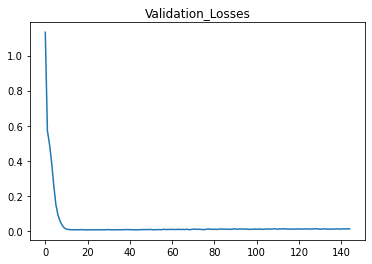

1 1651 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.00064282102618526
1 1652 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006426716637581932
1 1653 tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006425224053979107
1 1654 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.000642373250983623
1 1655 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006422242003947364
1 1656 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006420752535108531
1 1657 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006419264102117708
1 1658 tensor(0.0033, device='cuda:0', grad_fn=<MseLossBackward>) 0.000641777670377482
1 1659 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006416290338881741
1 1660 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006414805006242281
1 1661 tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward>) 0.000641332070466219
1 1662 tensor(0.0038, device='cuda:0'

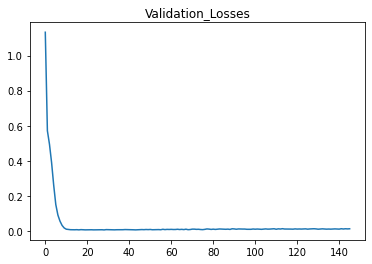

1 1666 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006405914620988672
1 1667 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006404436480793554
1 1668 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006402959363351969
1 1669 tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006401483267485025
1 1670 tensor(0.0031, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006400008192015728
1 1671 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006398534135768984
1 1672 tensor(0.0032, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006397061097571593
1 1673 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006395589076252241
1 1674 tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006394118070641504
1 1675 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006392648079571835
1 1676 tensor(0.0033, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006391179101877572
1 1677 tensor(0.0031, device='cu

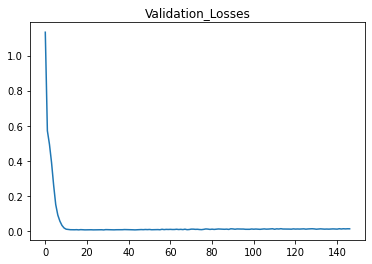

1 1681 tensor(0.0032, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006383849373369997
1 1682 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006382386451553861
1 1683 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006380924535005731
1 1684 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006379463622574823
1 1685 tensor(0.0033, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006378003713112204
1 1686 tensor(0.0032, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006376544805470773
1 1687 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006375086898505271
1 1688 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006373629991072268
1 1689 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006372174082030163
1 1690 tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006370719170239182
1 1691 tensor(0.0032, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006369265254561364
1 1692 tensor(0.0035, device='cu

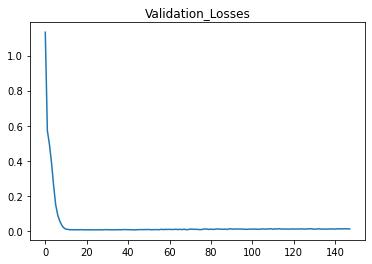

1 1696 tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006362010578168317
1 1697 tensor(0.0033, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006360562615373926
1 1698 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006359115640777683
1 1699 tensor(0.0033, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006357669653256066
tensor(2.0531)


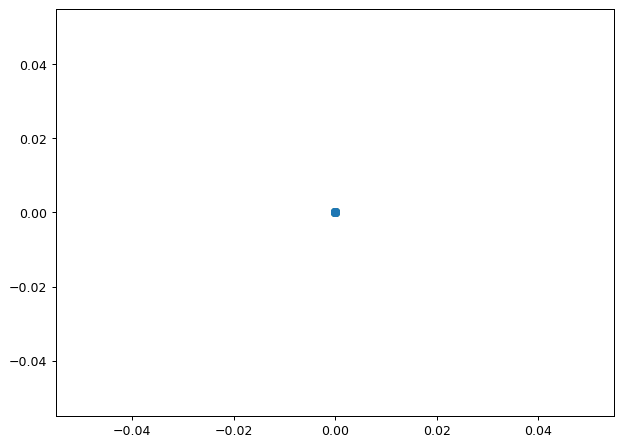

tensor(2.)


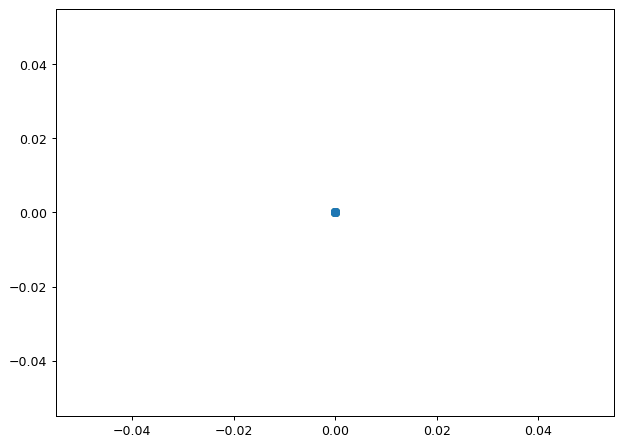

1 1700 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006356224651687338
1 1701 tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006354780634951547
1 1702 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006353337601930524
1 1703 tensor(0.0033, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006351895551507873
1 1704 tensor(0.0033, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006350454482568973
1 1705 tensor(0.0030, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006349014394000971
1 1706 tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006347575284692782
1 1707 tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006346137153535081
1 1708 tensor(0.0033, device='cuda:0', grad_fn=<MseLossBackward>) 0.00063446999994203
1 1709 tensor(0.0031, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006343263821242631
1 1710 tensor(0.0032, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006341828617898013


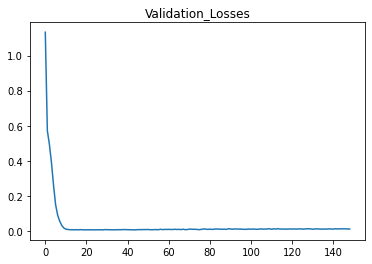

1 1711 tensor(0.0032, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006340394388284134
1 1712 tensor(0.0032, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006338961131300426
1 1713 tensor(0.0033, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006337528845848065
1 1714 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006336097530829959
1 1715 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006334667185150751
1 1716 tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006333237807716817
1 1717 tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006331809397436258
1 1718 tensor(0.0031, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006330381953218897
1 1719 tensor(0.0032, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006328955473976277
1 1720 tensor(0.0031, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006327529958621659
1 1721 tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006326105406070015
1 1722 tensor(0.0031, device='cu

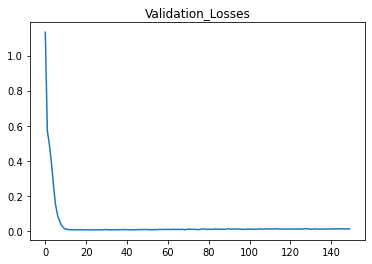

1 1726 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006318997047499871
1 1727 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006317578249075956
1 1728 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006316160405907485
1 1729 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006314743516923005
1 1730 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.000631332758105275
1 1731 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006311912597228627
1 1732 tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006310498564384221
1 1733 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006309085481454788
1 1734 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006307673347377251
1 1735 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.00063062621610902
1 1736 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006304851921533885
1 1737 tensor(0.0035, device='cuda:

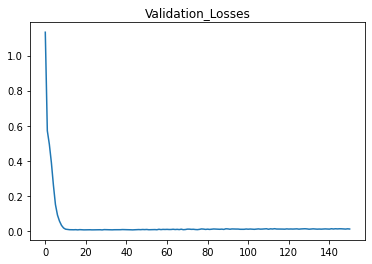

1 1741 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006297814887738014
1 1742 tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006296410306404003
1 1743 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006295006664428723
1 1744 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.00062936039607656
1 1745 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006292202194369686
1 1746 tensor(0.0032, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006290801364197665
1 1747 tensor(0.0033, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006289401469207845
1 1748 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006288002508360157
1 1749 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006286604480616148
1 1750 tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006285207384938984
1 1751 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006283811220293442
1 1752 tensor(0.0033, device='cuda

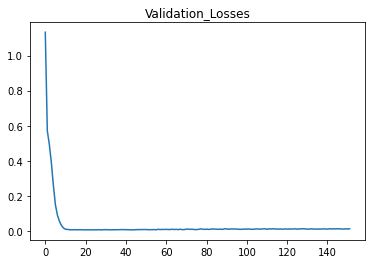

1 1756 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006276844326419677
1 1757 tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006275453726314049
1 1758 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.000627406405003835
1 1759 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.000627267529657014
1 1760 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006271287464888562
1 1761 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006269900553974336
1 1762 tensor(0.0033, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006268514562809766
1 1763 tensor(0.0033, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006267129490378725
1 1764 tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006265745335666656
1 1765 tensor(0.0033, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006264362097660575
1 1766 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006262979775349056
1 1767 tensor(0.0038, device='cuda

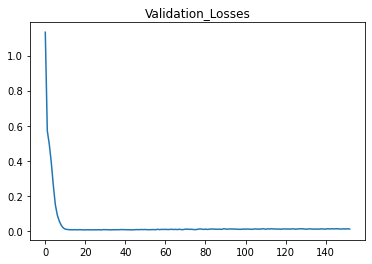

1 1771 tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006256081863919285
1 1772 tensor(0.0033, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006254705014622516
1 1773 tensor(0.0033, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006253329073983907
1 1774 tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006251954041004441
1 1775 tensor(0.0032, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006250579914686642
1 1776 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006249206694034561
1 1777 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006247834378053786
1 1778 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006246462965751433
1 1779 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006245092456136138
1 1780 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006243722848218065
1 1781 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006242354141008891
1 1782 tensor(0.0036, device='cu

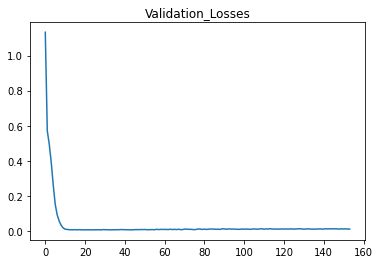

1 1786 tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward>) 0.000623552408111126
1 1787 tensor(0.0033, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006234160757485444
1 1788 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006232798327692566
1 1789 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006231436790756346
1 1790 tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006230076145702005
1 1791 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006228716391556245
1 1792 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006227357527347259
1 1793 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006225999552104722
1 1794 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006224642464859787
1 1795 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006223286264645091
1 1796 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006221930950494741
1 1797 tensor(0.0034, device='cud

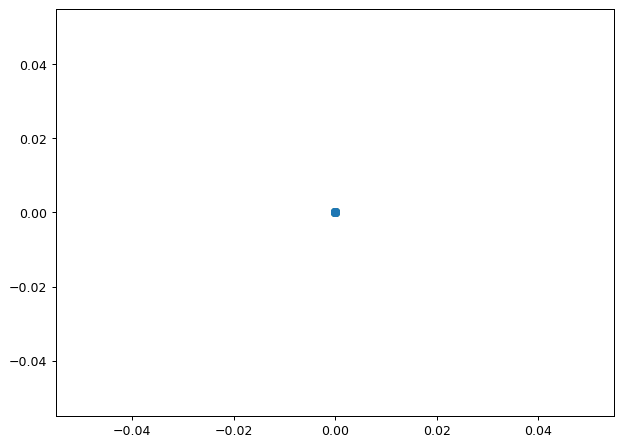

tensor(2.)


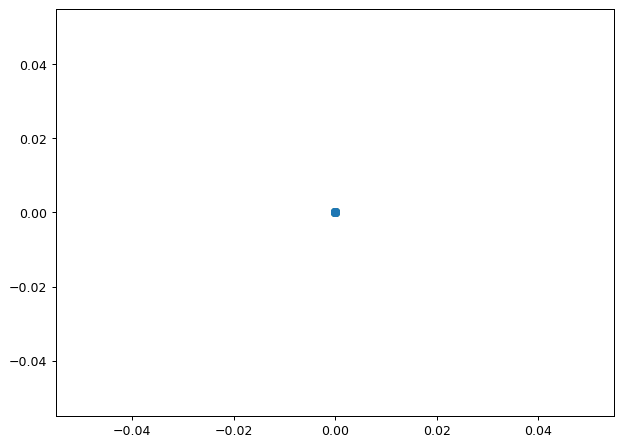

1 1800 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006216518535270398


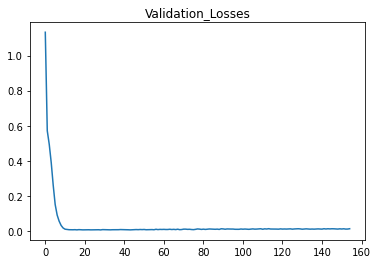

1 1801 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006215167637004804
1 1802 tensor(0.0032, device='cuda:0', grad_fn=<MseLossBackward>) 0.000621381761903901
1 1803 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006212468480417368
1 1804 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006211120220185677
1 1805 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.000620977283739119
1 1806 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006208426331082604
1 1807 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006207080700310059
1 1808 tensor(0.0032, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006205735944125138
1 1809 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006204392061580859
1 1810 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006203049051731674
1 1811 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006201706913633472
1 1812 tensor(0.0038, device='cuda

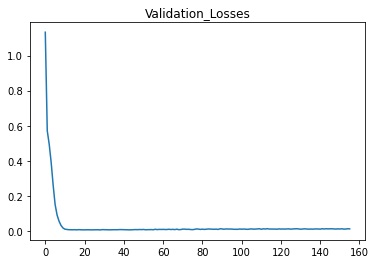

1 1816 tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006195009266463073
1 1817 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006193672339124205
1 1818 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006192336276967384
1 1819 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006191001079059853
1 1820 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006189666744470262
1 1821 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006188333272268665
1 1822 tensor(0.0033, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006187000661526521
1 1823 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006185668911316681
1 1824 tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006184338020713398
1 1825 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006183007988792321
1 1826 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006181678814630483
1 1827 tensor(0.0035, device='cu

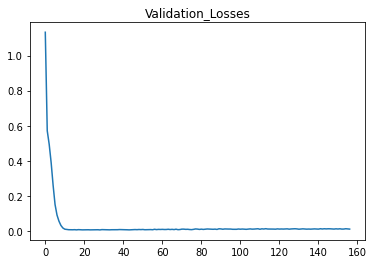

1 1831 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006175045778003195
1 1832 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006173721731092117
1 1833 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006172398535518256
1 1834 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.000617107619036968
1 1835 tensor(0.0033, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006169754694735826
1 1836 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006168434047707489
1 1837 tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006167114248376832
1 1838 tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006165795295837376
1 1839 tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006164477189183996
1 1840 tensor(0.0032, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006163159927512924
1 1841 tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006161843509921741
1 1842 tensor(0.0034, device='cud

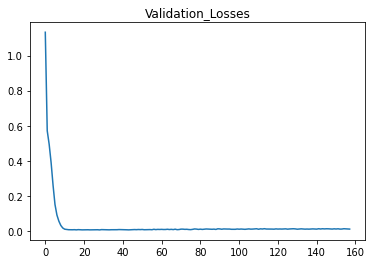

1 1846 tensor(0.0032, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006155274051673784
1 1847 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006153962679686497
1 1848 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006152652145499791
1 1849 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006151342448221962
1 1850 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>) 0.000615003358696264
1 1851 tensor(0.0030, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006148725560832777
1 1852 tensor(0.0033, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006147418368944649
1 1853 tensor(0.0032, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006146112010411852
1 1854 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006144806484349299
1 1855 tensor(0.0033, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006143501789873222
1 1856 tensor(0.0033, device='cuda:0', grad_fn=<MseLossBackward>) 0.0006142197926101163
1 1857 tensor(0.0035, device='cud

KeyboardInterrupt: ignored

In [ ]:
criterion = nn.MSELoss()
# TRY to change input dimesion and pass that dimension of noise accordingly
counter_index = 10
pad = 0
max_sequence_length = 176
model = make_model(N=4, d_model_input=300, d_model_output=250, h =5).to(device)

model_opt = get_std_opt(model)
losses_list = []
skeleton_part_loss_list = [] # losses separated by body, hands, face
validation_losses = []
validation_part_loss_list = []
for epoch in range(500):
    loss, loss_by_parts = train_epoch(train_loader, model, criterion, model_opt, epoch)
    skeleton_part_loss_list.append(loss_by_parts)

    if epoch % 15 == 0:
      losses_list.append(loss)
      
      validation_loss, validation_loss_by_parts = valid_epoch_transformer(validation_loader, model, criterion)
      validation_losses.append(validation_loss)
      validation_part_loss_list.append(validation_loss_by_parts)

      plot_losses(validation_losses,"Validation_Losses")
      
#set where you want to save this.
with open(f"transformer.all.losses.{version}.pkl", "wb") as f:
  pickle.dump({
      "validation_loss": validation_losses,
      "train_loss": losses_list,
      "train_skeleton_part_loss": skeleton_part_loss_list,
      "validation_skeleton_part_loss": validation_part_loss_list,
      "notes": notes
  }, f)

Save model

In [ ]:
torch.save(model, output_folder + 'smaller_trained_transformer_4_300_250_5.pkl')
# model_path = output_folder + 'With_Pretrainedtrained_transformer_6_500_250_5.pkl'
# model = torch.load(model_path)
# model

In [ ]:
!ls '../Training Data/Final 2D Skeletons/'

^C


In [ ]:
data = json.load(open(os.path.join('../Training Data/Final 2D Skeletons/','00602.json')))
max_count = max([int(i) for i in list(data.keys())])
actual_count = 0
temp = []
for count in data.keys():
  if len(data[count]['people']) > 0:
      t = data[count]['people'][0]['pose_keypoints_2d'][:24:] + data[count]['people'][0]['hand_left_keypoints_2d'] + data[count]['people'][0]['hand_right_keypoints_2d'] + data[count]['people'][0]['face_keypoints_2d'] + [actual_count / max_count] + [0] * 9
      temp.append(t)
      actual_count += 1
temp = np.array(temp)
n = temp.shape[-1] - counter_index
X = temp[:, 0:n:3]
Y = temp[:, 1:n:3]
W = temp[:, 2:n:3]
# normalization
X, Y = normalization(X, Y)
# Delete all skeletal models which have a lot of missing parts.
X, Y, W = prune(X, Y, W, (0, 1, 2, 3, 4, 5, 6, 7), 0.3, "float32")
# Preliminary filtering: weighted linear interpolation of missing points.
X, Y, W = interpolation(X, Y, W, 0.99, "float32")
arr = np.append(convList2Array([X, Y]),temp[:,-counter_index:], axis=1)
padded_input = np.zeros((max_sequence_length - len(arr), len(arr[0])))
padded_input[:, -counter_index] = pad
arr = np.vstack((arr, padded_input))
print(arr.shape)

(176, 250)


In [ ]:
# arr = torch.tensor(arr)
# target = torch.zeros(1, 185, 102)
# source = torch.ones(1, arr.shape[0], 102)
# target[:, 0:arr.shape[0], :] = source
encoder_input = torch.tensor(embeddings_dict["accept"], dtype=torch.float32).unsqueeze(0)
decoder_input = torch.zeros(176,250).unsqueeze(0)
noise = Variable(torch.randn((encoder_input.shape[0], 50)))
decoder_input[0][0] = encoder_input #arr[0]
encoder_input = torch.cat((encoder_input,noise),1)
# torch.zeros((185,102)).unsqueeze(0)

i = 0
model.eval()
other_mask = (torch.zeros(1,1,176) != 0).cuda()
with torch.no_grad():
    while ( i <= 174):
        src = Variable(encoder_input, requires_grad=False).cuda()
        trg = Variable(decoder_input,requires_grad=False).cuda()
        other_mask[0][0][i] = True
        out = model.forward(src, trg, other_mask)
        decoder_input[0,i+1,:] = out[0,i,:]
        i += 1

In [ ]:
# get_video(torch.tensor(arr), 'output_movies_b/adult_true.mp4')

In [ ]:
# get_video(torch.tensor(decoder_input[0]), 'output_movies_b/all_out.mp4')

tensor(2.2013)


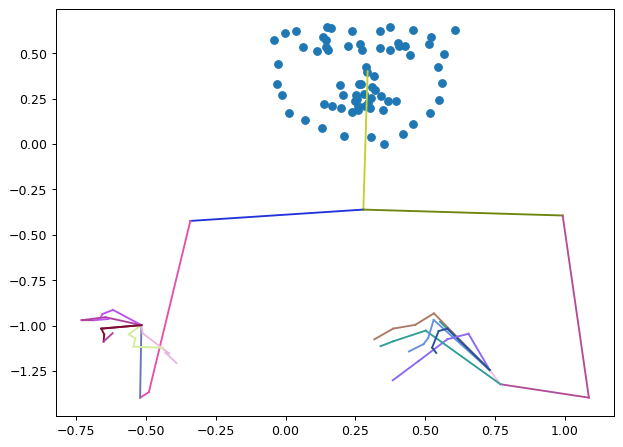

tensor(1.)


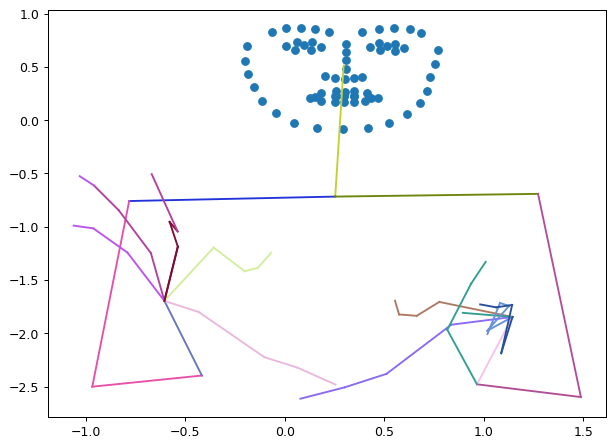

In [ ]:
trim_frames(decoder_input[0].cuda(), torch.from_numpy(arr).cuda(), output_folder+'/output_movies/accept_out_1.mp4',output_folder+'/output_movies/a_gt.mp4')

#GAN

In [ ]:
class Generator(nn.Module):
    # initializers
    def __init__(self, pretrained_model, d=128):
        super(Generator, self).__init__()
        self.model = pretrained_model
        self.model_opt = get_std_opt(self.model)

    # forward method
    def forward(self, src, trg = None):
        if trg is not None:
          begin_frame = src[:,:embedding_dim:].unsqueeze(1).to(device)
          trg = torch.cat((begin_frame, trg),axis=1)
          tgt_mask = Variable(subsequent_mask(max_sequence_length + 1),requires_grad=False).to(device)
          padded_mask = (trg[:,:,-counter_index] != pad).unsqueeze(-2)
          other_mask = (padded_mask & tgt_mask).to(device)
          # todo check the way parameters are passed as expected
          # out = model.forward(src, trg[:, :-1], trg_mask[:, :-1, :-1])
          out = self.model.forward(src, trg, other_mask)
          return out
        else:
          # this is for inference
          trg = torch.zeros(1,max_sequence_length+1,pose_dim)
          trg[0][0] = src[0][:embedding_dim:] #arr[0]
          other_mask = (torch.zeros(1,1,max_sequence_length+1) != 0).cuda()
          i = 0
          with torch.no_grad():
              while ( i <= max_sequence_length - 1):
                  src = Variable(src, requires_grad=False).cuda()
                  trg = Variable(trg,requires_grad=False).cuda()
                  other_mask[0][0][i] = True
                  out = model.forward(src, trg, other_mask)
                  trg[0,i+1,:] = out[0,i,:]
                  i += 1
          return trg[0]  

In [ ]:
class Print(nn.Module):
  def __init__(self):
    super(Print, self).__init__()

  def forward(self,x):
    print('print',x.shape)
    return x
    
class Discriminator(nn.Module):
    def __init__(self, d=64):
        super(Discriminator, self).__init__()
        self.discriminate = nn.Sequential(
            # TRY Removing batch norm or stacking more conv1D
            # check input dim
            # Print(),
            nn.Conv1d(177, d, 10),
            # nn.Conv1d(370, d, 10),            
            nn.LeakyReLU(),
            nn.Conv1d(d, d, 10),
            # nn.BatchNorm1d(d),
            nn.LeakyReLU(),
            nn.Conv1d(d, 1, 10),
            nn.Linear(223, 1),
            nn.Sigmoid()
        )

    def forward(self, input, word):
        input = torch.cat((input,word), 1)
        x = self.discriminate(input)
        return x.squeeze()

In [ ]:
adversarial_loss = torch.nn.BCELoss()
regression_loss = torch.nn.MSELoss()
def weight_initialization(m):
    # custom weights initialization for both networks
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.xavier_uniform(m.weight.data)
    # elif classname.find('BatchNorm') != -1:
    #     nn.init.xavier_uniform(m.weight.data)
    #     nn.init.xavier_uniform(m.bias.data)
# Initialize Generator and discriminator

# we will pass pre trained transformer model
# model = make_model(N=6, d_model_input=500, d_model_output=250, d_ff=1024, h=5, dropout=0.1)
# model = torch.load("")
# TRY : change model and try pretrained or try creating a new transformer
generator = Generator(model)
discriminator = Discriminator()

if torch.cuda.is_available():
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

# Initialize weights
generator.apply(weight_initialization)
discriminator.apply(weight_initialization)

lr = 1e-3
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr) #betas=(args.beta1, args.beta2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr) #betas=(args.beta1, args.beta2))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  import sys


In [ ]:
def valid_epoch_GAN(valid_iter, generator, discriminator, criterion):
    model.eval()
    total_generative_loss = 0
    total_words = 0
    hand_losses = 0 
    torso_losses = 0
    face_losses = 0
    with torch.no_grad():  
      for i, batch in enumerate(valid_iter):
        embeddings = batch['embedding'].cuda()
        poses = batch['poses'].cuda()

        real_imgs = Variable(poses.type(torch.FloatTensor).cuda())
        
        valid = Variable(torch.ones(real_imgs.shape[0]).cuda(), requires_grad=False)
        
        noise = Variable(torch.randn((real_imgs.shape[0], output_dim)).cuda())
        gen_input = torch.cat((embeddings,noise),1)

        gen_imgs = generator(gen_input, poses)
        #gen_y_for_D = tile(embeddings.cuda().unsqueeze(1), 1, max_sequence_length)
        gen_y_for_D = embeddings.unsqueeze(1)

        g_loss_regression = 100 * regression_loss(gen_imgs[:,:-1:], poses)
        g_loss_adversarial = 0.001 * adversarial_loss(discriminator(gen_imgs[:,1::],gen_y_for_D).squeeze(), valid)
        total_generative_loss += g_loss_regression + g_loss_adversarial
        total_words += embeddings.shape[0]
                
        torso_loss, hand_loss, face_loss = compute_skeleton_losses_by_parts(pred=gen_imgs[:, :-1], ground_truth=poses, criterion=regression_loss)
        torso_losses += torso_loss
        hand_losses += hand_loss
        face_losses += face_loss

    return total_generative_loss / len(valid_iter), {"torso": torso_losses / len(valid_iter), "hand": hand_losses / len(valid_iter), "face": face_losses / len(valid_iter)}

tensor(2.)


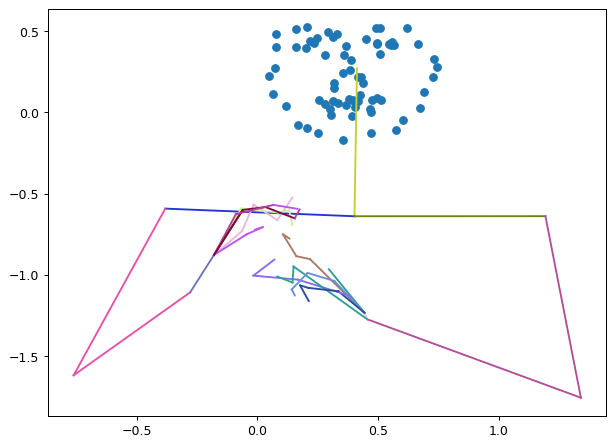

tensor(2.)


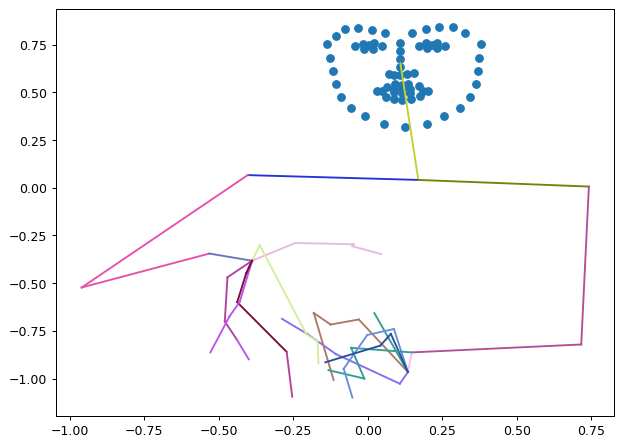

[Epoch 0/3000] [Batch 316/317] [D loss: 0.791467] [G loss: 2.698665]
tensor(2.)


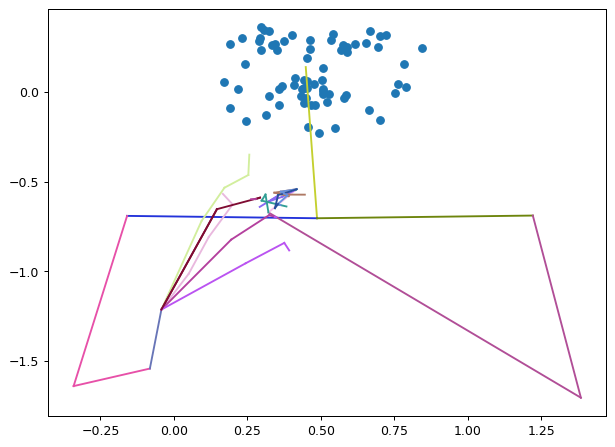

tensor(2.)


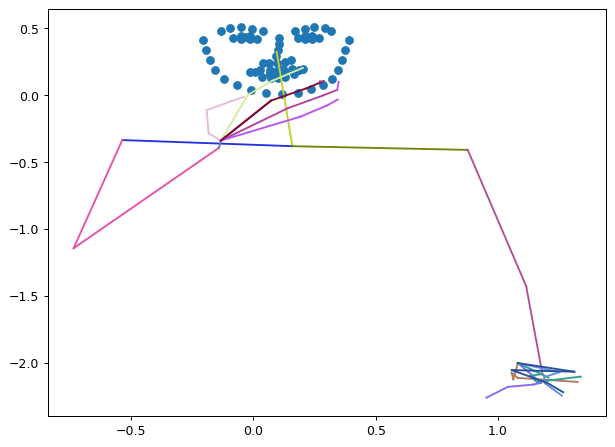

[Epoch 1/3000] [Batch 316/317] [D loss: 0.868515] [G loss: 3.693093]
[Epoch 2/3000] [Batch 316/317] [D loss: 1.054170] [G loss: 4.318990]
tensor(2.0123)


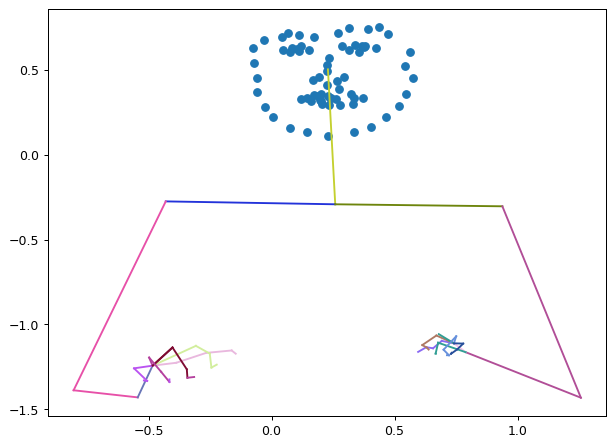

tensor(2.)


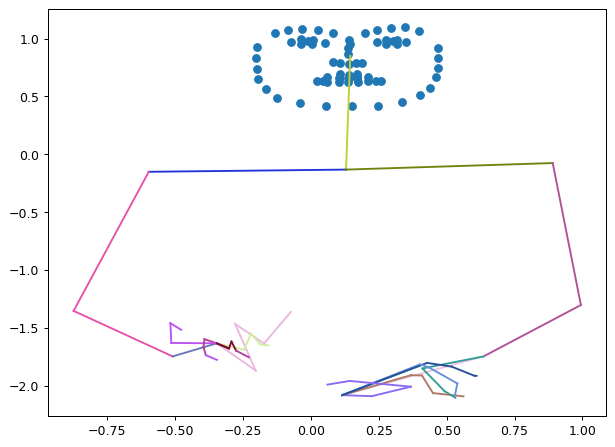

[Epoch 3/3000] [Batch 316/317] [D loss: 1.043212] [G loss: 3.763091]
tensor(2.0008)


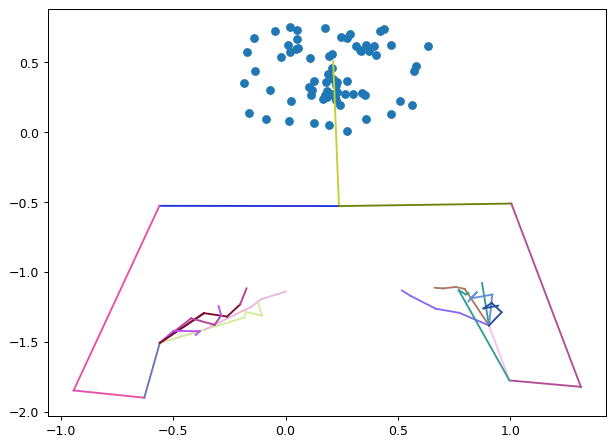

tensor(2.)


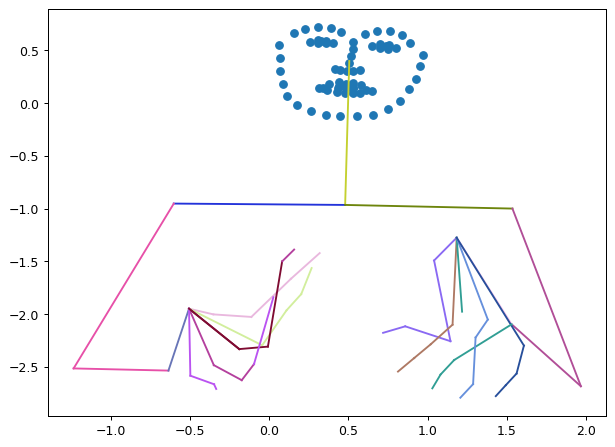

[Epoch 4/3000] [Batch 316/317] [D loss: 1.710109] [G loss: 3.723568]
[Epoch 5/3000] [Batch 316/317] [D loss: 1.206973] [G loss: 3.480270]
tensor(2.)


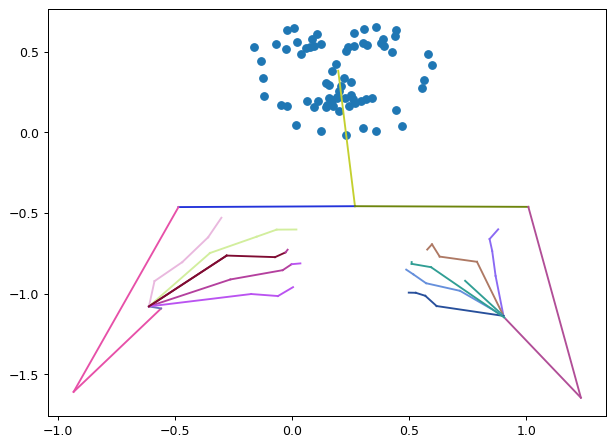

tensor(2.)


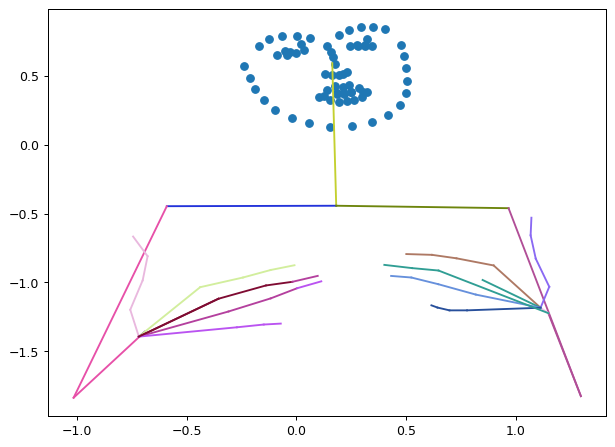

[Epoch 6/3000] [Batch 316/317] [D loss: 1.813052] [G loss: 3.110596]
tensor(2.)


In [ ]:
batch_size = 16
validation_split = .2
shuffle_dataset = True
random_seed= 42
n_epochs = 3000
output_dim = 250
sample_interval = 500
pose_dim = 250
embedding_dim = 250
generator_losses = []
discriminator_losses = [] 
generator_validation_losses = []
skeleton_part_validation_losses = []

hand_losses = []
torso_losses = []
face_losses = []
for epoch in range(n_epochs):
    generator_loss = 0
    discriminator_loss = 0
    hand_loss = 0
    torso_loss = 0
    face_loss = 0
    for i, batch in enumerate(train_loader):
        embeddings = batch['embedding'].cuda()
        poses = batch['poses'].cuda()
        
        # Configure input
        real_imgs = Variable(poses.type(torch.FloatTensor).cuda())
        real_y = torch.ones(real_imgs.shape[0],output_dim).cuda()
        # real_y = real_y.scatter_(1, labels.view(Batch_Size, 1), 1).view(Batch_Size, N_Class, 1, 1).contiguous()
        real_y = Variable(real_y.cuda())

        
        valid = Variable(torch.ones(real_imgs.shape[0]).cuda(), requires_grad=False)
        fake = Variable(torch.zeros(real_imgs.shape[0]).cuda(), requires_grad=False)

        # Sample noise and labels as generator input
        # noise = Variable(torch.randn((Batch_Size, output_dim)).cuda())
        # gen_labels = (torch.rand(Batch_Size, 1) * N_Class).type(torch.LongTensor)
        # check 1 dim
        # gen_y = Variable(gen_y.scatter_(1, gen_labels.view(Batch_Size, 1), 1).view(Batch_Size, N_Class,1,1).cuda())
        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()
        # Loss for real images
        # gen_y = tile(gen_y.unsqueeze(2), 2, max_sequence_length).reshape(-1, 185, 364)
        # print(gen_y.unsqueeze(1).shape, real_imgs.shape)

        # gen_y = tile(embeddings.cuda().unsqueeze(1), 1, max_sequence_length)
        gen_y = embeddings.unsqueeze(1)
        # print(gen_y.shape)
        d_real_loss = adversarial_loss(discriminator(real_imgs, gen_y), valid) #batch x 185 x 364; batch x 300
        # Loss for fake images
        # TRY change noise dimension according to the pretrained or according to what is passed in make model
        noise = Variable(torch.randn((real_imgs.shape[0], output_dim)).cuda())
        gen_input = torch.cat((embeddings,noise),1)
        gen_imgs = generator(gen_input, poses)
        # gen_y_for_D = tile(embeddings.cuda().unsqueeze(1), 1, max_sequence_length)
        gen_y_for_D = embeddings.unsqueeze(1)
        # gen_y_for_D = gen_y.view(Batch_Size, N_Class, 1, 1).contiguous().expand(-1, -1, img_size, img_size)
        d_fake_loss = adversarial_loss(discriminator(gen_imgs.detach()[:,1:],gen_y_for_D), fake)
        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss)
        d_loss.backward()
        optimizer_D.step()

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()
        # TRY different weights for regression loss weights
        g_loss_regression = 1000 * regression_loss(gen_imgs[:,:-1:], poses)
        g_loss_adversarial = 0.001 * adversarial_loss(discriminator(gen_imgs[:,1::],gen_y_for_D).squeeze(), valid)
        # total_genereator_loss = 100 * g_loss_regression + 0.001 * g_loss_adversarial
        total_generator_loss = g_loss_regression + g_loss_adversarial
        total_generator_loss.backward()
        optimizer_G.step()

        generator_loss += total_generator_loss
        discriminator_loss += d_loss

                
        batch_torso_loss, batch_hand_loss, batch_face_loss = compute_skeleton_losses_by_parts(pred=gen_imgs[:, :-1], ground_truth=poses, criterion=regression_loss)
        torso_loss += batch_torso_loss
        hand_loss += batch_hand_loss
        face_loss += batch_face_loss

        batches_done = epoch * len(train_loader) + i
        if batches_done % sample_interval == 0:
            # fixed labels
            sample_embedding = embeddings[0:1]
            sample_poses = poses[0:1]
            noise = Variable(torch.randn((sample_embedding.shape[0], output_dim)).cuda())
            gen_input = torch.cat((sample_embedding,noise),1)
            gen_imgs = generator(gen_input)
            # save_image(gen_imgs.data, img_save_path + '/%d-%d.png' % (epoch,batches_done), nrow=N_Class, normalize=True)
            trim_frames(gen_imgs[:-1:],sample_poses[0],output_folder+"/output_movies/gen_output"+str(epoch)+".mp4",output_folder+"/output_movies/gen_gt"+str(epoch)+".mp4")
    
    print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]" % (epoch, n_epochs, i, len(train_loader), d_loss.data.cpu(), total_generator_loss.data.cpu()))
    discriminator_losses.append(discriminator_loss / len(train_loader))
    generator_losses.append(generator_loss/len(train_loader))
    hand_losses.append(hand_loss/len(train_loader))
    torso_losses.append(torso_loss/len(train_loader))
    face_losses.append(face_loss/len(train_loader))
    generator_validation_loss, skeleton_part_val_loss = valid_epoch_GAN(validation_loader, generator, discriminator, regression_loss)
    generator_validation_losses.append(generator_validation_loss)
    skeleton_part_validation_losses.append(skeleton_part_val_loss)


# plotting the losses
print(generator_losses,discriminator_losses)
plot_losses(generator_losses,"Generator Loss")
plot_losses(discriminator_losses,"Discriminator Loss")
plot_losses(generator_validation_losses,"Generator Validation Loss")

version = "v1"
notes = "first pass at running the base GAN model."
#set where you want to save this.
with open(output_folder + f"gan.all.losses.{version}.pkl", "wb") as f:
  pickle.dump({
      "generator_train_loss": generator_losses,
      "discriminator_train_loss": discriminator_losses,
      "generator_val_loss": generator_validation_losses,
      "train_skeleton_part_loss": {"hand": hand_losses, "torso": torso_losses, "face": face_losses},
      "val_skeleton_part_loss": skeleton_part_validation_losses,
      "notes": notes
  }, f)

In [ ]:
torch.save(generator, output_folder + 'trained_gan_with_pretrained_transformer_6_500_250_5.pkl')
torch.save(discriminator, output_folder + 'trained_gan_with_pretrained_transformer_6_500_250_5.pkl')

# A Real World Example

In [ ]:
# Detail. Batching seems to matter quite a bit. 
# This is temporary code for dynamic batching based on number of tokens.
# This code should all go away once things get merged in this library.
#Todo if not necessary remove later
BATCH_SIZE = 4096
global max_src_in_batch, max_tgt_in_batch
def batch_size_fn(new, count, sofar):
    "Keep augmenting batch and calculate total number of tokens + padding."
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch,  len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)

class MyIterator(data.Iterator):
    def create_batches(self):
        if self.train:
            def pool(d, random_shuffler):
                for p in data.batch(d, self.batch_size * 100):
                    p_batch = data.batch(
                        sorted(p, key=self.sort_key),
                        self.batch_size, self.batch_size_fn)
                    for b in random_shuffler(list(p_batch)):
                        yield b
            self.batches = pool(self.data(), self.random_shuffler)
            
        else:
            self.batches = []
            for b in data.batch(self.data(), self.batch_size,
                                          self.batch_size_fn):
                self.batches.append(sorted(b, key=self.sort_key))

def rebatch(pad_idx, batch):
    "Fix order in torchtext to match ours"
    src, trg = batch.src.transpose(0, 1), batch.trg.transpose(0, 1)
    src_mask, trg_mask = make_std_mask(src, trg, pad_idx)
    return Batch(src, trg, src_mask, trg_mask, (trg[1:] != pad_idx).data.sum())

train_iter = MyIterator(train, batch_size=BATCH_SIZE, device=0,
                        repeat=False, sort_key=lambda x: (len(x.src), len(x.trg)),
                        batch_size_fn=batch_size_fn, train=True)
valid_iter = MyIterator(val, batch_size=BATCH_SIZE, device=0,
                        repeat=False, sort_key=lambda x: (len(x.src), len(x.trg)),
                        batch_size_fn=batch_size_fn, train=False)

In [ ]:
# Create the model an load it onto our GPU.
model = make_model()
model_opt = get_std_opt(model)
model.cuda()

In [ ]:

criterion = LabelSmoothing(size=len(TGT.vocab), padding_idx=pad_idx, smoothing=0.1)
criterion.cuda()
for epoch in range(15):
    train_epoch((rebatch(pad_idx, b) for b in train_iter), model, criterion, model_opt)
    valid_epoch((rebatch(pad_idx, b) for b in valid_iter), model, criterion)


OTHER

In [ ]:
BOS_WORD = '<s>'
EOS_WORD = '</s>'
BLANK_WORD = "<blank>"
SRC = data.Field()
TGT = data.Field(init_token = BOS_WORD, eos_token = EOS_WORD, pad_token=BLANK_WORD) # only target needs BOS/EOS

MAX_LEN = 100
train = datasets.TranslationDataset(path="/n/home00/srush/Data/baseline-1M_train.tok.shuf", 
                                    exts=('.en', '.fr'),
                                    fields=(SRC, TGT), 
                                    filter_pred=lambda x: len(vars(x)['src']) <= MAX_LEN and 
                                         len(vars(x)['trg']) <= MAX_LEN)
SRC.build_vocab(train.src, max_size=50000)
TGT.build_vocab(train.trg, max_size=50000)

In [ ]:
pad_idx = TGT.vocab.stoi["<blank>"]
print(pad_idx)
model = make_model(len(SRC.vocab), len(TGT.vocab), pad_idx, N=6)
model_opt = get_opt(model)
model.cuda()

In [ ]:
criterion = LabelSmoothing(size=len(TGT.vocab), padding_idx=pad_idx, label_smoothing=0.1)
criterion.cuda()
for epoch in range(15):
    train_epoch(train_iter, model, criterion, model_opt)
    valid_epoch()

In [ ]:
print(pad_idx)
print(len(SRC.vocab))

In [ ]:
torch.save(model, "/n/rush_lab/trans_ipython.pt")

In [ ]:
#weight = torch.ones(len(TGT.vocab))
#weight[pad_idx] = 0
#criterion = nn.NLLLoss(size_average=False, weight=weight.cuda())
criterion = LabelSmoothing(size=len(TGT.vocab), padding_idx=pad_idx, label_smoothing=0.1)
criterion.cuda()
for epoch in range(15):
    train_epoch(train_iter, model, criterion, model_opt)

In [ ]:
1 10.825187489390373 6.987712429686844e-07
101 9.447168171405792 3.56373333914029e-05
201 7.142856806516647 7.057589553983712e-05
301 6.237934365868568 0.00010551445768827134
401 5.762486848048866 0.00014045301983670557
501 5.415792358107865 0.00017539158198513977
601 5.081815680023283 0.000210330144133574
701 4.788327748770826 0.00024526870628200823
801 4.381739928154275 0.0002802072684304424
901 4.55433791608084 0.00031514583057887664
1001 4.911875109748507 0.0003500843927273108
1101 4.0579032292589545 0.0003850229548757451
1201 4.2276234351193125 0.0004199615170241793
1301 3.932735869428143 0.00045490007917261356
1401 3.8179439397063106 0.0004898386413210477
1501 3.3608515430241823 0.000524777203469482
1601 3.832796103321016 0.0005597157656179162
1701 2.907085266895592 0.0005946543277663504
1801 3.5280659823838505 0.0006295928899147847
1901 2.895841649500653 0.0006645314520632189
2001 3.273784235585481 0.000699470014211653
2101 3.181488689899197 0.0007344085763600873
2201 3.4151616653980454 0.0007693471385085215
2301 3.4343731447588652 0.0008042857006569557
2401 3.0505455391539726 0.0008392242628053899
2501 2.8089329147478566 0.0008741628249538242
2601 2.7827929875456903 0.0009091013871022583
2701 2.4428516102489084 0.0009440399492506926
2801 2.4015486147254705 0.0009789785113991267
2901 2.3568112018401735 0.001013917073547561
3001 2.6349758653668687 0.0010488556356959952
3101 2.5981983028614195 0.0010837941978444295
3201 2.666826274838968 0.0011187327599928637
3301 3.0092043554177508 0.0011536713221412978
3401 2.4580375660589198 0.0011886098842897321
3501 2.586465588421561 0.0012235484464381662
3601 2.5663993963389657 0.0012584870085866006
3701 2.9430236657499336 0.0012934255707350347
3801 2.464644919440616 0.001328364132883469
3901 2.7124062888276512 0.0013633026950319032
4001 2.646443709731102 0.0013971932312809247
4101 2.7294750874862075 0.001380057517579748
4201 2.1295202329056337 0.0013635372009002666
4301 2.596563663915731 0.001347596306985731
4401 2.1265982036820787 0.0013322017384983986
4501 2.3880532500334084 0.0013173229858148
4601 2.6129120760888327 0.0013029318725783852
4701 2.2873719420749694 0.001289002331178292
4801 2.4949760700110346 0.0012755102040816328
4901 2.496607314562425 0.001262433067573089
5001 2.1889712483389303 0.0012497500749750088
5101 1.8677761815488338 0.0012374418168536253
5201 2.2992054556962103 0.0012254901960784316
5301 2.664361578106707 0.0012138783159049418
5401 2.705850490485318 0.0012025903795063202
5501 2.581445264921058 0.0011916115995949978
5601 2.2480602325085783 0.0011809281169581616
5701 1.9289666265249252 0.0011705269268863989
5801 2.4863578918157145 0.0011603958126073107
5901 2.632946971571073 0.0011505232849492607
6001 2.496141305891797 0.0011408985275576757
6101 2.6422974687084206 0.0011315113470699342
6201 2.448802186456305 0.0011223521277270118

In [ ]:
temp = torch.Tensor([[[1,1,0,-1],[-1,-1,2,3],[1,0,2,3]],
                     [[1,-1,2,3],[-1,1,2,3],[0,0,2,3]],
                     [[2,-2,2,3],[-2,2,2,3],[0,2,2,3]],
                     [[2,0,2,3],[-2,0,2,3],[0,-2,2,3]]
                     ])
extra = torch.Tensor([[[1,1,1,1]],
                     [[1,1,1,1]],
                     [[1,1,1,1]],
                     [[1,1,1,1]]
                     ])
print(temp.size())
print(temp)
t = temp.repeat(1,5)
print(t.size())
print(t)
'''
temp = torch.cat((temp, extra),axis = 1)
print(temp)
#u = torch.where(temp[:,:,1:2]>=1, temp, torch.zeros_like(temp))
#print(u)
x_centers = torch.unsqueeze(temp[:,:,0],axis = 2)
y_centers = torch.unsqueeze(temp[:,:,1],axis = 2)
#print(x_centers,y_centers)
centers = torch.cat((x_centers,y_centers), 2).repeat(repeats=(1,1,temp.size()[2]-2))
centers[:,:, -1::] = 0
print(centers)
temp -= centers
print(temp)   
# indices_of_one = torch.where(temp[:,:,1] >= 1.0,temp,torch.zeros(3,2))
# print(indices_of_one)
# temp = torch.where(temp <= 1, temp, torch.zeros(4,3,2))
# print(temp)
'''

In [ ]:
real_y = torch.zeros(16, 10)
real_y = real_y.scatter_(1, labels.view(Batch_Size, 1), 1).view(Batch_Size, N_Class, 1, 1).contiguous()
real_y = Variable(real_y.expand(-1, -1, img_size, img_size).cuda())

In [ ]:
def load_embeddings():
    word_embeddings = []
    words = []
    with (open("data/interim/embeddings.pkl", "rb")) as openfile:
        while True:
            try:
                word_embeddings.append(pickle.load(openfile))
            except EOFError:
                break
    with (open("./data/interim/words.pkl", "rb")) as openfile:
        while True:
            try:
                words.append(pickle.load(openfile))
            except EOFError:
                break
    return word_embeddings, words

def get_word_embedding(word, word_embeddings, words):
    indices = np.argwhere(words[0] == word)[0]
    return word_embeddings[0][indices[0]]



In [ ]:
encoder_input = torch.tensor(embeddings_dict['all'], dtype=torch.float32).unsqueeze(0)
decoder_input = torch.zeros(185,102).unsqueeze(0)
# torch.zeros((185,102)).unsqueeze(0)

i = 0
model.eval()
other_mask = (torch.zeros(1,1,185) != 0).cuda()
with torch.no_grad():
    while ( i <= 183):
        src = Variable(encoder_input, requires_grad=False).cuda()
        trg = Variable(decoder_input,requires_grad=False).cuda()
        other_mask[0][0][i] = True
        out = model.forward(src, trg, other_mask)
        decoder_input[0,i+1,:] = out[0,i,:]
        i += 1
        # print(i)